<a href="https://colab.research.google.com/github/englian1123/KL-High-Rise-Data/blob/main/PMA_CS17_ModelTrainingEvaluation_MP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MP2**

# OLS

In [ ]:
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import numpy as np # Import numpy

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv')

# Data cleaning and preprocessing
# Clean ParcelArea (extract numeric part before ",sq.m")
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)

# Convert UnitLevel to numeric
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce')

# Encode Tenure (Freehold = 1, Leasehold = 0)
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Convert TransactionDate to datetime and then to numeric (days since earliest date)
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            try:
                return datetime.strptime(date_str, '%Y-%m-%d') # Added format
            except ValueError:
                return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = df['TransactionPrice']

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add constant for intercept
X = sm.add_constant(X)

# Run OLS regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression summary
print(results.summary())

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3256278374.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


                            OLS Regression Results                            
Dep. Variable:       TransactionPrice   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     3247.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:10:22   Log-Likelihood:            -2.0882e+05
No. Observations:               14362   AIC:                         4.177e+05
Df Residuals:                   14350   BIC:                         4.178e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

# VIF (Variance Inflation Factor)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
print(vif)

         VIF                         Feature
0   0.000000                           const
1   1.139846                      ParcelArea
2   1.037320                    Date_numeric
3   1.259177                  Tenure_encoded
4   1.055024                   Level_numeric
5        inf  Mukim_Kuala Lumpur Town Centre
6        inf              Mukim_Mukim Ampang
7        inf                Mukim_Mukim Batu
8        inf              Mukim_Mukim Cheras
9        inf        Mukim_Mukim Kuala Lumpur
10       inf            Mukim_Mukim Petaling
11       inf             Mukim_Mukim Setapak
12       inf          Mukim_Mukim Ulu Kelang


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


# **Non-normal Residuals**

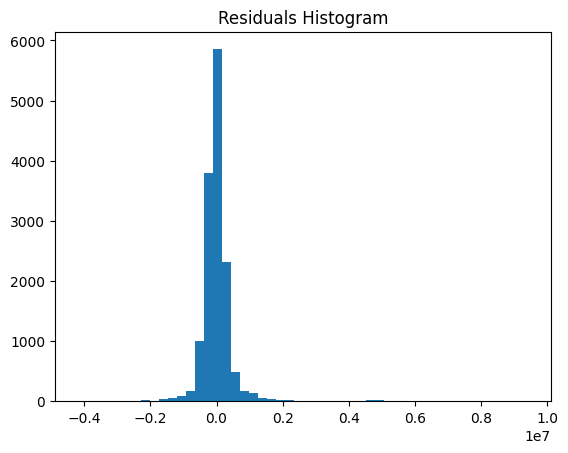

In [ ]:
import matplotlib.pyplot as plt
plt.hist(results.resid, bins=50)
plt.title('Residuals Histogram')
plt.show()

# the observations with residuals > 500,000

In [ ]:
import numpy as np
residuals = results.resid
outliers = residuals[residuals > 500000].index
print(df.loc[outliers, ['TransactionPrice', 'ParcelArea', 'Mukim', 'Tenure']])

       TransactionPrice  ParcelArea                     Mukim     Tenure
5               1000000        77.0  Kuala Lumpur Town Centre   Freehold
7               4050000       326.0  Kuala Lumpur Town Centre   Freehold
12              1100000        76.0  Kuala Lumpur Town Centre   Freehold
17              1300000       110.0  Kuala Lumpur Town Centre   Freehold
27              1200000        76.0  Kuala Lumpur Town Centre   Freehold
...                 ...         ...                       ...        ...
14253            440000        54.0             Mukim Setapak  Leasehold
14255            440000        54.0             Mukim Setapak  Leasehold
14326            444000        54.0             Mukim Setapak  Leasehold
14359           2600000       232.0  Kuala Lumpur Town Centre  Leasehold
14383           1516000       130.0        Mukim Kuala Lumpur  Leasehold

[801 rows x 4 columns]


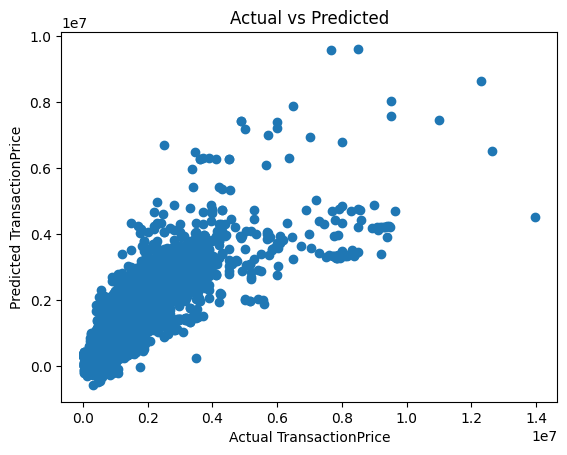

In [ ]:
plt.scatter(y, results.fittedvalues)
plt.xlabel('Actual TransactionPrice')
plt.ylabel('Predicted TransactionPrice')
plt.title('Actual vs Predicted')
plt.show()

# Transform the Dependent Variable

In [ ]:
import numpy as np
y = np.log(df['TransactionPrice'].loc[X.index])
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       TransactionPrice   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     2889.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:28:25   Log-Likelihood:                -7087.9
No. Observations:               14362   AIC:                         1.420e+04
Df Residuals:                   14350   BIC:                         1.429e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Check for **Nonlinearity**

In [ ]:
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       TransactionPrice   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     3250.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:36:37   Log-Likelihood:                -6043.1
No. Observations:               14362   AIC:                         1.211e+04
Df Residuals:                   14349   BIC:                         1.221e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Residual Plot again

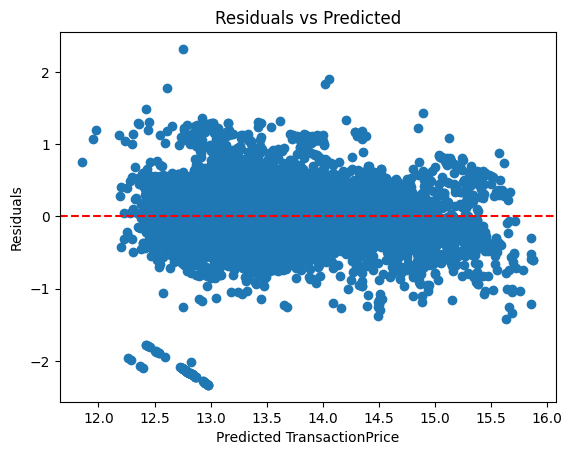

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted TransactionPrice')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# Robust Standard **Errors**

In [ ]:
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       TransactionPrice   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                 1.699e+06
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:43:13   Log-Likelihood:                -6043.1
No. Observations:               14362   AIC:                         1.211e+04
Df Residuals:                   14349   BIC:                         1.221e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

# *Overall combined*

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:       TransactionPrice   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     2805.
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        04:08:39   Log-Likelihood:                -6887.8
No. Observations:               14010   AIC:                         1.380e+04
Df Residuals:                   13998   BIC:                         1.389e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------


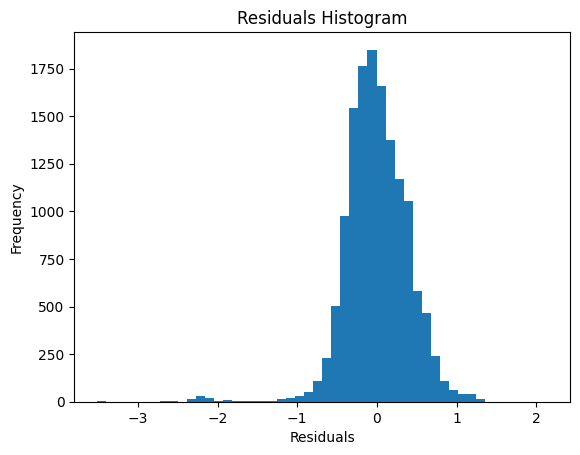

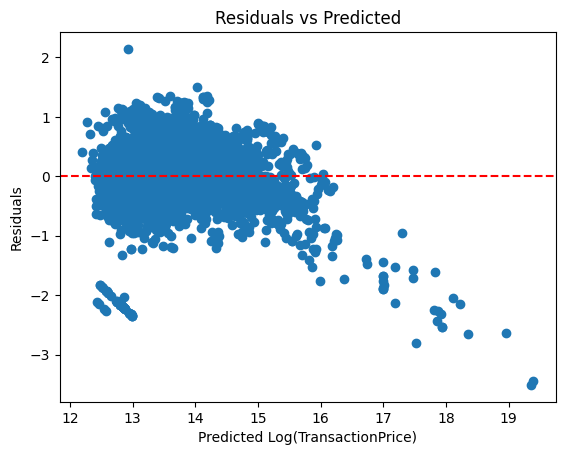

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])  # Log-transform the target

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add constant for intercept
X = sm.add_constant(X)

# Run OLS regression
model = sm.OLS(y, X)
results = model.fit()

# Print regression summary
print("OLS Regression Summary:")
print(results.summary())

# Calculate VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
print("\nVIF Results:")
print(vif)

# Plot residuals histogram
plt.hist(results.resid, bins=50)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot residuals vs predicted values
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Log(TransactionPrice)')
plt.ylabel('Residuals')
plt.show()

OLS Regression Summary with Robust Standard Errors:
                            OLS Regression Results                            
Dep. Variable:       TransactionPrice   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     1044.
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        04:09:43   Log-Likelihood:                -6887.8
No. Observations:               14010   AIC:                         1.380e+04
Df Residuals:                   13998   BIC:                         1.389e+04
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

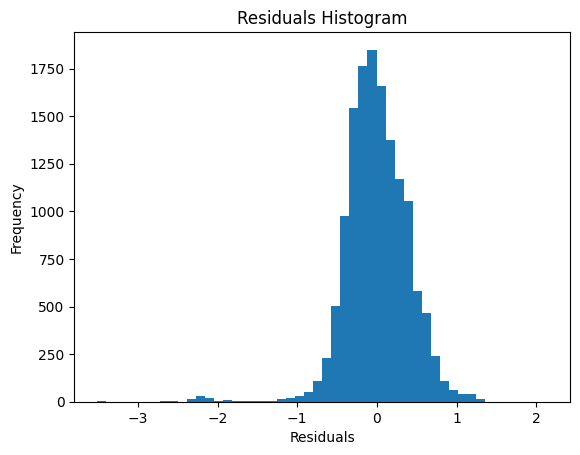

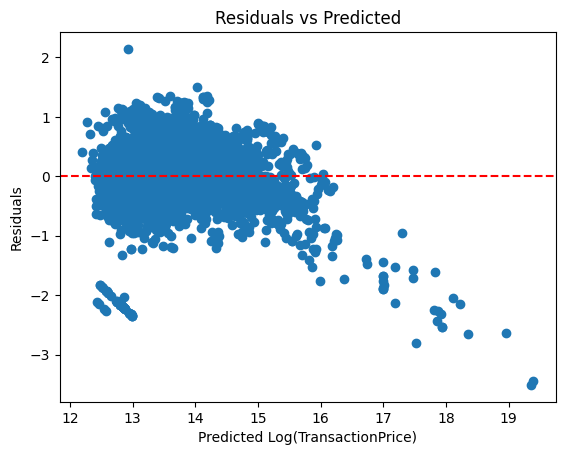

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add constant for intercept
X = sm.add_constant(X)

# Run OLS regression with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')

# Print regression summary
print("OLS Regression Summary with Robust Standard Errors:")
print(results.summary())

# Calculate VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
print("\nVIF Results:")
print(vif)

# Detect outliers
outliers = results.resid[abs(results.resid) > 2 * results.resid.std()].index
print(f"\nNumber of outliers (residuals > 2 SD): {len(outliers)}")
print(df.loc[outliers, ['TransactionPrice', 'ParcelArea', 'Mukim', 'Tenure']])

# Plot residuals histogram
plt.hist(results.resid, bins=50)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot residuals vs predicted values
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Log(TransactionPrice)')
plt.ylabel('Residuals')
plt.show()

Number of outliers removed: 531
Outlier details:
       TransactionPrice  ParcelArea                     Mukim     Tenure
5               1000000        77.0  Kuala Lumpur Town Centre   Freehold
11               180000        78.0  Kuala Lumpur Town Centre   Freehold
12              1100000        76.0  Kuala Lumpur Town Centre   Freehold
17              1300000       110.0  Kuala Lumpur Town Centre   Freehold
27              1200000        76.0  Kuala Lumpur Town Centre   Freehold
...                 ...         ...                       ...        ...
14336             42000        92.0             Mukim Setapak  Leasehold
14337             42000        92.0             Mukim Setapak  Leasehold
14338             42000        92.0             Mukim Setapak  Leasehold
14340             42000        92.0             Mukim Setapak  Leasehold
14383           1516000       130.0        Mukim Kuala Lumpur  Leasehold

[531 rows x 4 columns]

OLS Regression Summary with Robust Standard Errors

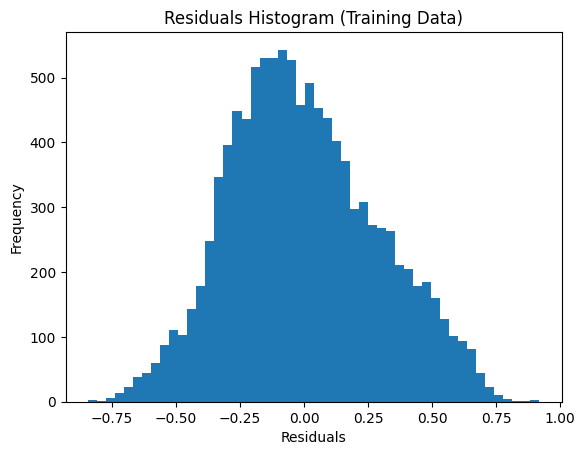

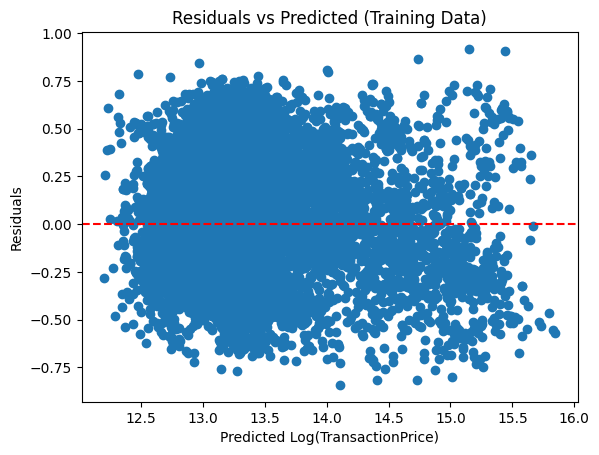

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['Date_numeric_sq'] = X['Date_numeric'] ** 2

# Add constant for intercept
X = sm.add_constant(X)

# Detect and remove outliers (residuals > 2 SD)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * model_initial.resid.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")
print(f"Outlier details:\n{df.loc[outliers, ['TransactionPrice', 'ParcelArea', 'Mukim', 'Tenure']]}")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run OLS regression with robust standard errors on training data
model = sm.OLS(y_train, X_train)
results = model.fit(cov_type='HC3')

# Print regression summary
print("\nOLS Regression Summary with Robust Standard Errors (Training Data):")
print(results.summary())

# Calculate VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
print("\nVIF Results:")
print(vif)

# Predict on test set and calculate RMSE
y_pred = results.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"\nTest RMSE: {rmse}")

# Plot residuals histogram
plt.hist(results.resid, bins=50)
plt.title('Residuals Histogram (Training Data)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot residuals vs predicted values
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted (Training Data)')
plt.xlabel('Predicted Log(TransactionPrice)')
plt.ylabel('Residuals')
plt.show()

Number of outliers removed: 518
Outlier details:
       TransactionPrice  ParcelArea                     Mukim     Tenure
5               1000000        77.0  Kuala Lumpur Town Centre   Freehold
11               180000        78.0  Kuala Lumpur Town Centre   Freehold
12              1100000        76.0  Kuala Lumpur Town Centre   Freehold
17              1300000       110.0  Kuala Lumpur Town Centre   Freehold
27              1200000        76.0  Kuala Lumpur Town Centre   Freehold
...                 ...         ...                       ...        ...
14336             42000        92.0             Mukim Setapak  Leasehold
14337             42000        92.0             Mukim Setapak  Leasehold
14338             42000        92.0             Mukim Setapak  Leasehold
14340             42000        92.0             Mukim Setapak  Leasehold
14383           1516000       130.0        Mukim Kuala Lumpur  Leasehold

[518 rows x 4 columns]

OLS Regression Summary with Robust Standard Errors

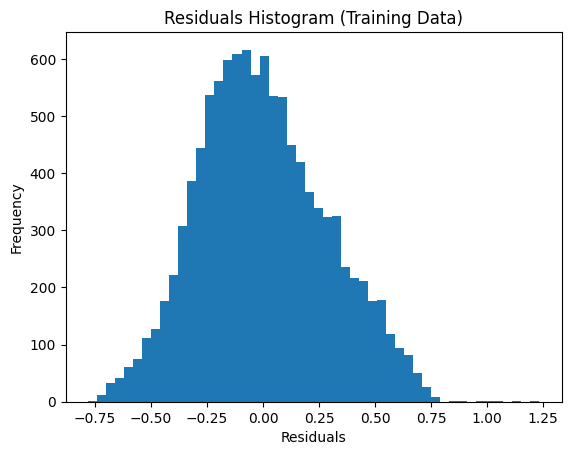

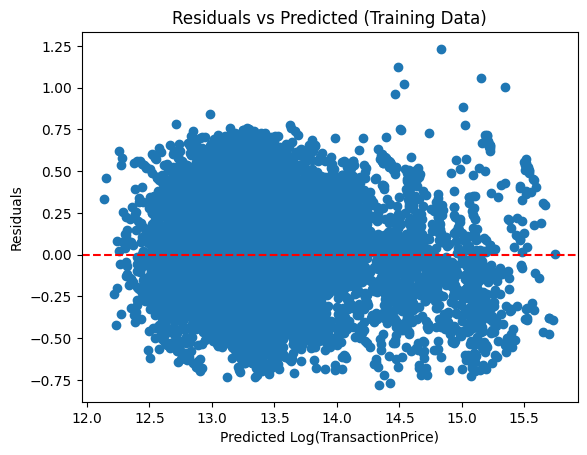

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']
X['Date_numeric_sq'] = X['Date_numeric'] ** 2

# Add constant for intercept
X = sm.add_constant(X)

# Detect and remove outliers (residuals > 2 SD)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")
print(f"Outlier details:\n{df.loc[outliers, ['TransactionPrice', 'ParcelArea', 'Mukim', 'Tenure']]}")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop non-significant terms from both training and test sets
cols_to_drop = ['Date_numeric_sq', 'Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

# Run OLS regression with robust standard errors on training data
model = sm.OLS(y_train, X_train)
results = model.fit(cov_type='HC3')

# Print regression summary
print("\nOLS Regression Summary with Robust Standard Errors (Training Data):")
print(results.summary())

# Calculate VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
print("\nVIF Results:")
print(vif)

# Predict on test set and calculate RMSE
y_pred = results.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"\nTest RMSE: {rmse}")

# Plot residuals histogram
plt.hist(results.resid, bins=50)
plt.title('Residuals Histogram (Training Data)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot residuals vs predicted values
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted (Training Data)')
plt.xlabel('Predicted Log(TransactionPrice)')
plt.ylabel('Residuals')
plt.show()

Number of outliers removed: 654
Outlier details:
       TransactionPrice  ParcelArea                     Mukim     Tenure  \
7               4050000      326.00  Kuala Lumpur Town Centre   Freehold   
11               180000       78.00  Kuala Lumpur Town Centre   Freehold   
12              1100000       76.00  Kuala Lumpur Town Centre   Freehold   
22              3300000      308.00  Kuala Lumpur Town Centre   Freehold   
27              1200000       76.00  Kuala Lumpur Town Centre   Freehold   
...                 ...         ...                       ...        ...   
14340             42000       92.00             Mukim Setapak  Leasehold   
14359           2600000      232.00  Kuala Lumpur Town Centre  Leasehold   
14372            250000       86.00                Mukim Batu  Leasehold   
14379            220000       79.43                Mukim Batu  Leasehold   
14381            250000       86.00                Mukim Batu  Leasehold   

                       SchemeName  
7 

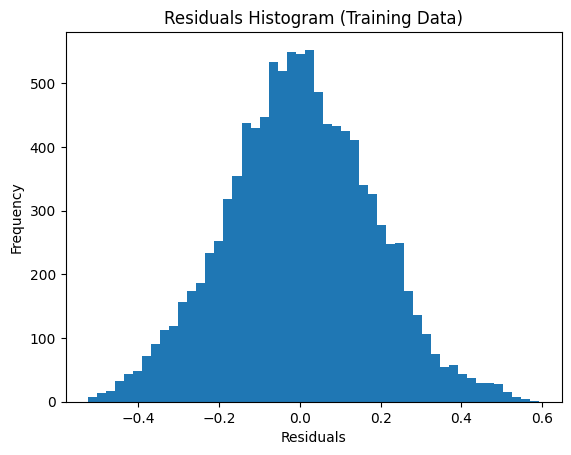

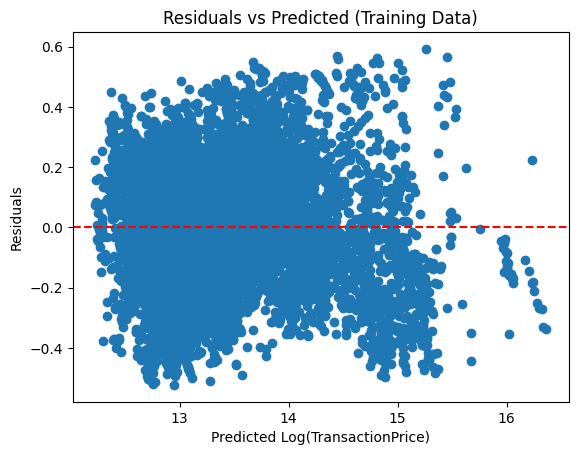

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders import TargetEncoder

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Add SchemeName as a target-encoded feature
encoder = TargetEncoder(cols=['SchemeName'])
df['SchemeName_encoded'] = encoder.fit_transform(df['SchemeName'], np.log(df['TransactionPrice']))

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']
X['Date_numeric_sq'] = X['Date_numeric'] ** 2 # Moved this up

# Add constant for intercept
X = sm.add_constant(X)

# Detect and remove outliers (residuals > 2 SD)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")
print(f"Outlier details:\n{df.loc[outliers, ['TransactionPrice', 'ParcelArea', 'Mukim', 'Tenure', 'SchemeName']]}")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop non-significant terms
cols_to_drop = ['Date_numeric_sq', 'Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

# Run OLS regression with robust standard errors on training data
model = sm.OLS(y_train, X_train)
results = model.fit(cov_type='HC3')

# Print regression summary
print("\nOLS Regression Summary with Robust Standard Errors (Training Data):")
print(results.summary())

# Calculate VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
print("\nVIF Results:")
print(vif)

# Predict on test set and calculate RMSE
y_pred = results.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"\nTest RMSE: {rmse}")

# Plot residuals histogram
plt.hist(results.resid, bins=50)
plt.title('Residuals Histogram (Training Data)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot residuals vs predicted values
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted (Training Data)')
plt.xlabel('Predicted Log(TransactionPrice)')
plt.ylabel('Residuals')
plt.show()

Number of outliers removed: 654
Outlier details:
       TransactionPrice  ParcelArea                     Mukim     Tenure  \
7               4050000      326.00  Kuala Lumpur Town Centre   Freehold   
11               180000       78.00  Kuala Lumpur Town Centre   Freehold   
12              1100000       76.00  Kuala Lumpur Town Centre   Freehold   
22              3300000      308.00  Kuala Lumpur Town Centre   Freehold   
27              1200000       76.00  Kuala Lumpur Town Centre   Freehold   
...                 ...         ...                       ...        ...   
14340             42000       92.00             Mukim Setapak  Leasehold   
14359           2600000      232.00  Kuala Lumpur Town Centre  Leasehold   
14372            250000       86.00                Mukim Batu  Leasehold   
14379            220000       79.43                Mukim Batu  Leasehold   
14381            250000       86.00                Mukim Batu  Leasehold   

                       SchemeName  
7 

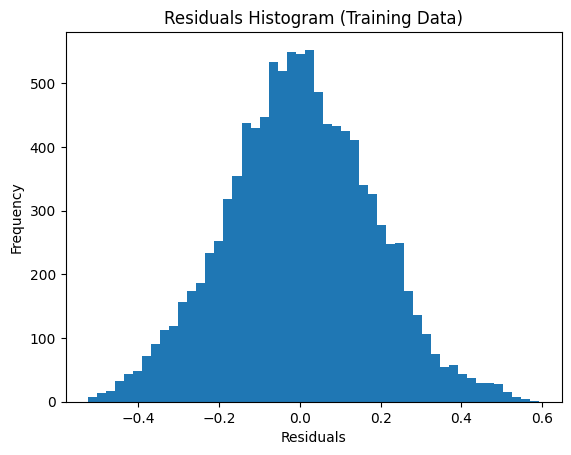

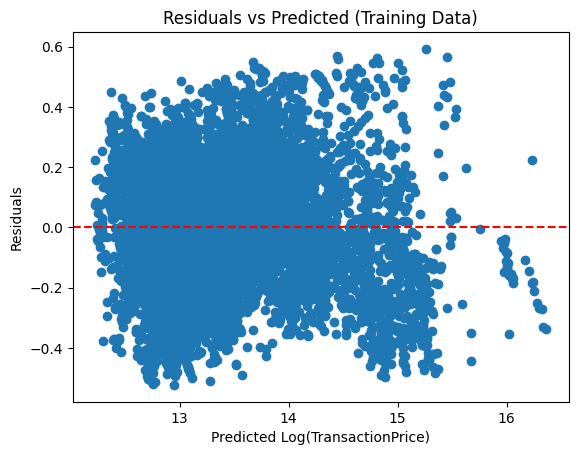

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders import TargetEncoder

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Add SchemeName as a target-encoded feature
encoder = TargetEncoder(cols=['SchemeName'])
df['SchemeName_encoded'] = encoder.fit_transform(df['SchemeName'], np.log(df['TransactionPrice']))

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms with centering
X['ParcelArea'] = X['ParcelArea'] - X['ParcelArea'].mean()
X['SchemeName_encoded'] = X['SchemeName_encoded'] - X['SchemeName_encoded'].mean()
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']
X['Date_numeric_sq'] = X['Date_numeric'] ** 2 # Moved this up

# Add constant for intercept
X = sm.add_constant(X)

# Detect and remove outliers (residuals > 2 SD)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")
print(f"Outlier details:\n{df.loc[outliers, ['TransactionPrice', 'ParcelArea', 'Mukim', 'Tenure', 'SchemeName']]}")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop non-significant terms from both training and test sets
cols_to_drop = ['Date_numeric_sq', 'Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop) # Also drop from X_test

# Run OLS regression with robust standard errors on training data
model = sm.OLS(y_train, X_train)
results = model.fit(cov_type='HC3')

# Print regression summary
print("\nOLS Regression Summary with Robust Standard Errors (Training Data):")
print(results.summary())

# Calculate VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
print("\nVIF Results:")
print(vif)

# Predict on test set and calculate RMSE
y_pred = results.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"\nTest RMSE: {rmse}")

# Plot residuals histogram
plt.hist(results.resid, bins=50)
plt.title('Residuals Histogram (Training Data)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot residuals vs predicted values
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted (Training Data)')
plt.xlabel('Predicted Log(TransactionPrice)')
plt.ylabel('Residuals')
plt.show()

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Manual Target Encoding for SchemeName
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Add constant for intercept
X = sm.add_constant(X)

# Detect and remove outliers (residuals > 2 SD)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop non-significant terms (based on previous runs)
cols_to_drop = ['Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

# OLS Model with statsmodels (with HC3)
model_ols = sm.OLS(y_train, X_train)
results_ols = model_ols.fit(cov_type='HC3')
print("\nOLS Summary:")
print(results_ols.summary())

# LinearRegression with sklearn
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions and metrics for OLS
y_pred_ols = results_ols.predict(X_test)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test, y_pred_ols)

# Predictions and metrics for LinearRegression
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

# Coefficients comparison
ols_coefs = results_ols.params
lr_coefs = pd.Series(lr.coef_, index=X_train.columns)  # Use all columns for index
lr_coefs['const'] = lr.intercept_  # Explicitly set the intercept

print("\nComparison:")
print(f"OLS R-squared (Test): {r2_ols}")
print(f"LR R-squared (Test): {r2_lr}")
print(f"OLS RMSE (Test): {rmse_ols}")
print(f"LR RMSE (Test): {rmse_lr}")

print("\nOLS Coefficients:")
print(ols_coefs)

print("\nLR Coefficients:")
print(lr_coefs)

# Check if coefficients are similar
coeff_diff = ols_coefs - lr_coefs
print("\nCoefficient Differences (OLS - LR):")
print(coeff_diff)

Number of outliers removed: 498

OLS Summary:
                            OLS Regression Results                            
Dep. Variable:       TransactionPrice   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 1.573e+04
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        09:39:39   Log-Likelihood:                 6118.4
No. Observations:               10809   AIC:                        -1.221e+04
Df Residuals:                   10796   BIC:                        -1.212e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Manual Target Encoding for SchemeName
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Detect and remove outliers (residuals > 2 SD) using initial OLS
import statsmodels.api as sm
X = sm.add_constant(X)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")

# Scale features for regularization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Drop non-significant terms (based on previous OLS)
drop_cols = ['const', 'Date_numeric', 'Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X_train = pd.DataFrame(X_train, columns=X.columns).drop(columns=drop_cols)
X_test = pd.DataFrame(X_test, columns=X.columns).drop(columns=drop_cols)

# Models
lr = LinearRegression()
ridge = Ridge(alpha=1.0)  # Default alpha, tune later
lasso = Lasso(alpha=1.0)  # Default alpha, tune later

# Fit and predict
models = {'LinearRegression': lr, 'Ridge': ridge, 'Lasso': lasso}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}

    # Cross-validation (5-fold)
    cv_rmse = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_mean = np.sqrt(cv_rmse.mean())
    results[name]['CV RMSE'] = cv_rmse_mean
    print(f"{name} - Test RMSE: {rmse:.4f}, Test R2: {r2:.4f}, CV RMSE: {cv_rmse_mean:.4f}")

# Feature importance (coefficients)
for name, model in models.items():
    coefs = pd.Series(model.coef_, index=X_train.columns)
    print(f"\n{name} Coefficients:")
    print(coefs.sort_values(ascending=False))

# Alpha tuning (example for Ridge)
alphas = [0.01, 0.1, 1.0, 10.0]
best_alpha = 1.0
best_cv_rmse = float('inf')
for alpha in alphas:
    ridge_tuned = Ridge(alpha=alpha)
    cv_rmse = -cross_val_score(ridge_tuned, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_mean = np.sqrt(cv_rmse.mean())
    if cv_rmse_mean < best_cv_rmse:
        best_cv_rmse = cv_rmse_mean
        best_alpha = alpha
print(f"\nBest Ridge alpha: {best_alpha}, CV RMSE: {best_cv_rmse:.4f}")

Number of outliers removed: 498
LinearRegression - Test RMSE: 0.1413, Test R2: 0.9567, CV RMSE: 0.1376
Ridge - Test RMSE: 0.1413, Test R2: 0.9567, CV RMSE: 0.1376
Lasso - Test RMSE: 0.6789, Test R2: -0.0001, CV RMSE: 0.6696

LinearRegression Coefficients:
SchemeName_encoded          0.518196
ParcelArea                  0.226074
Level_numeric               0.021394
ParcelArea_Level            0.014376
Mukim_Mukim Kuala Lumpur    0.008881
Mukim_Mukim Petaling        0.002410
Mukim_Mukim Cheras         -0.000796
Mukim_Mukim Ampang         -0.003039
Tenure_encoded             -0.005848
Mukim_Mukim Setapak        -0.006436
ParcelArea_sq              -0.080685
dtype: float64

Ridge Coefficients:
SchemeName_encoded          0.518147
ParcelArea                  0.225880
Level_numeric               0.021378
ParcelArea_Level            0.014414
Mukim_Mukim Kuala Lumpur    0.008878
Mukim_Mukim Petaling        0.002395
Mukim_Mukim Cheras         -0.000797
Mukim_Mukim Ampang         -0.003039
Tenur

In [ ]:
alphas = [0.01, 0.1, 0.5]
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    cv_rmse = -cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"Lasso alpha={alpha}, CV RMSE: {np.sqrt(cv_rmse.mean()):.4f}")

Lasso alpha=0.01, CV RMSE: 0.1413
Lasso alpha=0.1, CV RMSE: 0.1791
Lasso alpha=0.5, CV RMSE: 0.5295


In [ ]:
df['SchemeName_Mukim'] = df['SchemeName'] + '_' + df['Mukim']
scheme_mukim_mean = df.groupby('SchemeName_Mukim')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_Mukim_encoded'] = df['SchemeName_Mukim'].map(scheme_mukim_mean)
# Update X_train, X_test with new encoding, drop Mukim dummies
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print(f"Ridge with SchemeName_Mukim - Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.4f}")

Ridge with SchemeName_Mukim - Test RMSE: 0.1413


# Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

dt = DecisionTreeRegressor(max_depth=5, random_state=42)  # Limit depth to avoid overfitting
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
print(f"Decision Tree - Test RMSE: {rmse_dt:.4f}, Test R2: {r2_dt:.4f}")

Decision Tree - Test RMSE: 0.1540, Test R2: 0.9486


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
dt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_dt = grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
print(f"Best Decision Tree - Test RMSE: {rmse_dt:.4f}, Test R2: {r2_dt:.4f}, Best Params: {grid_search.best_params_}")

Best Decision Tree - Test RMSE: 0.1243, Test R2: 0.9665, Best Params: {'max_depth': 10, 'min_samples_split': 10}


In [ ]:
from sklearn.model_selection import cross_val_score
cv_rmse = -cross_val_score(best_dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"CV RMSE: {np.sqrt(cv_rmse.mean()):.4f}")

CV RMSE: 0.1235


In [ ]:
importances = best_dt.feature_importances_
feature_names = X_train.columns
importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Decision Tree Feature Importance:")
print(importance_df)

Decision Tree Feature Importance:
SchemeName_encoded          0.951925
ParcelArea_sq               0.036254
ParcelArea                  0.007508
ParcelArea_Level            0.001969
Level_numeric               0.000874
Mukim_Mukim Kuala Lumpur    0.000388
Tenure_encoded              0.000354
Mukim_Mukim Setapak         0.000331
Mukim_Mukim Petaling        0.000313
Mukim_Mukim Ampang          0.000083
Mukim_Mukim Cheras          0.000000
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest - Test RMSE: {rmse_rf:.4f}")

Random Forest - Test RMSE: 0.1261


In [ ]:
df['SchemeName_Mukim'] = df['SchemeName'] + '_' + df['Mukim']
scheme_mukim_mean = df.groupby('SchemeName_Mukim')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_Mukim_encoded'] = df['SchemeName_Mukim'].map(scheme_mukim_mean)

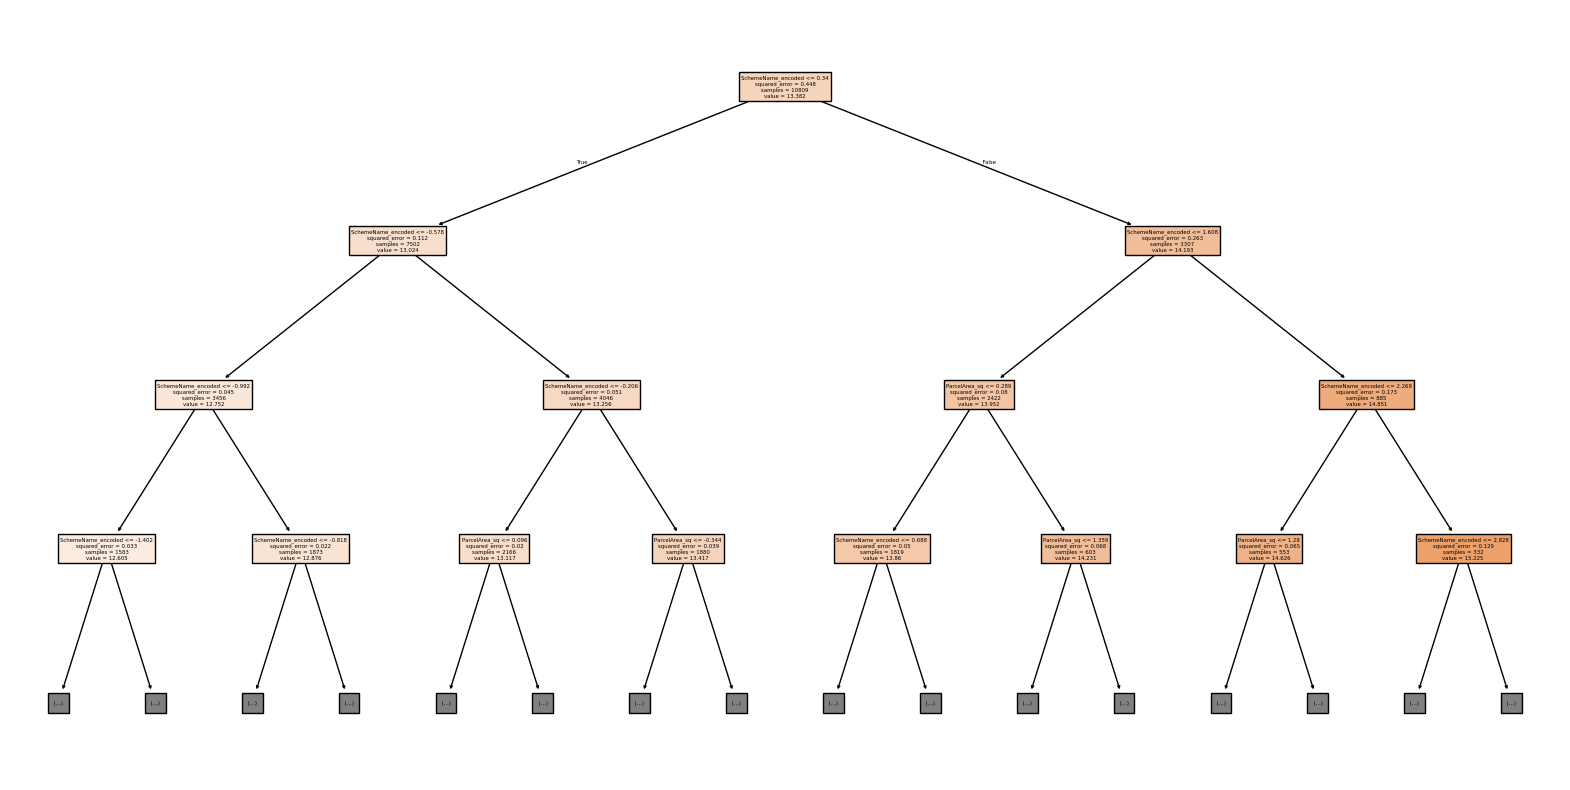

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plot_tree(best_dt, feature_names=X_train.columns, max_depth=3, filled=True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest - Test RMSE: {rmse_rf:.4f}")

Random Forest - Test RMSE: 0.1156


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_split=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest - Test RMSE: {rmse_rf:.4f}")

Random Forest - Test RMSE: 0.1127


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Calculate 5-fold cross-validation RMSE for the Random Forest model
cv_rmse = -cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the average CV RMSE
print(f"Random Forest CV RMSE: {np.sqrt(cv_rmse.mean()):.4f}")

Random Forest CV RMSE: 0.1102


In [ ]:
X_train = X_train.drop(columns=[col for col in X_train.columns if col.startswith('Mukim_')])
X_test = X_test.drop(columns=[col for col in X_test.columns if col.startswith('Mukim_')])

# Retrain the ridge model after dropping columns
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Ridge without Mukim - Test RMSE: {rmse_ridge:.4f}")

# Retrain the Random Forest model after dropping columns
rf.fit(X_train, y_train)

Ridge without Mukim - Test RMSE: 0.1419


RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=42)

In [ ]:
cv_rmse = -cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Random Forest CV RMSE: {np.sqrt(cv_rmse.mean()):.4f}")

Random Forest CV RMSE: 0.1134


In [ ]:
importances = rf.feature_importances_
feature_names = X_train.columns
print("Random Forest Feature Importance:")
print(pd.Series(importances, index=feature_names).sort_values(ascending=False))

Random Forest Feature Importance:
SchemeName_encoded    0.952626
ParcelArea_sq         0.021125
ParcelArea            0.020881
ParcelArea_Level      0.003534
Level_numeric         0.001346
Tenure_encoded        0.000489
dtype: float64


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [8, 10, 12], 'min_samples_split': [5, 10, 15]}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"Best Params: {grid_search.best_params_}, Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

Best Params: {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}, Best CV RMSE: 0.1102


In [1]:
# Load the dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor # Import RandomForestRegressor
from datetime import datetime # Import datetime for date parsing

df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Manual Target Encoding for SchemeName
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Detect and remove outliers (residuals > 2 SD) using initial OLS
import statsmodels.api as sm
X = sm.add_constant(X)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")

# Drop non-significant terms *before* splitting and scaling
cols_to_drop = ['const','Date_numeric', 'Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X = X.drop(columns=cols_to_drop, errors='ignore')

# Drop Mukim columns *before* splitting and scaling (as done in hJE0VErapuMu based on feature importance analysis)
X = X.drop(columns=[col for col in X.columns if col.startswith('Mukim_')])

# Get the final list of column names *after* all dropping operations
final_column_names = X.columns.tolist()

# Split data into training and test sets
# Using X and y after outlier removal and feature dropping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for regularization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert scaled NumPy arrays back to DataFrames to retain column names for feature importance
X_train = pd.DataFrame(X_train, columns=final_column_names)
X_test = pd.DataFrame(X_test, columns=final_column_names)


# Use the best parameters found from the grid search in cell kQxjaAYAzmO4
best_rf_params = {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}

# Initialize the Random Forest Regressor with the best parameters
rf_best = RandomForestRegressor(**best_rf_params, random_state=42)

# Fit the model to the training data
rf_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf_best = rf_best.predict(X_test)

# Evaluate the model
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print("Random Forest Regressor with Best Parameters:")
print(f"Test RMSE: {rmse_rf_best:.4f}")
print(f"Test R2: {r2_rf_best:.4f}")

# Access and print feature importances (Corrected)
importances = rf_best.feature_importances_
feature_names = X_train.columns
importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nRandom Forest Feature Importances:")
print(importance_df)

Number of outliers removed: 498
Random Forest Regressor with Best Parameters:
Test RMSE: 0.1127
Test R2: 0.9724

Random Forest Feature Importances:
SchemeName_encoded    0.947943
ParcelArea            0.022018
ParcelArea_sq         0.021804
ParcelArea_Level      0.005217
Level_numeric         0.002336
Tenure_encoded        0.000682
dtype: float64


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
# Load the dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor # Import RandomForestRegressor
from datetime import datetime # Import datetime for date parsing
from category_encoders import TargetEncoder # Import TargetEncoder

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Manual Target Encoding for SchemeName
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)

# Add SchemeName as a target-encoded feature
# encoder = TargetEncoder(cols=['SchemeName'])
# df['SchemeName_encoded'] = encoder.fit_transform(df['SchemeName'], np.log(df['TransactionPrice']))

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Detect and remove outliers (residuals > 2 SD) using initial OLS
import statsmodels.api as sm
X = sm.add_constant(X)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")

# Drop Mukim columns *before* splitting and scaling
X = X.drop(columns=[col for col in X.columns if col.startswith('Mukim_')])

# Drop non-significant terms *before* splitting and scaling
cols_to_drop = ['const','Date_numeric', 'Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X = X.drop(columns=cols_to_drop, errors='ignore')

# Get the final list of column names *after* all dropping operations
final_column_names = X.columns.tolist()

# Scale features for regularization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Use the best parameters found from the grid search in cell kQxjaAYAzmO4
best_rf_params = {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}

# Initialize the Random Forest Regressor with the best parameters
rf_best = RandomForestRegressor(**best_rf_params, random_state=42)

# Fit the model to the training data
rf_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf_best = rf_best.predict(X_test)

# Evaluate the model
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print("Random Forest Regressor with Best Parameters:")
print(f"Test RMSE: {rmse_rf_best:.4f}")
print(f"Test R2: {r2_rf_best:.4f}")

from sklearn.model_selection import cross_val_score
import numpy as np

# Calculate 5-fold cross-validation scores for the Random Forest model
# Use negative mean squared error for RMSE and r2 for R-squared
cv_mse_scores = -cross_val_score(rf_best, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='r2')

# Calculate the average CV RMSE and R2
cv_rmse_mean = np.sqrt(cv_mse_scores.mean())
cv_r2_mean = cv_r2_scores.mean()

# Print the average CV RMSE and R2
print("Random Forest Cross-Validation Results:")
print(f"Average CV RMSE: {cv_rmse_mean:.4f}")
print(f"Average CV R2: {cv_r2_mean:.4f}")



ModuleNotFoundError: No module named 'category_encoders'

In [ ]:
# Output the sequence of features used in the model

# Assume final_column_names is available from a previous cell containing data preparation
# (e.g., mb7YTfUhQcpm, Gb3kB_KIKsM8, JVNnca-wRc6j, or 7bdebc87)

try:
    print("Feature sequence used in the model:")
    print(final_column_names)
except NameError:
    print("Error: 'final_column_names' is not defined. Please make sure a cell that prepares the data and defines this variable has been run.")

Feature sequence used in the model:
['ParcelArea', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded', 'ParcelArea_sq', 'ParcelArea_Level']


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': final_column_names,
    'Importance': rf_best.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

              Feature  Importance
3  SchemeName_encoded    0.947943
0          ParcelArea    0.022018
4       ParcelArea_sq    0.021804
5    ParcelArea_Level    0.005217
2       Level_numeric    0.002336
1      Tenure_encoded    0.000682


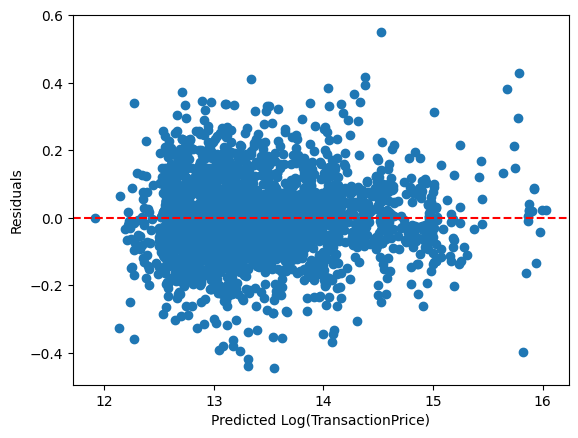

In [ ]:
import matplotlib.pyplot as plt
residuals = y_test - y_pred_rf_best
plt.scatter(y_pred_rf_best, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log(TransactionPrice)')
plt.ylabel('Residuals')
plt.show()

# SchemeName_Encode

In [ ]:
import pandas as pd

# Assume df DataFrame with 'SchemeName' and 'SchemeName_encoded' columns is available from a previous cell (e.g., mb7YTfUhQcpm)

# Group by original SchemeName and get the mean of the encoded value
# Since SchemeName_encoded is a direct mapping, the mean will be the encoded value for each scheme
scheme_name_mapping_series = df.groupby('SchemeName')['SchemeName_encoded'].mean().sort_values()

# Convert the Series to a DataFrame for exportable full data format
# Resetting index will make SchemeName a column
scheme_name_mapping_df = scheme_name_mapping_series.reset_index()

# Rename the columns for clarity
scheme_name_mapping_df.columns = ['SchemeName', 'SchemeName_encoded_Mean']


print("Mapping of SchemeName to SchemeName_encoded (Exportable Table):")
# Display the mapping DataFrame
# This table can be exported directly from the Colab output
from IPython.display import display
display(scheme_name_mapping_df)

Mapping of SchemeName to SchemeName_encoded (Exportable Table):


,SchemeName,SchemeName_encoded_Mean
0,PANGSAPURI BANDARAYA GOMBAK,10.968198
1,RESIDENSI PANDAN MAS 2,11.058795
2,RESIDENSI VISTA WIRAJAYA,11.379730
3,WEST COURT (TAMAN SRI SENTOSA),11.901583
4,RESIDENSI RAZAKMAS 2,11.918391
...,...,...
727,DEDAUN,15.613915
728,AIRA RESIDENCE,15.617190
729,RESIDENSI 6 KAPAS,15.700092
730,SERAI BUKIT BANDARAYA,15.868943


In [10]:
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive to save the DataFrame
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

# Assume df DataFrame is available from a previous cell (e.g., mb7YTfUhQcpm)

# Define the filename for the saved DataFrame
# You can change the path and filename as needed
filename = '/content/drive/MyDrive/saved_data/schemename_df.csv'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(filename), exist_ok=True)

# Save the DataFrame to a CSV file
try:
    scheme_name_mapping_df.to_csv(filename, index=False) # index=False prevents writing the DataFrame index as a column
    print(f"DataFrame saved successfully to {filename}")
except NameError:
    print("Error: DataFrame 'df' not found. Please make sure the cell preparing the data has been run.")
except Exception as e:
    print(f"An error occurred while saving the DataFrame: {e}")

Mounted at /content/drive
DataFrame saved successfully to /content/drive/MyDrive/saved_data/schemename_df.csv


In [11]:
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive to load the DataFrame
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

# Define the filename for the saved DataFrame (same as in cell 7dd676fd)
filename = '/content/drive/MyDrive/saved_data/schemename_df.csv'

# Load the DataFrame from the CSV file
try:
    df_scheme = pd.read_csv(filename)
    print(f"DataFrame loaded successfully from {filename}")
    # Display the head of the DataFrame to confirm
    print("\nHead of the loaded DataFrame:")
    from IPython.display import display
    display(df_scheme.head())
except FileNotFoundError:
    print(f"Error: DataFrame file not found at {filename}. Please make sure the DataFrame was saved correctly.")
except Exception as e:
    print(f"An error occurred while loading the DataFrame: {e}")

Drive already mounted
DataFrame loaded successfully from /content/drive/MyDrive/saved_data/schemename_df.csv

Head of the loaded DataFrame:


,SchemeName,SchemeName_encoded_Mean
0,PANGSAPURI BANDARAYA GOMBAK,10.968198
1,RESIDENSI PANDAN MAS 2,11.058795
2,RESIDENSI VISTA WIRAJAYA,11.379730
3,WEST COURT (TAMAN SRI SENTOSA),11.901583
4,RESIDENSI RAZAKMAS 2,11.918391


In [12]:
import pandas as pd

# Assume scheme_name_mapping_df is available from a previous cell (e.g., h9NeKHUKg_hM)

def get_encoded_scheme_mean(scheme_name_mapping_df, scheme_name):
    """
    Checks if a scheme name exists in the mapping DataFrame and returns its encoded mean.

    Args:
        scheme_name_mapping_df (pd.DataFrame): DataFrame with 'SchemeName' and 'SchemeName_encoded_Mean' columns.
        scheme_name (str): The scheme name to look up.

    Returns:
        float or None: The encoded mean if the scheme name is found, otherwise None.
    """
    # Check if the scheme name exists in the 'SchemeName' column
    if scheme_name in scheme_name_mapping_df['SchemeName'].values:
        # Get the row where the scheme name matches
        encoded_mean = scheme_name_mapping_df[scheme_name_mapping_df['SchemeName'] == scheme_name]['SchemeName_encoded_Mean'].iloc[0]
        return encoded_mean
    else:
        print(f"Scheme name '{scheme_name}' not found in the mapping.")
        return 10

# Example usage (assuming scheme_name_mapping_df is available)
# You might need to run cell h9NeKHUKg_hM first to create scheme_name_mapping_df

# Example with a scheme name that exists
existing_scheme = 'FERNLEA COURT' # Replace with a scheme name from your data
encoded_value_existing = get_encoded_scheme_mean(scheme_name_mapping_df, existing_scheme)

if encoded_value_existing is not None:
    print(f"The encoded mean for '{existing_scheme}' is: {encoded_value_existing:.4f}")

# Example with a scheme name that does not exist
non_existing_scheme = 'NON_EXISTENT_SCHEME'
encoded_value_non_existing = get_encoded_scheme_mean(scheme_name_mapping_df, non_existing_scheme)

if encoded_value_non_existing is None:
    print(f"Could not retrieve encoded mean for '{non_existing_scheme}'.")

The encoded mean for 'FERNLEA COURT' is: 13.8738
Scheme name 'NON_EXISTENT_SCHEME' not found in the mapping.


# Save Model

In [13]:
import pickle
import os
from google.colab import drive

# Mount Google Drive to save the scaler
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

# Define the filename for the saved scaler
# You can change the path and filename as needed
filename = '/content/drive/MyDrive/saved_models/scaler.pkl'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(filename), exist_ok=True)

# Save the fitted scaler object (scaler is assumed to be defined in a previous cell)
try:
    with open(filename, 'wb') as file:
        pickle.dump(scaler, file)
    print(f"Scaler object saved successfully to {filename}")
except NameError:
    print("Error: Scaler object ('scaler') not found. Please make sure the cell fitting the scaler has been run.")
except Exception as e:
    print(f"An error occurred while saving the scaler: {e}")

Drive already mounted
Scaler object saved successfully to /content/drive/MyDrive/saved_models/scaler.pkl


In [14]:
import pickle
import os
from google.colab import drive

# Mount Google Drive to save the model
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

# Define the filename for the saved model
# You can change the path and filename as needed
filename = '/content/drive/MyDrive/saved_models/random_forest_best_model.pkl'


# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(filename), exist_ok=True)

# Save the trained model (rf_best is assumed to be defined in a previous cell)
try:
    with open(filename, 'wb') as file:
        pickle.dump(rf_best, file)
    print(f"Random Forest model saved successfully to {filename}")
except NameError:
    print("Error: Random Forest model (rf_best) not found. Please make sure the cell training the model has been run.")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Drive already mounted
Random Forest model saved successfully to /content/drive/MyDrive/saved_models/random_forest_best_model.pkl


# Load Model and Scalar

In [15]:
import pickle
import os
from google.colab import drive

# Mount Google Drive to load the model and scaler
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

# Define the filenames for the saved model and scaler
model_filename = '/content/drive/MyDrive/saved_models/random_forest_best_model.pkl'
scaler_filename = '/content/drive/MyDrive/saved_models/scaler.pkl'

# Load the trained model
loaded_rf_model = None # Initialize to None
try:
    with open(model_filename, 'rb') as file:
        rf_model = pickle.load(file)
    print(f"Random Forest model loaded successfully from {model_filename}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_filename}. Please make sure the model was saved correctly.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

# Load the fitted scaler
scaler = None # Initialize to None
try:
    with open(scaler_filename, 'rb') as file:
        scaler = pickle.load(file)
    print(f"Scaler object loaded successfully from {scaler_filename}")
except FileNotFoundError:
    print(f"Error: Scaler file not found at {scaler_filename}. Please make sure the scaler was saved correctly.")
except Exception as e:
    print(f"An error occurred while loading the scaler: {e}")

# You can now use loaded_rf_model and scaler in subsequent cells or code within this cell
# For example, to check the type of the loaded objects:
if loaded_rf_model is not None:
    print(f"\nType of loaded model: {type(loaded_rf_model)}")
if scaler is not None:
    print(f"Type of loaded scaler: {type(scaler)}")

Drive already mounted
Random Forest model loaded successfully from /content/drive/MyDrive/saved_models/random_forest_best_model.pkl
Scaler object loaded successfully from /content/drive/MyDrive/saved_models/scaler.pkl
Type of loaded scaler: <class 'sklearn.preprocessing._data.StandardScaler'>


# Test the Model

In [67]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd # Import pandas
from io import StringIO # Import StringIO
from statsmodels.tsa.stattools import adfuller # Import adfuller

# Assume df, X, y, rf_model, and scaler are available from previous cells

def get_encoded_scheme_mean(scheme_name_mapping_df, scheme_name):
    """
    Checks if a scheme name exists in the mapping DataFrame and returns its encoded mean.

    Args:
        scheme_name_mapping_df (pd.DataFrame): DataFrame with 'SchemeName' and 'SchemeName_encoded_Mean' columns.
        scheme_name (str): The scheme name to look up.

    Returns:
        float or None: The encoded mean if the scheme name is found, otherwise None.
    """
    # Check if the scheme name exists in the 'SchemeName' column
    if scheme_name in scheme_name_mapping_df['SchemeName'].values:
        # Get the row where the scheme name matches
        encoded_mean = scheme_name_mapping_df[scheme_name_mapping_df['SchemeName'] == scheme_name]['SchemeName_encoded_Mean'].iloc[0]
        return encoded_mean
    else:
        print(f"Scheme name '{scheme_name}' not found in the mapping. Using default value.")
        return 10 # Return default value as indicated in the calling code


parcel_area = 100
tenure_encoded = 1
level_numeric = 10
scheme_encoded = 10.968198 # This will be obtained from user input

# Assume scheme_name_mapping_df is available from a previous cell (e.g., h9NeKHUKg_hM or tnuKCtzzl9A5)
# If not, you would need to load it here or pass it to the function
# For testing purposes, let's create a dummy scheme_name_mapping_df if it doesn't exist
try:
    scheme_name_mapping_df
except NameError:
    print("scheme_name_mapping_df not found. Creating a dummy DataFrame for testing.")
    data = {'SchemeName': ['SRI PUTRAMAS', 'OTHER SCHEME'], 'SchemeName_encoded_Mean': [13.0, 12.0]}
    scheme_name_mapping_df = pd.DataFrame(data)


# scheme_name = 'SRI PUTRAMAS' # Example scheme name
# scheme_encoded = get_encoded_scheme_mean(scheme_name_mapping_df, scheme_name)


parcel_area_sq = parcel_area ** 2
parcel_area_level = parcel_area * level_numeric

# Ensure the order of features matches the training data
# Based on cell hx1RRalOgEMy, the feature order is:
# ['ParcelArea', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded', 'ParcelArea_sq', 'ParcelArea_Level']
input_data = np.array([[parcel_area, tenure_encoded, level_numeric, scheme_encoded, parcel_area_sq, parcel_area_level]])


# Scale the input
# Ensure scaler is available from a previous cell (e.g., Gb3kB_KIKsM8 or JVNnca-wRc6j)
# If not, you would need to load it here
try:
    scaler
except NameError:
    print("Scaler not found. Cannot scale input data.")
    # You might want to handle this error more robustly, e.g., exit or raise an exception
    exit()


input_scaled = scaler.transform(input_data)

# Predict in log space and convert to MYR
# Ensure rf_model is available from a previous cell (e.g., Gb3kB_KIKsM8 or JVNnca-wRc6j)
# If not, you would need to load it here
try:
    rf_model
except NameError:
    print("Random Forest model not found. Cannot make prediction.")
    # Handle this error
    exit()


log_prediction = rf_model.predict(input_scaled)[0]
prediction_myr = np.exp(log_prediction)

print(f"\nPredicted Price: {prediction_myr:.2f} MYR")

# Ensure df, X, y are available from previous cells
try:
    df
    X
    y
except NameError:
    print("df, X, or y not found. Cannot create hybrid series for ARIMA.")
    # Handle this error
    exit()


recent_years = df.loc[X.index].groupby(df['TransactionDate'].dt.year).tail(1).sort_values('TransactionDate')
recent_X = X.loc[recent_years.index]
recent_y = y.loc[recent_years.index]
recent_X_scaled = scaler.transform(recent_X)
# rf_pred_recent = np.exp(np.clip(rf_model.predict(recent_X_scaled), -709, 709)) # Increased clipping limit
rf_pred_recent = np.clip(rf_model.predict(recent_X_scaled), -709, 709) # Increased clipping limit
hybrid_series = pd.Series(rf_pred_recent, index=recent_years['TransactionDate'].dt.year)
# hybrid_series = pd.concat([hybrid_series, pd.Series([prediction_myr], index=[df['TransactionDate'].dt.year.max() + 1])])
hybrid_series = pd.concat([hybrid_series, pd.Series([log_prediction], index=[df['TransactionDate'].dt.year.max() + 1])])


print("\nHybrid Series before ARIMA:")
print(hybrid_series)

print("Inspecting hybrid_series:")
print("Length:", len(hybrid_series))
print("Variance:", hybrid_series.var())
print("Infinite values:", np.any(np.isinf(hybrid_series)))
print("NaN values:", np.any(np.isnan(hybrid_series)))
print(hybrid_series.describe())

# Check stationarity
result = adfuller(hybrid_series.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("Warning: Series may not be stationary. Trying d=2.")

# Aggregate for ARIMA baseline
df_agg = df.loc[X.index].groupby(df['TransactionDate'].dt.year)['TransactionPrice'].mean().reset_index()
df_agg['LogPrice'] = np.log(df_agg['TransactionPrice'])
train_agg = df_agg[df_agg['TransactionDate'] <= df_agg['TransactionDate'].max() - 2]
test_agg = df_agg[df_agg['TransactionDate'] > df_agg['TransactionDate'].max() - 2]

# Display the prepared time series
print("Prepared Monthly Time Series for ARIMA Baseline:")
print(df_agg.head(100))
print("\n")

# # Fit ARIMA on aggregated data
model_arima = ARIMA(train_agg['LogPrice'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()
arima_pred = model_arima_fit.forecast(steps=len(test_agg))
arima_pred_price = np.exp(arima_pred)
rmse_arima = np.sqrt(mean_squared_error(test_agg['TransactionPrice'], arima_pred_price))
r2_arima = r2_score(test_agg['TransactionPrice'], arima_pred_price)
print(f"\nARIMA Baseline Performance on Test Set:")
print(f"RMSE (Original MYR): {rmse_arima:.0f}")
print(f"R²: {r2_arima:.4f}")


# Fit ARIMA(1,1,1) model

# hybrid_series_clipped = np.clip(hybrid_series, -100, 100)
# Scale if variance is high
# scale_factor = hybrid_series_clipped.std() if hybrid_series_clipped.std() > 0 else 1
# hybrid_series_scaled = hybrid_series_clipped / scale_factor

model_hybrid = ARIMA(hybrid_series.dropna(), order=(1, 0, 1))
model_hybrid_fit = model_hybrid.fit()
hybrid_forecast = model_hybrid_fit.forecast(steps=2)
hybrid_forecast_prices = np.exp(np.clip(hybrid_forecast, -709, 709)) # Increased clipping limit and added clipping to forecast
print("\nHybrid Forecast before int conversion:")
print(hybrid_forecast_prices)

# Forecast the next 2 years
forecast = model_hybrid_fit.forecast(steps=2)
forecast_years = [hybrid_series.index[-1] + 1, hybrid_series.index[-1] + 2]
forecast_series = pd.Series(forecast, index=forecast_years)

# print("\nARIMA Forecast for the next 2 years:")
for year, price in forecast_series.items():
    print(f"Year {year}: {price:.2f} MYR")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



Predicted Price: 593820.80 MYR

Hybrid Series before ARIMA:
2021    13.113261
2022    13.130125
2023    13.506209
2024    12.937843
2025    12.686279
2026    13.294333
dtype: float64
Inspecting hybrid_series:
Length: 6
Variance: 0.0801086040503736
Infinite values: False
NaN values: False
count     6.000000
mean     13.111342
std       0.283035
min      12.686279
25%      12.981698
50%      13.121693
75%      13.253281
max      13.506209
dtype: float64
ADF Statistic: -2.0038557990845813
p-value: 0.2848850290077207


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of


ARIMA Baseline Performance on Test Set:
RMSE (Original MYR): 22525
R²: -14.0167

Hybrid Forecast before int conversion:
6    512124.044548
7    497522.122868
Name: predicted_mean, dtype: float64
Year 2027: nan MYR
Year 2028: nan MYR


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [40]:
print("Checking hybrid_series for invalid values:")
print(hybrid_series.describe())
print("Infinite values:", np.any(np.isinf(hybrid_series)))
print("NaN values:", np.any(np.isnan(hybrid_series)))

Checking hybrid_series for invalid values:
count         6.000000
mean     511029.847439
std      142247.995886
min      323281.480163
25%      435681.083387
50%      499682.738294
75%      571339.611581
max      733959.693453
dtype: float64
Infinite values: False
NaN values: False


In [41]:
print("Variance of hybrid_series:", hybrid_series.var())
if hybrid_series.var() < 1e-10:
    print("Warning: hybrid_series has near-zero variance, unsuitable for ARIMA.")

Variance of hybrid_series: 20234492333.708252


In [42]:
print("Length of hybrid_series:", len(hybrid_series))

Length of hybrid_series: 6


In [43]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(hybrid_series.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("Warning: Series may not be stationary. Consider adjusting differencing (d).")

ADF Statistic: -1.9073102915373272
p-value: 0.32862997247924636


/tmp/ipython-input-1641217904.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hpi_clean['LogPrice'] = np.log(df_hpi_clean ['Price'])
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been 

ADF Test for LogPrice:
ADF Statistic: -0.9606
p-value: 0.7674
Critical Values: {'1%': np.float64(-4.331573), '5%': np.float64(-3.23295), '10%': np.float64(-2.7487)}
LogPrice is non-stationary (p-value > 0.05). Using ARIMA(1,1,1).


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



ARIMA Performance (In-Sample):
Order: (1, 1, 1)
R-squared (R²): 0.4505
RMSE (RM): 72438.79

Forecast for 2025–2026:
         Year  ARIMA Forecast  ARIMA Lower CI  ARIMA Upper CI
13 2024-12-31   590812.747597   516935.436661   675248.160540
14 2025-12-31   608095.855696   478059.705593   773502.902228


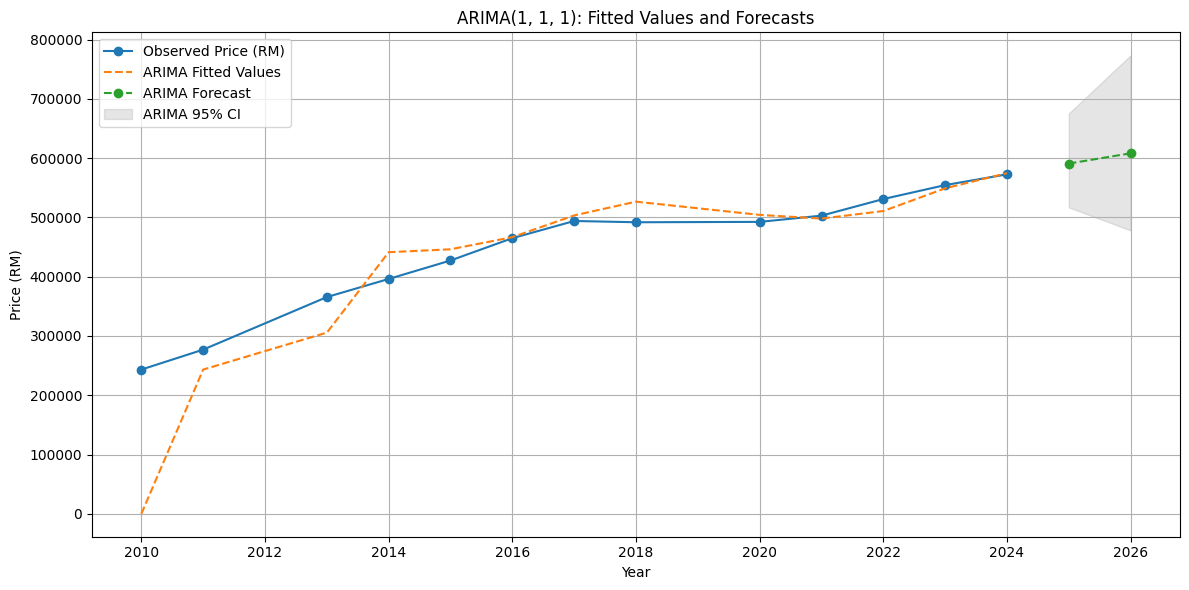

Results saved to 'mhpi_arima_model_results.txt', 'preprocessed_mhpi_data.csv', and 'mhpi_arima_forecast.csv'. Plot saved as 'mhpi_arima_model_plot.png'.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_squared_error
from io import StringIO # Import StringIO from io

# Load the annual dataset
data = """Year of Year,State,Type,Index Point,Price,Y-o-Y %
2010,Kuala Lumpur,High-rise,100,243284.085787671,10.375275938
2011,Kuala Lumpur,High-rise,113.171282974,276907.029001249,13.171282974
2012,Kuala Lumpur,High-rise,131.675,322187.18,16.350187557
2013,Kuala Lumpur,High-rise,149.425,365642.8475,13.480159484
2014,Kuala Lumpur,High-rise,161.9,396149.5925,8.348669901
2015,Kuala Lumpur,High-rise,174.625,427295.195,7.859789994
2016,Kuala Lumpur,High-rise,189.975,464907.0675,8.790264853
2017,Kuala Lumpur,High-rise,201.875,493950.74,6.263982103
2018,Kuala Lumpur,High-rise,200.975,491799.0225,-0.445820433
2019,Kuala Lumpur,High-rise,198.1,484802.06,-1.430526185
2020,Kuala Lumpur,High-rise,201.225,492431.795,1.577486118
2021,Kuala Lumpur,High-rise,205.55,502969.295,2.149335321
2022,Kuala Lumpur,High-rise,216.975,530954.265,5.563951970
2023,Kuala Lumpur,High-rise,226.575,554465.44,4.428097964
2024,Kuala Lumpur,High-rise,234,572633.985,3.277060576"""
df_hpi = pd.read_csv(StringIO(data))
df_hpi.rename(columns={'Year of Year': 'Year'}, inplace=True)
df_hpi['Year'] = pd.to_datetime(df_hpi['Year'], format='%Y')
df_hpi.set_index('Year', inplace=True)

# Outlier detection (Y-o-Y % outside 1st–99th percentiles)
yoy_lower, yoy_upper = df_hpi['Y-o-Y %'].quantile([0.01, 0.99])
df_hpi_clean = df_hpi[(df_hpi['Y-o-Y %'] >= yoy_lower) & (df_hpi['Y-o-Y %'] <= yoy_upper)]

# Log transformation
df_hpi_clean['LogPrice'] = np.log(df_hpi_clean ['Price'])

# ADF test for stationarity
adf_result = adfuller(df_hpi_clean['LogPrice'])
print("ADF Test for LogPrice:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Critical Values: {adf_result[4]}")

# Fit ARIMA model (try ARIMA(1,0,1), fallback to ARIMA(1,1,1) if non-stationary)
arima_order = (1, 0, 1)
if adf_result[1] > 0.05:  # Non-stationary if p-value > 0.05
    print("LogPrice is non-stationary (p-value > 0.05). Using ARIMA(1,1,1).")
    arima_order = (1, 1, 1)

try:
    arima_model = ARIMA(df_hpi_clean['LogPrice'], order=arima_order)
    arima_fit = arima_model.fit()
except Exception as e:
    print(f"Error fitting ARIMA{arima_order}: {e}. Trying ARIMA(1,1,1).")
    arima_order = (1, 1, 1)
    arima_model = ARIMA(df_hpi_clean['LogPrice'], order=arima_order)
    arima_fit = arima_model.fit()

# Get in-sample predictions (on original price scale)
arima_predictions = np.exp(arima_fit.fittedvalues)

# Calculate R² and RMSE
r2_arima = r2_score(df_hpi_clean ['Price'], arima_predictions)
rmse_arima = np.sqrt(mean_squared_error(df_hpi_clean['Price'], arima_predictions))

# Generate 2-year forecast
arima_forecast_object = arima_fit.get_forecast(steps=2)
arima_forecast = np.exp(arima_forecast_object.predicted_mean)
arima_conf_int = np.exp(arima_forecast_object.conf_int())

# Create forecast DataFrame
forecast_index = pd.date_range(start=df_hpi_clean .index[-1] + pd.offsets.YearEnd(1), periods=2, freq='YE')
forecast_df = pd.DataFrame({
    'Year': forecast_index,
    'ARIMA Forecast': arima_forecast.values,
    'ARIMA Lower CI': arima_conf_int.iloc[:, 0],
    'ARIMA Upper CI': arima_conf_int.iloc[:, 1]
})

# Print performance metrics
print("\nARIMA Performance (In-Sample):")
print(f"Order: {arima_order}")
print(f"R-squared (R²): {r2_arima:.4f}")
print(f"RMSE (RM): {rmse_arima:.2f}")

print("\nForecast for 2025–2026:")
print(forecast_df)

# Plot observed data, fitted values, and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df_hpi_clean .index, df_hpi_clean ['Price'], label='Observed Price (RM)', marker='o')
plt.plot(df_hpi_clean .index, arima_predictions, label='ARIMA Fitted Values', linestyle='--')
plt.plot(forecast_df['Year'], forecast_df['ARIMA Forecast'], label='ARIMA Forecast', linestyle='--', marker='o')
plt.fill_between(forecast_df['Year'], forecast_df['ARIMA Lower CI'], forecast_df['ARIMA Upper CI'], color='gray', alpha=0.2, label='ARIMA 95% CI')
plt.title(f'ARIMA{arima_order}: Fitted Values and Forecasts')
plt.xlabel('Year')
plt.ylabel('Price (RM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('mhpi_arima_model_plot.png')
plt.show()

# Save results
df_hpi_clean .to_csv('preprocessed_mhpi_data.csv')
with open('mhpi_arima_model_results.txt', 'w') as f:
    f.write("ARIMA Performance (In-Sample):\n")
    f.write(f"Order: {arima_order}\n")
    f.write(f"R-squared (R²): {r2_arima:.4f}\n")
    f.write(f"RMSE (RM): {rmse_arima:.2f}\n")
    f.write("\nForecast for 2025–2026:\n")
    f.write(str(forecast_df) + "\n")
forecast_df.to_csv('mhpi_arima_forecast.csv', index=False)
print("Results saved to 'mhpi_arima_model_results.txt', 'preprocessed_mhpi_data.csv', and 'mhpi_arima_forecast.csv'. Plot saved as 'mhpi_arima_model_plot.png'.")

In [70]:
# Print the ARIMA model summary
# Assuming arima_fit is available from a previous cell (e.g., 9UhnOWlg05Wc)
try:
    print(arima_fit.summary())
except NameError:
    print("Error: 'arima_fit' is not defined. Please make sure the cell that fits the ARIMA model has been run.")
except Exception as e:
    print(f"An error occurred while printing the ARIMA summary: {e}")

                               SARIMAX Results                                
Dep. Variable:               LogPrice   No. Observations:                   13
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  14.649
Date:                Thu, 23 Oct 2025   AIC                            -23.297
Time:                        04:07:21   BIC                            -21.843
Sample:                             0   HQIC                           -23.836
                                 - 13                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9226      0.207      4.462      0.000       0.517       1.328
ma.L1         -0.4246      0.614     -0.692      0.489      -1.627       0.778
sigma2         0.0046      0.003      1.805      0.0

In [72]:
# Calculate and print the variance of the forecast from the ARIMA model
# Assuming forecast is available from a previous cell (e.g., KDCCJJt-gz1-)
try:
    # Ensure forecast is a pandas Series or convert it to one if it's a numpy array
    if isinstance(forecast, np.ndarray):
        forecast_series = pd.Series(forecast)
    else:
        forecast_series = forecast

    print("Variance of ARIMA model forecast:", forecast_series.var())

except NameError:
    print("Error: 'forecast' is not defined. Please make sure the cell that generates the ARIMA forecast has been run.")
except Exception as e:
    print(f"An error occurred while calculating forecast variance: {e}")

Variance of ARIMA model forecast: 0.0004183812246676427


In [27]:
# import pickle
# import os
# from google.colab import drive

# # Mount Google Drive to save the model
# if not os.path.exists('/content/drive'):
#   drive.mount('/content/drive')
# else:
#   print("Drive already mounted")

# import numpy as np
# import pickle
# from sklearn.preprocessing import StandardScaler

# # Load the pre-trained model and scaler

# # Define the filename for the saved model (same as in cell 6Gvl-u9xVU2G)
# filename_model = '/content/drive/MyDrive/saved_models/random_forest_best_model.pkl'
# filename_scalar = '/content/drive/MyDrive/saved_models/scalar.pkl'

# try:
#     with open(filename_model, 'rb') as f1:
#         rf_model = pickle.load(f1)
#     with open(filename_scalar, 'rb') as f2:
#         scaler = pickle.load(f2)
#     print("Model and scaler loaded successfully!")
# except FileNotFoundError:
#     print("Error: rf_model.pkl or scaler.pkl not found. Please run the training script first.")
#     exit()

# Function to get prediction with user input


def get_prediction():

    # Ensure scheme_name_mapping_df is available or load it
    try:
        scheme_name_mapping_df
    except NameError:
        print("scheme_name_mapping_df not found. Attempting to load from file.")
        try:
            # Assuming the file was saved in a previous step
            scheme_name_mapping_df = pd.read_csv('/content/drive/MyDrive/saved_data/schemename_df.csv')
            print("scheme_name_mapping_df loaded successfully.")
        except FileNotFoundError:
            print("Error: schemename_df.csv not found. Cannot perform prediction.")
            return # Exit the function if mapping file is not found
        except Exception as e:
            print(f"An error occurred while loading scheme_name_mapping_df: {e}")
            return # Exit the function on other loading errors


    # Ensure rf_model and scaler are available or load them
    try:
        rf_model
        scaler
    except NameError:
        print("rf_model or scaler not found. Attempting to load from files.")
        try:
            # Assuming the models were saved in previous steps
            with open('/content/drive/MyDrive/saved_models/random_forest_best_model.pkl', 'rb') as f_model:
                rf_model = pickle.load(f_model)
            with open('/content/drive/MyDrive/saved_models/scaler.pkl', 'rb') as f_scaler:
                scaler = pickle.load(f_scaler)
            print("Model and scaler loaded successfully.")
        except FileNotFoundError:
            print("Error: Model or scaler file not found. Cannot perform prediction.")
            return # Exit the function if files are not found
        except Exception as e:
            print(f"An error occurred while loading model or scaler: {e}")
            return # Exit the function on other loading errors

    # Define get_encoded_scheme_mean function inside get_prediction
    def get_encoded_scheme_mean(scheme_name_mapping_df, scheme_name):
        """
        Checks if a scheme name exists in the mapping DataFrame and returns its encoded mean.

        Args:
            scheme_name_mapping_df (pd.DataFrame): DataFrame with 'SchemeName' and 'SchemeName_encoded_Mean' columns.
            scheme_name (str): The scheme name to look up.

        Returns:
            float or None: The encoded mean if the scheme name is found, otherwise None.
        """
        # Check if the scheme name exists in the 'SchemeName' column
        if scheme_name in scheme_name_mapping_df['SchemeName'].values:
            # Get the row where the scheme name matches
            encoded_mean = scheme_name_mapping_df[scheme_name_mapping_df['SchemeName'] == scheme_name]['SchemeName_encoded_Mean'].iloc[0]
            return encoded_mean
        else:
            print(f"Scheme name '{scheme_name}' not found in the mapping. Using default value.")
            return 10 # Return default value as indicated in the calling code


    print("\nEnter the following features for prediction:")

    # Get and validate inputs
    while True:
        try:
            parcel_area = float(input("Parcel Area (sq ft, positive number): "))
            if parcel_area <= 0:
                print("Error: Parcel Area must be positive.")
                continue
            break
        except ValueError:
            print("Error: Please enter a valid number for Parcel Area.")

    while True:
        try:
            level_numeric = float(input("Level (numeric, e.g., 1-50, positive number): "))
            if level_numeric <= 0 or level_numeric > 50:
                print("Error: Level must be between 1 and 50.")
                continue
            break
        except ValueError:
            print("Error: Please enter a valid number for Level.")

    while True:
        try:
            tenure_encoded = int(input("Tenure (0 for Leasehold, 1 for Freehold): "))
            if tenure_encoded not in [0, 1]:
                print("Error: Tenure must be 0 or 1.")
                continue
            break
        except ValueError:
            print("Error: Please enter 0 or 1 for Tenure.")

    scheme_name = input("Scheme Name: ").strip()
    scheme_encoded = get_encoded_scheme_mean(scheme_name_mapping_df, scheme_name)


    # Calculate derived features
    parcel_area_sq = parcel_area ** 2
    parcel_area_level = parcel_area * level_numeric
    # ['ParcelArea', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded', 'ParcelArea_sq', 'ParcelArea_Level']
    input_data = np.array([[parcel_area, tenure_encoded, level_numeric, scheme_encoded, parcel_area_sq, parcel_area_level]])

    # Scale the input
    input_scaled = scaler.transform(input_data)

    # Predict in log space and convert to MYR
    log_prediction = rf_model.predict(input_scaled)[0]
    prediction_myr = np.exp(log_prediction)

    print(f"\nPredicted Price: {prediction_myr:.2f} MYR")

    # Ensure df, X, y are available from previous cells for ARIMA part
    try:
        df
        X
        y
    except NameError:
        print("df, X, or y not found. Skipping ARIMA part.")
        return # Exit the function if data is not available


    recent_years = df.loc[X.index].groupby(df['TransactionDate'].dt.year).tail(1).sort_values('TransactionDate')
    recent_X = X.loc[recent_years.index]
    recent_y = y.loc[recent_years.index]
    recent_X_scaled = scaler.transform(recent_X)
    rf_pred_recent = np.exp(np.clip(rf_model.predict(recent_X_scaled), -709, 709)) # Increased clipping limit
    hybrid_series = pd.Series(rf_pred_recent, index=recent_years['TransactionDate'].dt.year)
    hybrid_series = pd.concat([hybrid_series, pd.Series([prediction_myr], index=[df['TransactionDate'].dt.year.max() + 1])])

    print("\nHybrid Series before ARIMA:")
    print(hybrid_series)

    # Fit ARIMA(1,1,1) model
    try:
        from statsmodels.tsa.arima.model import ARIMA
        arima_model = ARIMA(hybrid_series, order=(1, 1, 1))
        arima_fit = arima_model.fit()
        print("\nARIMA(1,1,1) model fitted successfully!")

        # Forecast the next 2 years
        forecast = arima_fit.forecast(steps=2)
        forecast_years = [hybrid_series.index[-1] + 1, hybrid_series.index[-1] + 2]
        forecast_series = pd.Series(forecast, index=forecast_years)

        print("\nARIMA Forecast for the next 2 years:")
        for year, price in forecast_series.items():
            print(f"Year {year}: {price:.2f} MYR")

    except Exception as e:
        print(f"Error fitting ARIMA model: {e}")

# Run prediction
if __name__ == "__main__":
    get_prediction()

scheme_name_mapping_df not found. Attempting to load from file.
scheme_name_mapping_df loaded successfully.
rf_model or scaler not found. Attempting to load from files.
Model and scaler loaded successfully.

Enter the following features for prediction:
Parcel Area (sq ft, positive number): 100
Level (numeric, e.g., 1-50, positive number): 10
Tenure (0 for Leasehold, 1 for Freehold): 1
Scheme Name: SRI PUTRAMAS

Predicted Price: 593820.80 MYR

Hybrid Series before ARIMA:
2021    495469.416598
2022    503896.059989
2023    733959.693453
2024    415751.638984
2025    323281.480163
2026    593820.795446
dtype: float64
Error fitting ARIMA model: LU decomposition error.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a re

In [ ]:
# import pickle
# import os
# from google.colab import drive

# # Mount Google Drive to save the model
# if not os.path.exists('/content/drive'):
#   drive.mount('/content/drive')
# else:
#   print("Drive already mounted")

# import numpy as np
# import pickle
# from sklearn.preprocessing import StandardScaler

# # Load the pre-trained model and scaler

# # Define the filename for the saved model (same as in cell 6Gvl-u9xVU2G)
# filename_model = '/content/drive/MyDrive/saved_models/random_forest_best_model.pkl'
# filename_scalar = '/content/drive/MyDrive/saved_models/scalar.pkl'

# try:
#     with open(filename_model, 'rb') as f1:
#         rf_model = pickle.load(f1)
#     with open(filename_scalar, 'rb') as f2:
#         scaler = pickle.load(f2)
#     print("Model and scaler loaded successfully!")
# except FileNotFoundError:
#     print("Error: rf_model.pkl or scaler.pkl not found. Please run the training script first.")
#     exit()

# Function to get prediction with user input


def get_prediction():
    print("\nEnter the following features for prediction:")

    # Get and validate inputs
    while True:
        try:
            parcel_area = float(input("Parcel Area (sq ft, positive number): "))
            if parcel_area <= 0:
                print("Error: Parcel Area must be positive.")
                continue
            break
        except ValueError:
            print("Error: Please enter a valid number for Parcel Area.")

    while True:
        try:
            level_numeric = float(input("Level (numeric, e.g., 1-50, positive number): "))
            if level_numeric <= 0 or level_numeric > 50:
                print("Error: Level must be between 1 and 50.")
                continue
            break
        except ValueError:
            print("Error: Please enter a valid number for Level.")

    while True:
        try:
            tenure_encoded = int(input("Tenure (0 for Leasehold, 1 for Freehold): "))
            if tenure_encoded not in [0, 1]:
                print("Error: Tenure must be 0 or 1.")
                continue
            break
        except ValueError:
            print("Error: Please enter 0 or 1 for Tenure.")

    scheme_name = input("Scheme Name: ").strip()
    scheme_encoded = 10  # Default value if not found

    scheme_encoded = get_encoded_scheme_mean(scheme_name_mapping_df, scheme_name)


    # Calculate derived features
    parcel_area_sq = parcel_area ** 2
    parcel_area_level = parcel_area * level_numeric
    # ['ParcelArea', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded', 'ParcelArea_sq', 'ParcelArea_Level']
    input_data = np.array([[parcel_area, tenure_encoded, level_numeric, scheme_encoded, parcel_area_sq, parcel_area_level]])

    # Scale the input
    input_scaled = scaler.transform(input_data)

    # Predict in log space and convert to MYR
    log_prediction = rf_model.predict(input_scaled)[0]
    prediction_myr = np.exp(log_prediction)

    print(f"\nPredicted Price: {prediction_myr:.2f} MYR")

    recent_years = df.loc[X.index].groupby(df['TransactionDate'].dt.year).tail(1).sort_values('TransactionDate')
    recent_X = X.loc[recent_years.index]
    recent_y = y.loc[recent_years.index]
    recent_X_scaled = scaler.transform(recent_X)
    rf_pred_recent = np.exp(np.clip(rf_model.predict(recent_X_scaled), -709, 709)) # Increased clipping limit
    hybrid_series = pd.Series(rf_pred_recent, index=recent_years['TransactionDate'].dt.year)
    hybrid_series = pd.concat([hybrid_series, pd.Series([prediction_myr], index=[df['TransactionDate'].dt.year.max() + 1])])

    print("\nHybrid Series before ARIMA:")
    print(hybrid_series)

    # Fit ARIMA(1,1,1) model
    try:
        arima_model = ARIMA(hybrid_series, order=(1, 1, 1))
        arima_fit = arima_model.fit()
        print("\nARIMA(1,1,1) model fitted successfully!")

        # Forecast the next 2 years
        forecast = arima_fit.forecast(steps=2)
        forecast_years = [hybrid_series.index[-1] + 1, hybrid_series.index[-1] + 2]
        forecast_series = pd.Series(forecast, index=forecast_years)

        print("\nARIMA Forecast for the next 2 years:")
        for year, price in forecast_series.items():
            print(f"Year {year}: {price:.2f} MYR")

    except Exception as e:
        print(f"Error fitting ARIMA model: {e}")

# Run prediction
if __name__ == "__main__":
    get_prediction()

ARIMA

/tmp/ipython-input-683658779.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['LogPrice'] = np.log(df_clean['Price'])
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, 

ADF Test for LogPrice:
ADF Statistic: -0.9606
p-value: 0.7674
Critical Values: {'1%': np.float64(-4.331573), '5%': np.float64(-3.23295), '10%': np.float64(-2.7487)}
LogPrice is non-stationary (p-value > 0.05). Using ARIMA(1,1,1).


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



ARIMA Performance (In-Sample):
Order: (1, 1, 1)
R-squared (R²): 0.4505
RMSE (RM): 72438.79

Forecast for 2025–2026:
         Year  ARIMA Forecast  ARIMA Lower CI  ARIMA Upper CI
13 2024-12-31   590812.747597   516935.436661   675248.160540
14 2025-12-31   608095.855696   478059.705593   773502.902228


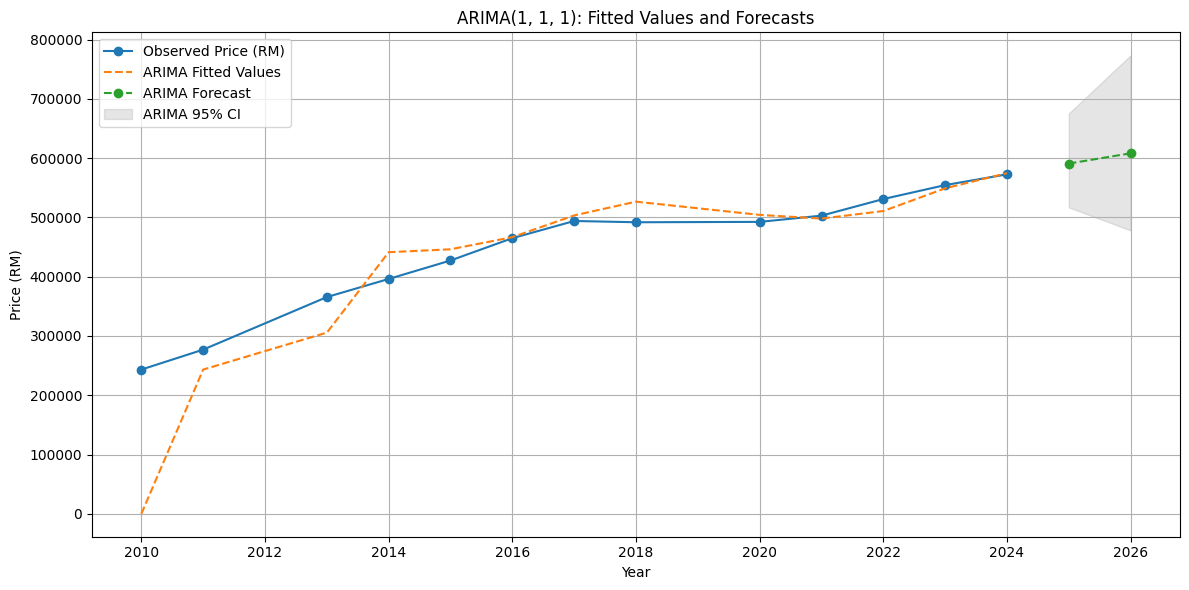

Results saved to 'mhpi_arima_model_results.txt', 'preprocessed_mhpi_data.csv', and 'mhpi_arima_forecast.csv'. Plot saved as 'mhpi_arima_model_plot.png'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_squared_error
from io import StringIO # Import StringIO from io

# Load the annual dataset
data = """Year of Year,State,Type,Index Point,Price,Y-o-Y %
2010,Kuala Lumpur,High-rise,100,243284.085787671,10.375275938
2011,Kuala Lumpur,High-rise,113.171282974,276907.029001249,13.171282974
2012,Kuala Lumpur,High-rise,131.675,322187.18,16.350187557
2013,Kuala Lumpur,High-rise,149.425,365642.8475,13.480159484
2014,Kuala Lumpur,High-rise,161.9,396149.5925,8.348669901
2015,Kuala Lumpur,High-rise,174.625,427295.195,7.859789994
2016,Kuala Lumpur,High-rise,189.975,464907.0675,8.790264853
2017,Kuala Lumpur,High-rise,201.875,493950.74,6.263982103
2018,Kuala Lumpur,High-rise,200.975,491799.0225,-0.445820433
2019,Kuala Lumpur,High-rise,198.1,484802.06,-1.430526185
2020,Kuala Lumpur,High-rise,201.225,492431.795,1.577486118
2021,Kuala Lumpur,High-rise,205.55,502969.295,2.149335321
2022,Kuala Lumpur,High-rise,216.975,530954.265,5.563951970
2023,Kuala Lumpur,High-rise,226.575,554465.44,4.428097964
2024,Kuala Lumpur,High-rise,234,572633.985,3.277060576"""
df = pd.read_csv(StringIO(data))
df.rename(columns={'Year of Year': 'Year'}, inplace=True)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# Outlier detection (Y-o-Y % outside 1st–99th percentiles)
yoy_lower, yoy_upper = df['Y-o-Y %'].quantile([0.01, 0.99])
df_clean = df[(df['Y-o-Y %'] >= yoy_lower) & (df['Y-o-Y %'] <= yoy_upper)]

# Log transformation
df_clean['LogPrice'] = np.log(df_clean['Price'])

# ADF test for stationarity
adf_result = adfuller(df_clean['LogPrice'])
print("ADF Test for LogPrice:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Critical Values: {adf_result[4]}")

# Fit ARIMA model (try ARIMA(1,0,1), fallback to ARIMA(1,1,1) if non-stationary)
arima_order = (1, 0, 1)
if adf_result[1] > 0.05:  # Non-stationary if p-value > 0.05
    print("LogPrice is non-stationary (p-value > 0.05). Using ARIMA(1,1,1).")
    arima_order = (1, 1, 1)

try:
    arima_model = ARIMA(df_clean['LogPrice'], order=arima_order)
    arima_fit = arima_model.fit()
except Exception as e:
    print(f"Error fitting ARIMA{arima_order}: {e}. Trying ARIMA(1,1,1).")
    arima_order = (1, 1, 1)
    arima_model = ARIMA(df_clean['LogPrice'], order=arima_order)
    arima_fit = arima_model.fit()

# Get in-sample predictions (on original price scale)
arima_predictions = np.exp(arima_fit.fittedvalues)

# Calculate R² and RMSE
r2_arima = r2_score(df_clean['Price'], arima_predictions)
rmse_arima = np.sqrt(mean_squared_error(df_clean['Price'], arima_predictions))

# Generate 2-year forecast
arima_forecast_object = arima_fit.get_forecast(steps=2)
arima_forecast = np.exp(arima_forecast_object.predicted_mean)
arima_conf_int = np.exp(arima_forecast_object.conf_int())

# Create forecast DataFrame
forecast_index = pd.date_range(start=df_clean.index[-1] + pd.offsets.YearEnd(1), periods=2, freq='YE')
forecast_df = pd.DataFrame({
    'Year': forecast_index,
    'ARIMA Forecast': arima_forecast.values,
    'ARIMA Lower CI': arima_conf_int.iloc[:, 0],
    'ARIMA Upper CI': arima_conf_int.iloc[:, 1]
})

# Print performance metrics
print("\nARIMA Performance (In-Sample):")
print(f"Order: {arima_order}")
print(f"R-squared (R²): {r2_arima:.4f}")
print(f"RMSE (RM): {rmse_arima:.2f}")

print("\nForecast for 2025–2026:")
print(forecast_df)

# Plot observed data, fitted values, and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean['Price'], label='Observed Price (RM)', marker='o')
plt.plot(df_clean.index, arima_predictions, label='ARIMA Fitted Values', linestyle='--')
plt.plot(forecast_df['Year'], forecast_df['ARIMA Forecast'], label='ARIMA Forecast', linestyle='--', marker='o')
plt.fill_between(forecast_df['Year'], forecast_df['ARIMA Lower CI'], forecast_df['ARIMA Upper CI'], color='gray', alpha=0.2, label='ARIMA 95% CI')
plt.title(f'ARIMA{arima_order}: Fitted Values and Forecasts')
plt.xlabel('Year')
plt.ylabel('Price (RM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('mhpi_arima_model_plot.png')
plt.show()

# Save results
df_clean.to_csv('preprocessed_mhpi_data.csv')
with open('mhpi_arima_model_results.txt', 'w') as f:
    f.write("ARIMA Performance (In-Sample):\n")
    f.write(f"Order: {arima_order}\n")
    f.write(f"R-squared (R²): {r2_arima:.4f}\n")
    f.write(f"RMSE (RM): {rmse_arima:.2f}\n")
    f.write("\nForecast for 2025–2026:\n")
    f.write(str(forecast_df) + "\n")
forecast_df.to_csv('mhpi_arima_forecast.csv', index=False)
print("Results saved to 'mhpi_arima_model_results.txt', 'preprocessed_mhpi_data.csv', and 'mhpi_arima_forecast.csv'. Plot saved as 'mhpi_arima_model_plot.png'.")

✅ Data loaded successfully!

Historical Prices:
                Price  Y-o-Y %
Year                          
2010-01-01  243284.09    10.38
2011-01-01  276907.03    13.17
2012-01-01  322187.18    16.35
2013-01-01  365642.85    13.48
2014-01-01  396149.59     8.35
2015-01-01  427295.20     7.86
2016-01-01  464907.07     8.79
2017-01-01  493950.74     6.26
2018-01-01  491799.02    -0.45
2019-01-01  484802.06    -1.43
2020-01-01  492431.80     1.58
2021-01-01  502969.30     2.15
2022-01-01  530954.26     5.56
2023-01-01  554465.44     4.43
2024-01-01  572633.98     3.28

=== STATIONARITY TEST ===
{'ADF Statistic': -2.270373685140338, 'p-value': 0.1817011150698431, 'Stationary': np.False_}

=== ARIMA(1,1,1) PERFORMANCE ===
In-Sample R²:    0.5637
In-Sample RMSE:  RM 63963
LOOCV R²:        0.9382
LOOCV RMSE:      RM 14502

=== 2025-2026 FORECAST ===
 Year  Forecast_Price_RM  Lower_95_CI  Upper_95_CI  Growth_%
 2024             583492       561026       605958  1.896123
 2025             59

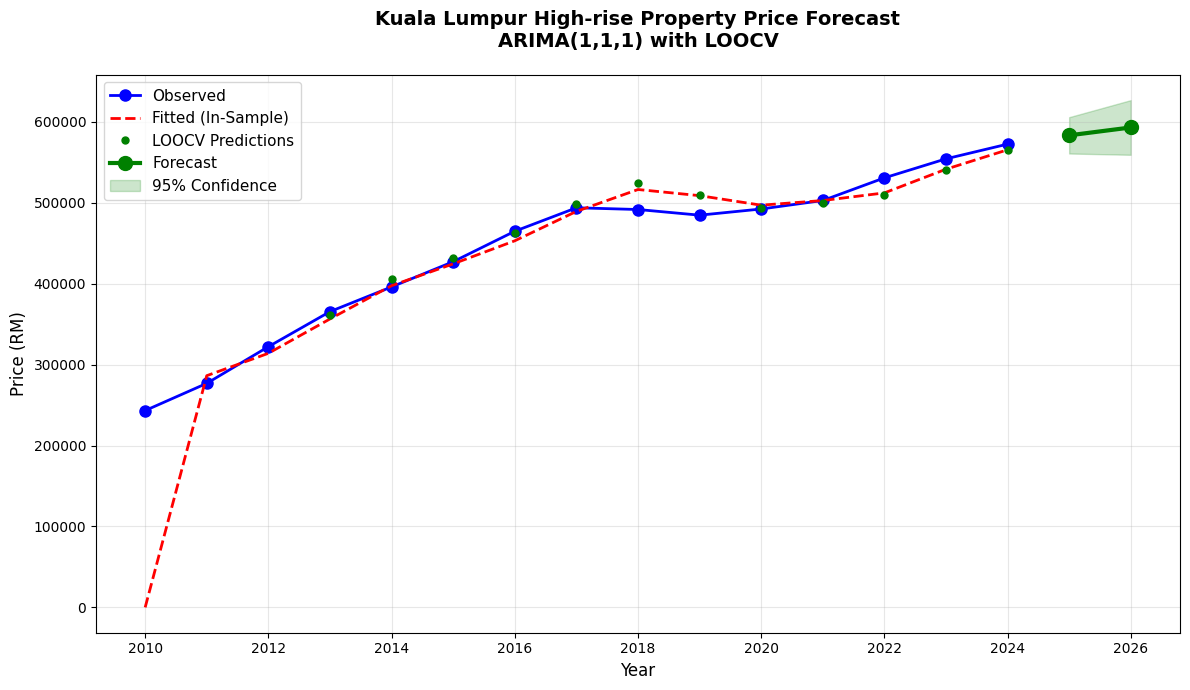


✅ Files saved:
   • mhpi_forecast_final.csv
   • mhpi_results_summary.txt
   • mhpi_forecast_final.png


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from io import StringIO
import warnings
warnings.filterwarnings("ignore")

# DATA LOADING
data = """Year of Year,State,Type,Index Point,Price,Y-o-Y %
2010,Kuala Lumpur,High-rise,100,243284.085787671,10.375275938
2011,Kuala Lumpur,High-rise,113.171282974,276907.029001249,13.171282974
2012,Kuala Lumpur,High-rise,131.675,322187.18,16.350187557
2013,Kuala Lumpur,High-rise,149.425,365642.8475,13.480159484
2014,Kuala Lumpur,High-rise,161.9,396149.5925,8.348669901
2015,Kuala Lumpur,High-rise,174.625,427295.195,7.859789994
2016,Kuala Lumpur,High-rise,189.975,464907.0675,8.790264853
2017,Kuala Lumpur,High-rise,201.875,493950.74,6.263982103
2018,Kuala Lumpur,High-rise,200.975,491799.0225,-0.445820433
2019,Kuala Lumpur,High-rise,198.1,484802.06,-1.430526185
2020,Kuala Lumpur,High-rise,201.225,492431.795,1.577486118
2021,Kuala Lumpur,High-rise,205.55,502969.295,2.149335321
2022,Kuala Lumpur,High-rise,216.975,530954.265,5.563951970
2023,Kuala Lumpur,High-rise,226.575,554465.4400,4.428097964
2024,Kuala Lumpur,High-rise,234,572633.9850,3.277060576"""

df = pd.read_csv(StringIO(data))
df.rename(columns={'Year of Year': 'Year'}, inplace=True)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

print("✅ Data loaded successfully!")
print("\nHistorical Prices:")
print(df[['Price', 'Y-o-Y %']].round(2))

# STATIONARITY TEST (FIXED)
def stationarity_test(series):
    result = adfuller(series.dropna())
    return {
        'ADF Statistic': float(result[0]),
        'p-value': float(result[1]),
        'Stationary': result[1] <= 0.05
    }

print("\n=== STATIONARITY TEST ===")
print(stationarity_test(df['Price']))

# MAIN ARIMA MODEL
model = ARIMA(df['Price'], order=(1, 1, 1))
model_fit = model.fit()

# FIXED LOOCV - USING POSITIONAL INDEXING AND STARTING LOOP FROM 3
loocv_predictions = []
prices_list = df['Price'].values  # Convert to numpy array - NO INDEX ISSUES!
loocv_true_prices = []

for i in range(3, len(prices_list)): # Start loop from index 3 (4th data point)
    # Train on data up to index i-1
    train_data = prices_list[:i]

    # Fit model
    temp_model = ARIMA(train_data, order=(1, 1, 1))
    temp_fit = temp_model.fit()

    # Predict next value (index i)
    pred = temp_fit.forecast(steps=1)[0]
    loocv_predictions.append(pred)
    loocv_true_prices.append(prices_list[i])

# PERFORMANCE METRICS
true_prices = np.array(loocv_true_prices)
loocv_pred_array = np.array(loocv_predictions)

r2_loocv = r2_score(true_prices, loocv_pred_array)
rmse_loocv = np.sqrt(mean_squared_error(true_prices, loocv_pred_array))

r2_insample = r2_score(df['Price'], model_fit.fittedvalues)
rmse_insample = np.sqrt(mean_squared_error(df['Price'], model_fit.fittedvalues))

print(f"\n=== ARIMA(1,1,1) PERFORMANCE ===")
print(f"In-Sample R²:    {r2_insample:.4f}")
print(f"In-Sample RMSE:  RM {rmse_insample:.0f}")
print(f"LOOCV R²:        {r2_loocv:.4f}")
print(f"LOOCV RMSE:      RM {rmse_loocv:.0f}")

# FORECAST 2025-2026 WITH CONFIDENCE INTERVALS
forecast_steps = 2
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Calculate future index based on the last date in the original dataframe
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.YearEnd(1), periods=forecast_steps, freq='YE')

last_price = df['Price'].iloc[-1]

# RESULTS TABLE
# Calculate growth rates from the last observed price (2024) and then year-over-year for forecast
growth_2025 = ((forecast_mean.iloc[0] / last_price) - 1) * 100
growth_2026 = ((forecast_mean.iloc[1] / forecast_mean.iloc[0]) - 1) * 100


results_df = pd.DataFrame({
    'Year': future_index.year,
    'Forecast_Price_RM': forecast_mean.round(0).astype(int),
    'Lower_95_CI': forecast_ci.iloc[:, 0].round(0).astype(int),
    'Upper_95_CI': forecast_ci.iloc[:, 1].round(0).astype(int),
    'Growth_%': [growth_2025, growth_2026]
})

print(f"\n=== 2025-2026 FORECAST ===")
print(results_df.to_string(index=False))

# PROFESSIONAL PLOT
plt.figure(figsize=(12, 7))
plt.plot(df.index, df['Price'], 'bo-', linewidth=2, markersize=8, label='Observed')
plt.plot(df.index, model_fit.fittedvalues, 'r--', linewidth=2, label='Fitted (In-Sample)') # Label fitted values
plt.plot(df.index[3:], loocv_pred_array, 'go', markersize=5, label='LOOCV Predictions') # Plot LOOCV predictions

plt.plot(future_index, forecast_mean, 'g-o', linewidth=3, markersize=10, label='Forecast')
plt.fill_between(future_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                color='green', alpha=0.2, label='95% Confidence')

plt.title('Kuala Lumpur High-rise Property Price Forecast\nARIMA(1,1,1) with LOOCV',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (RM)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mhpi_forecast_final.png', dpi=300, bbox_inches='tight')
plt.show()

# SAVE RESULTS
results_df.to_csv('mhpi_forecast_final.csv', index=False)
with open('mhpi_results_summary.txt', 'w') as f:
    f.write("ARIMA(1,1,1) Kuala Lumpur High-rise Property Forecast\n")
    f.write("="*50 + "\n\n")
    f.write(f"In-Sample R²: {r2_insample:.4f}\n") # Include in-sample metrics
    f.write(f"In-Sample RMSE: RM {rmse_insample:.0f}\n")
    f.write(f"LOOCV R²: {r2_loocv:.4f}\n")
    f.write(f"LOOCV RMSE: RM {rmse_loocv:.0f}\n\n")
    f.write("FORECAST RESULTS:\n")
    f.write(results_df.to_string(index=False))

print("\n✅ Files saved:")
print("   • mhpi_forecast_final.csv")
print("   • mhpi_results_summary.txt")
print("   • mhpi_forecast_final.png")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_squared_error
from io import StringIO # Import StringIO from io
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Install statsmodels
def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--upgrade"])
        print(f"Successfully installed {package}")
    except Exception as e:
        print(f"Error installing {package}: {e}")

install_package("statsmodels")

# Load the annual dataset
data = """Year of Year,State,Type,Index Point,Price,Y-o-Y %
2010,Kuala Lumpur,High-rise,100,243284.085787671,10.375275938
2011,Kuala Lumpur,High-rise,113.171282974,276907.029001249,13.171282974
2012,Kuala Lumpur,High-rise,131.675,322187.18,16.350187557
2013,Kuala Lumpur,High-rise,149.425,365642.8475,13.480159484
2014,Kuala Lumpur,High-rise,161.9,396149.5925,8.348669901
2015,Kuala Lumpur,High-rise,174.625,427295.195,7.859789994
2016,Kuala Lumpur,High-rise,189.975,464907.0675,8.790264853
2017,Kuala Lumpur,High-rise,201.875,493950.74,6.263982103
2018,Kuala Lumpur,High-rise,200.975,491799.0225,-0.445820433
2019,Kuala Lumpur,High-rise,198.1,484802.06,-1.430526185
2020,Kuala Lumpur,High-rise,201.225,492431.795,1.577486118
2021,Kuala Lumpur,High-rise,205.55,502969.295,2.149335321
2022,Kuala Lumpur,High-rise,216.975,530954.265,5.563951970
2023,Kuala Lumpur,High-rise,226.575,554465.44,4.428097964
2024,Kuala Lumpur,High-rise,234,572633.985,3.277060576"""
df = pd.read_csv(StringIO(data))
df.rename(columns={'Year of Year': 'Year'}, inplace=True)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# No outlier detection to retain all 15 points
df_clean = df.copy()

# Log transformation
df_clean.loc[:, 'LogPrice'] = np.log(df_clean['Price'])

# Stationarity test
def stationarity_test(series):
    result = adfuller(series.dropna())
    return {
        'ADF Statistic': float(result[0]),
        'p-value': float(result[1]),
        'Stationary': result[1] <= 0.05
    }

print("✅ Data loaded successfully!")
print("\nHistorical Prices:")
print(df_clean[['Price', 'Y-o-Y %']].round(2))
print("\n=== STATIONARITY TEST ===")
print(stationarity_test(df_clean['Price']))

# LOOCV for ARIMA(1,1,1)
loocv_predictions = []
loocv_true_prices = []
min_train_size = 3

for i in range(1, len(df_clean)):  # Start from 2011
    train_indices = df_clean.index[:i]
    if len(train_indices) < min_train_size:
        continue
    test_index = df_clean.index[i]
    train_data = df_clean.loc[train_indices, 'LogPrice']
    test_price = df_clean['Price'].loc[test_index]
    last_train_price = df_clean['Price'].loc[train_indices[-1]]

    try:
        model = ARIMA(train_data, order=(1, 1, 1))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)[0]
        pred_price = np.exp(np.clip(pred, np.log(1e-5), 20))
        if not np.isnan(pred_price) and pred_price > 0:
            loocv_predictions.append(pred_price)
            loocv_true_prices.append(test_price)
        else:
            print(f"Warning: Invalid prediction ({pred_price}) for fold {test_index.year}, using last training price")
            loocv_predictions.append(last_train_price)
            loocv_true_prices.append(test_price)
    except Exception as e:
        print(f"Warning: ARIMA failed for fold {test_index.year}. Error: {e}")
        loocv_predictions.append(last_train_price)
        loocv_true_prices.append(test_price)

# Calculate LOOCV metrics
r2_loocv = r2_score(loocv_true_prices, loocv_predictions)
rmse_loocv = np.sqrt(mean_squared_error(loocv_true_prices, loocv_predictions))

# Fit ARIMA(1,1,1) on full data
try:
    model = ARIMA(df_clean['LogPrice'], order=(1, 1, 1))
    model_fit = model.fit()
    fitted_log_prices = model_fit.fittedvalues
    fitted_prices = np.exp(np.clip(fitted_log_prices, np.log(1e-5), 20))
    r2_insample = r2_score(df_clean['Price'].iloc[1:], fitted_prices[1:])
    rmse_insample = np.sqrt(mean_squared_error(df_clean['Price'].iloc[1:], fitted_prices[1:]))
except Exception as e:
    print(f"Warning: ARIMA fitting failed on full data. Error: {e}")
    r2_insample, rmse_insample = np.nan, np.nan
    fitted_prices = np.full_like(df_clean['Price'], np.nan)

# Generate 2-year forecast
arima_forecast_object = model_fit.get_forecast(steps=2)
arima_forecast_mean = arima_forecast_object.predicted_mean
arima_conf_int = arima_forecast_object.conf_int()

# Apply clipping before exponentiating forecast and confidence intervals
arima_forecast_prices = np.exp(np.clip(arima_forecast_mean, np.log(1e-5), 20))
arima_lower_ci = np.exp(np.clip(arima_conf_int.iloc[:, 0], np.log(1e-5), 20))
arima_upper_ci = np.exp(np.clip(arima_conf_int.iloc[:, 1], np.log(1e-5), 20))

# Create forecast DataFrame with correct years (2025 and 2026)
forecast_years = [df_clean.index[-1].year + 1, df_clean.index[-1].year + 2]
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'ARIMA Forecast': arima_forecast_prices.round(0).astype(int),
    'ARIMA Lower CI': arima_lower_ci.round(0).astype(int),
    'ARIMA Upper CI': arima_upper_ci.round(0).astype(int)
})


# Calculate growth rates
last_price = df_clean['Price'].iloc[-1]
try:
    growth_2025 = ((forecast_df['ARIMA Forecast'].iloc[0] / last_price) - 1) * 100
    growth_2026 = ((forecast_df['ARIMA Forecast'].iloc[1] / forecast_df['ARIMA Forecast'].iloc[0]) - 1) * 100
except Exception:
    growth_2025, growth_2026 = np.nan, np.nan # Set to NaN if forecast is NaN
forecast_df['Growth_%'] = [growth_2025, growth_2026]


# Print performance metrics
print("\nARIMA Performance (In-Sample):")
print(f"Order: {arima_order}")
print(f"R-squared (R²): {r2_insample:.4f}")
print(f"RMSE (RM): {rmse_insample:.2f}")
print("\nARIMA LOOCV Performance:")
print(f"R-squared (R²): {r2_loocv:.4f}")
print(f"RMSE (RM): {rmse_loocv:.2f}")

print("\nForecast for 2025–2026:")
print(forecast_df.to_string(index=False))

# Plot observed data, fitted values, and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean['Price'], label='Observed Price (RM)', marker='o')
plt.plot(df_clean.index[1:], fitted_prices[1:], label='ARIMA Fitted Values (In-Sample)', linestyle='--') # Corrected index for fitted values

# Create time index for LOOCV predictions
loocv_index = df_clean.index[len(df_clean) - len(loocv_predictions):]
plt.plot(loocv_index, loocv_predictions, 'go', markersize=5, label='LOOCV Predictions') # Plot LOOCV predictions

# Use the index from the ARIMA forecast object for plotting
arima_forecast_plot_index = arima_forecast_mean.index
plt.plot(arima_forecast_plot_index, arima_forecast_prices, label='ARIMA Forecast', linestyle='--', marker='o')
plt.fill_between(arima_forecast_plot_index, arima_lower_ci, arima_upper_ci, color='gray', alpha=0.2, label='ARIMA 95% CI')


plt.title(f'ARIMA{arima_order}: Fitted Values, LOOCV, and Forecasts')
plt.xlabel('Year')
plt.ylabel('Price (RM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('mhpi_arima_model_plot.png')
plt.show()

# Save results
df_clean.to_csv('preprocessed_mhpi_data.csv')
with open('mhpi_arima_model_results.txt', 'w') as f:
    f.write("ARIMA Performance (In-Sample):\n")
    f.write(f"Order: {arima_order}\n")
    f.write(f"R-squared (R²): {r2_insample:.4f}\n")
    f.write(f"RMSE (RM): {rmse_insample:.2f}\n")
    f.write("\nARIMA LOOCV Performance:\n")
    f.write(f"R-squared (R²): {r2_loocv:.4f}\n")
    f.write(f"RMSE (RM): {rmse_loocv:.2f}\n")
    f.write("\nForecast for 2025–2026:\n")
    f.write(str(forecast_df.to_string(index=False)) + "\n") # Save as string without index
forecast_df.to_csv('mhpi_arima_forecast.csv', index=False)
print("Results saved to 'mhpi_arima_model_results.txt', 'preprocessed_mhpi_data.csv', and 'mhpi_arima_forecast.csv'. Plot saved as 'mhpi_arima_model_plot.png'.")

Error installing statsmodels: name 'subprocess' is not defined
✅ Data loaded successfully!

Historical Prices:
                Price  Y-o-Y %
Year                          
2010-01-01  243284.09    10.38
2011-01-01  276907.03    13.17
2012-01-01  322187.18    16.35
2013-01-01  365642.85    13.48
2014-01-01  396149.59     8.35
2015-01-01  427295.20     7.86
2016-01-01  464907.07     8.79
2017-01-01  493950.74     6.26
2018-01-01  491799.02    -0.45
2019-01-01  484802.06    -1.43
2020-01-01  492431.80     1.58
2021-01-01  502969.30     2.15
2022-01-01  530954.26     5.56
2023-01-01  554465.44     4.43
2024-01-01  572633.98     3.28

=== STATIONARITY TEST ===
{'ADF Statistic': -2.270373685140338, 'p-value': 0.1817011150698431, 'Stationary': np.False_}

ARIMA Performance (In-Sample):


NameError: name 'arima_order' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Calculate 5-fold cross-validation scores for the Random Forest model
# Use negative mean squared error for RMSE and r2 for R-squared
cv_mse_scores = -cross_val_score(rf_best, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='r2')

# Calculate the average CV RMSE and R2
cv_rmse_mean = np.sqrt(cv_mse_scores.mean())
cv_r2_mean = cv_r2_scores.mean()

# Print the average CV RMSE and R2
print("Random Forest Cross-Validation Results:")
print(f"Average CV RMSE: {cv_rmse_mean:.4f}")
print(f"Average CV R2: {cv_r2_mean:.4f}")

Random Forest Cross-Validation Results:
Average CV RMSE: 0.1102
Average CV R2: 0.9729


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# y_test and y_pred_rf_best are assumed to be available from previous cells (e.g., mb7YTfUhQcpm or JVNnca-wRc6j)

# Exponentiate the actual and predicted values back to the original scale
y_test_orig = np.exp(y_test)
y_pred_rf_best_orig = np.exp(y_pred_rf_best)

# Calculate the Mean Squared Error in the original scale
mse_rf_best_orig = mean_squared_error(y_test_orig, y_pred_rf_best_orig)

# Calculate the Root Mean Squared Error in the original scale (MYR)
rmse_rf_best_orig = np.sqrt(mse_rf_best_orig)

print("Random Forest Regressor:")
print(f"Test RMSE (Original MYR): {rmse_rf_best_orig:.0f}") # Print as integer for clarity

Random Forest Regressor:
Test RMSE (Original MYR): 174771


In [ ]:
import pickle
import os
from google.colab import drive
import pandas as pd # Import pandas for displaying predictions

# Mount Google Drive to load the model
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

# Define the filename for the saved model (same as in cell 6Gvl-u9xVU2G)
filename = '/content/drive/MyDrive/saved_models/random_forest_best_model.pkl'

# Load the trained model
try:
    with open(filename, 'rb') as file:
        loaded_rf_model = pickle.load(file)
    print(f"Random Forest model loaded successfully from {filename}")

    # Perform predictions on the test set (X_test is assumed to be defined in a previous cell)
    # Ensure X_test is a DataFrame with the correct columns if the model expects it
    # (Based on cell JVNnca-wRc6j, X_test is a DataFrame)
    y_pred_loaded_rf = loaded_rf_model.predict(X_test)

    print("\nPredictions on the test set:")
    # Display the first few predictions
    display(pd.Series(y_pred_loaded_rf).head())

except FileNotFoundError:
    print(f"Error: Model file not found at {filename}. Please make sure the model was saved correctly.")
except NameError:
    print("Error: Test data (X_test) not found. Please make sure the cell preparing the data has been run.")
except Exception as e:
    print(f"An error occurred while loading or predicting: {e}")

Drive already mounted
Random Forest model loaded successfully from /content/drive/MyDrive/saved_models/random_forest_best_model.pkl

Predictions on the test set:


,0
0,12.726684
1,13.292593
2,12.600215
3,12.983377
4,13.899314


In [ ]:
import pandas as pd
import numpy as np
# Assuming y_test and y_pred_loaded_rf are available from cell -Zs5AqykVzzD or JVNnca-wRc6j
# Assuming X_test is available from cell JVNnca-wRc6j

# Ensure X_test is a DataFrame and y_test is a Series for concatenation
if isinstance(X_test, np.ndarray):
    # Assuming the column names are stored in final_column_names from JVNnca-wRc6j
    # If not, this might need adjustment based on the actual columns in X_test
    try:
        X_test_df = pd.DataFrame(X_test, columns=final_column_names)
    except NameError:
        print("Warning: final_column_names not found. X_test DataFrame created without column names.")
        X_test_df = pd.DataFrame(X_test)
else:
    X_test_df = X_test

if isinstance(y_test, np.ndarray):
    y_test_series = pd.Series(y_test)
else:
    y_test_series = y_test


# Create a DataFrame to compare actual and predicted values (log scale)
comparison_df_log = pd.DataFrame({
    'Actual Log Price': y_test_series,
    'Predicted Log Price': y_pred_loaded_rf # y_pred_loaded_rf is expected to be a numpy array or Series
})

# Exponentiate to get values in original MYR currency
comparison_df_orig = pd.DataFrame({
    'Actual Price (MYR)': np.exp(y_test_series),
    'Predicted Price (MYR)': np.exp(y_pred_loaded_rf)
})

# Combine the DataFrames
# Use the index from X_test_df to ensure alignment
comparison_df_log.index = X_test_df.index
comparison_df_orig.index = X_test_df.index

comparison_df_full = pd.concat([X_test_df, comparison_df_log, comparison_df_orig], axis=1)


print("Combined Prediction Results with Original Test Dataset (Random Forest):")
# Display the combined table
# Use display() for better formatting in Colab
from IPython.display import display
display(comparison_df_full)

Combined Prediction Results with Original Test Dataset (Random Forest):


,ParcelArea,Tenure_encoded,Level_numeric,SchemeName_encoded,ParcelArea_sq,ParcelArea_Level,Actual Log Price,Predicted Log Price,Actual Price (MYR),Predicted Price (MYR)
0,-0.791404,-1.271048,-0.441913,-1.147094,-0.474130,-0.606302,12.899220,12.726684,400000.0,3.366113e+05
1,-0.215379,0.786752,0.049150,0.027098,-0.246938,-0.103859,13.353475,13.292593,630000.0,5.927885e+05
2,-0.670136,-1.271048,-0.343700,-1.220047,-0.433932,-0.519637,12.676076,12.600215,320000.0,2.966223e+05
3,-0.457916,0.786752,-0.540126,-0.647310,-0.353792,-0.540904,12.834681,12.983377,375000.0,4.351201e+05
4,-0.473075,0.786752,3.093740,0.740930,-0.359930,1.342856,14.065491,13.899314,1284000.0,1.087415e+06
...,...,...,...,...,...,...,...,...,...,...
2698,-0.597375,-1.271048,-1.031188,-1.236616,-0.407860,-0.818338,12.449019,12.569972,255000.0,2.877860e+05
2699,-0.003159,0.786752,0.540213,0.027098,-0.140084,0.345415,13.389332,13.361495,653000.0,6.350725e+05
2700,1.861344,0.786752,-0.834763,2.673466,1.334594,-0.207538,14.946913,14.992427,3100000.0,3.244355e+06
2701,-0.791404,-1.271048,-0.245488,-1.147094,-0.474130,-0.526549,12.476100,12.759918,262000.0,3.479861e+05


# RF - Feature Importance

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor # Import RandomForestRegressor
from datetime import datetime # Import datetime for date parsing
from category_encoders import TargetEncoder # Import TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score # Import metrics for model evaluation


# --- Data Loading and Preparation (Copied from Gb3kB_KIKsM8) ---

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Manual Target Encoding for SchemeName
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Detect and remove outliers (residuals > 2 SD) using initial OLS
import statsmodels.api as sm
X = sm.add_constant(X)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.loc[X.index] # Ensure y aligns with X after dropping outliers

print(f"Number of outliers removed: {len(outliers)}")

# Drop non-significant terms *before* splitting and scaling
cols_to_drop = ['const','Date_numeric', 'Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X = X.drop(columns=cols_to_drop, errors='ignore')

# Drop Mukim columns *before* splitting and scaling
X = X.drop(columns=[col for col in X.columns if col.startswith('Mukim_')])

# Get the final list of column names *after* all dropping operations
final_column_names = X.columns.tolist()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled NumPy arrays back to DataFrames to retain column names for feature importance
X_train = pd.DataFrame(X_train_scaled, columns=final_column_names)
X_test = pd.DataFrame(X_test_scaled, columns=final_column_names)


# --- Random Forest Regressor Fitting (Copied from Gb3kB_KIKsM8) ---
# Use the best parameters found from the grid search in cell kQxjaAYAzmO4
best_rf_params = {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}

# Initialize and fit the Random Forest Regressor with the best parameters
rf_best = RandomForestRegressor(**best_rf_params, random_state=42)
rf_best.fit(X_train, y_train)


# --- Output Feature Importance ---

# Access the feature importances from the best Random Forest model (rf_best)
importances = rf_best.feature_importances_

# Get the feature names from the training data
feature_names = X_train.columns # X_train is now a DataFrame

# Create a pandas Series for easier sorting and display
importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Print the feature importances
print("Random Forest Feature Importance:")
print(importance_series)

Number of outliers removed: 498
Random Forest Feature Importance:
SchemeName_encoded    0.947943
ParcelArea            0.022018
ParcelArea_sq         0.021804
ParcelArea_Level      0.005217
Level_numeric         0.002336
Tenure_encoded        0.000682
dtype: float64


In [ ]:
# Fit Random Forest Regressor with best parameters and features
# !pip install category_encoders

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime # Import datetime for date parsing
from category_encoders import TargetEncoder # Import TargetEncoder

# --- Data Loading and Preparation (Copied from JGbz4XuJNHCc) ---

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Add SchemeName as a target-encoded feature
encoder = TargetEncoder(cols=['SchemeName'])
df['SchemeName_encoded'] = encoder.fit_transform(df['SchemeName'], np.log(df['TransactionPrice']))

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']
# X['Date_numeric_sq'] = X['Date_numeric'] ** 2

# Add constant for intercept (needed for outlier detection model)
import statsmodels.api as sm
X_with_const = sm.add_constant(X)

# Detect and remove outliers (residuals > 2 SD) using initial OLS
model_initial = sm.OLS(y, X_with_const).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")

# Drop non-significant terms *before* splitting and scaling
cols_to_drop = ['const','Date_numeric', 'Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X = X.drop(columns=cols_to_drop, errors='ignore')

# Drop Mukim columns *before* splitting and scaling
# X = X.drop(columns=[col for col in X.columns if col.startswith('Mukim_')])

# Get the final list of column names *after* all dropping operations
final_column_names = X.columns.tolist()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (Important for some models, though RF is less sensitive)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert scaled NumPy arrays back to DataFrames to retain column names for feature importance
X_train = pd.DataFrame(X_train, columns=final_column_names)
X_test = pd.DataFrame(X_test, columns=final_column_names)


# --- Random Forest Regressor Fitting and Evaluation ---

# Use the best parameters found from the grid search in cell kQxjaAYAzmO4
best_rf_params = {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}

# Initialize the Random Forest Regressor with the best parameters
rf_best = RandomForestRegressor(**best_rf_params, random_state=42)

# Fit the model to the training data
rf_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf_best = rf_best.predict(X_test)

# Evaluate the model
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print("Random Forest Regressor with Best Parameters:")
print(f"Test RMSE: {rmse_rf_best:.4f}")
print(f"Test R2: {r2_rf_best:.4f}")

# Print feature importances for the best model
importances_best_rf = rf_best.feature_importances_
feature_names_rf = X_train.columns
importance_df_best_rf = pd.Series(importances_best_rf, index=feature_names_rf).sort_values(ascending=False)
print("\nFeature Importances (Best Random Forest):")
print(importance_df_best_rf)

Number of outliers removed: 657
Random Forest Regressor with Best Parameters:
Test RMSE: 0.1192
Test R2: 0.9658

Feature Importances (Best Random Forest):
SchemeName_encoded          0.793186
ParcelArea_sq               0.095451
ParcelArea                  0.090274
ParcelArea_Level            0.010847
Level_numeric               0.004156
Mukim_Mukim Kuala Lumpur    0.002620
Tenure_encoded              0.001281
Mukim_Mukim Petaling        0.001228
Mukim_Mukim Setapak         0.000873
Mukim_Mukim Ampang          0.000066
Mukim_Mukim Cheras          0.000019
dtype: float64


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Calculate 5-fold cross-validation RMSE for the Random Forest model
cv_rmse = -cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the average CV RMSE
print(f"Random Forest CV RMSE: {np.sqrt(cv_rmse.mean()):.4f}")

Random Forest CV RMSE: 0.1219


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [8, 10, 12], 'min_samples_split': [5, 10, 15]}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"Best Params: {grid_search.best_params_}, Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

Best Params: {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}, Best CV RMSE: 0.1230


# XGBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Load the dataset (assuming preprocessed as in prior scripts)
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Feature engineering (same as before, without Mukim dummies for consistency)
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y', errors='coerce')
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features and target
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add engineered features
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Detect and remove outliers (using 2 SD from initial fit)
import statsmodels.api as sm
X_with_const = sm.add_constant(X) # Add constant for initial model fit
model_initial = sm.OLS(y, X_with_const).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers) # Drop outliers from X DataFrame
y = y.drop(outliers) # Drop outliers from y Series
print(f"Number of outliers removed: {len(outliers)}")

# Scale features *after* outlier removal
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index) # Convert scaled array back to DataFrame to retain index

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Drop non-significant terms (based on previous OLS)
drop_cols = ['const', 'Date_numeric', 'Mukim_Mukim Batu', 'Mukim_Mukim Ulu Kelang']
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

# XGBoost model
xgb_model = xgb.XGBRegressor(
    max_depth=12,
    learning_rate=0.1,
    n_estimators=200,
    min_child_weight=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Test RMSE: {rmse_xgb:.4f}, Test R2: {r2_xgb:.4f}")

# Cross-validation
cv_rmse = -cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"XGBoost CV RMSE: {np.sqrt(cv_rmse.mean()):.4f}")

# Feature importance
importances = xgb_model.feature_importances_
feature_names = X_train.columns # Use X_train columns after dropping
print("XGBoost Feature Importance:")
print(pd.Series(importances, index=feature_names).sort_values(ascending=False))

Number of outliers removed: 498
XGBoost - Test RMSE: 0.1167, Test R2: 0.9704
XGBoost CV RMSE: 0.1147
XGBoost Feature Importance:
SchemeName_encoded          0.918795
ParcelArea                  0.039736
Mukim_Mukim Kuala Lumpur    0.007710
Mukim_Mukim Petaling        0.007233
Mukim_Mukim Setapak         0.006809
Tenure_encoded              0.005508
ParcelArea_Level            0.004941
Mukim_Mukim Ampang          0.003929
Level_numeric               0.003629
Mukim_Mukim Cheras          0.001710
ParcelArea_sq               0.000000
dtype: float32


In [ ]:
X_train = X_train.drop(columns=[col for col in X_train.columns if col.startswith('Mukim_')])
X_test = X_test.drop(columns=[col for col in X_test.columns if col.startswith('Mukim_')])

# Retrain the XGB model after dropping columns
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [10, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 5, 10],
    'n_estimators': [200]
}
xgb_model = xgb.XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"Best Params: {grid_search.best_params_}, Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

Best Params: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200}, Best CV RMSE: 0.1123


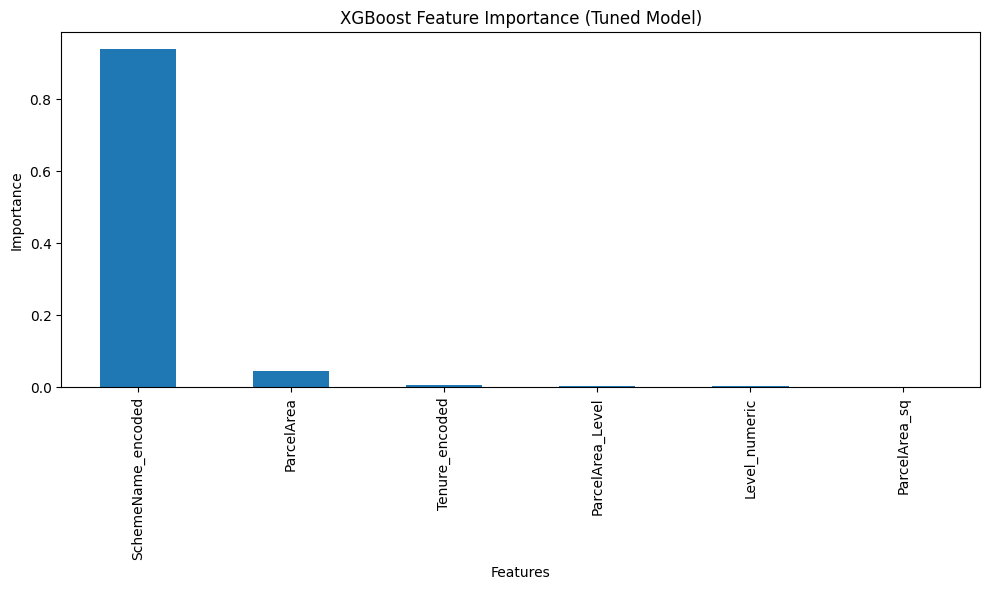

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Access the best estimator and its feature importances
best_xgb = grid_search.best_estimator_
importances = best_xgb.feature_importances_
feature_names = X_train.columns # Use the actual column names

# Create a pandas Series for easier plotting
importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importance_series.plot(kind='bar')
plt.title('XGBoost Feature Importance (Tuned Model)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:

best_xgb = grid_search.best_estimator_
importances = best_xgb.feature_importances_
feature_names = X_train.columns # Use the actual column names from X_train
importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False) # Use all importances and correct index
print("Tuned XGBoost Feature Importance (Best Estimator):")
print(importance_df)

Tuned XGBoost Feature Importance (Best Estimator):
SchemeName_encoded    0.938999
ParcelArea            0.045056
Tenure_encoded        0.006868
ParcelArea_Level      0.005338
Level_numeric         0.003739
ParcelArea_sq         0.000000
dtype: float32


In [ ]:
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"Tuned XGBoost - Test RMSE: {rmse_xgb:.4f}, Test R2: {r2_xgb:.4f}")

Tuned XGBoost - Test RMSE: 0.1149, Test R2: 0.9714


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [9, 10, 11],
    'min_child_weight': [8, 10, 12],
    'n_estimators': [200, 250]
}
xgb_model = xgb.XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"Best Params: {grid_search.best_params_}, Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

Best Params: {'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 250}, Best CV RMSE: 0.1125


In [ ]:
param_grid_xgb = {'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
grid_search_xgb = GridSearchCV(xgb.XGBRegressor(**grid_search.best_params_, random_state=42), param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)
print(f"Best XGBoost Params: {grid_search_xgb.best_params_}, Best CV RMSE: {np.sqrt(-grid_search_xgb.best_score_):.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:42:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:42:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:42:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:42:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:42:38] WARNING: /w

Best XGBoost Params: {'colsample_bytree': 1.0, 'subsample': 1.0}, Best CV RMSE: 0.1235


In [ ]:
param_grid_xgb = {'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]}
grid_search_xgb = GridSearchCV(xgb.XGBRegressor(**{'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 200}, random_state=42), param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)
print(f"Best XGBoost Params: {grid_search_xgb.best_params_}, Best CV RMSE: {np.sqrt(-grid_search_xgb.best_score_):.4f}")

Best XGBoost Params: {'colsample_bytree': 0.9, 'subsample': 0.9}, Best CV RMSE: 0.1126


In [ ]:
from sklearn.ensemble import VotingRegressor
voting_reg = VotingRegressor(estimators=[('rf', rf), ('xgb', best_xgb)])
voting_reg.fit(X_train, y_train)
y_pred_voting = voting_reg.predict(X_test)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
print(f"Voting Regressor - Test RMSE: {rmse_voting:.4f}")

Voting Regressor - Test RMSE: 0.1129


In [ ]:
from sklearn.ensemble import VotingRegressor
voting_reg = VotingRegressor(estimators=[('rf', rf), ('xgb', grid_search.best_estimator_)], weights=[0.55, 0.45])
voting_reg.fit(X_train, y_train)
y_pred_voting = voting_reg.predict(X_test)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
print(f"Weighted Voting Regressor - Test RMSE: {rmse_voting:.4f}")

Weighted Voting Regressor - Test RMSE: 0.1123


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Load the dataset (assuming preprocessed as in prior scripts)
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Feature engineering (same as before)
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y', errors='coerce')
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Prepare features and target
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = df[features].dropna()
y = np.log(df['TransactionPrice'].loc[X.index])

# Add engineered features
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Detect and remove outliers (using 2 SD from initial fit)
from sklearn.linear_model import LinearRegression
X_with_const = np.c_[np.ones(X.shape[0]), X] # Use X before scaling for initial model fit
model_initial = LinearRegression().fit(X_with_const, y)
residuals = y - model_initial.predict(X_with_const)
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers) # Drop outliers from X DataFrame
y = y.drop(outliers) # Drop outliers from y Series
print(f"Number of outliers removed: {len(outliers)}")

# Scale features *after* outlier removal
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index) # Convert scaled array back to DataFrame to retain index

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# LightGBM model
lgb_model = lgb.LGBMRegressor(
    max_depth=10,
    learning_rate=0.05,
    n_estimators=200,
    min_child_weight=10,
    random_state=42
)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f"LightGBM - Test RMSE: {rmse_lgb:.4f}, Test R2: {r2_lgb:.4f}")

# Cross-validation
cv_rmse = -cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"LightGBM CV RMSE: {np.sqrt(cv_rmse.mean()):.4f}")

# Feature importance
importances = lgb_model.feature_importances_
feature_names = X_train.columns # Use the actual column names from X_train
importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("LightGBM Feature Importance:")
print(importance_df)

Number of outliers removed: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 10808, number of used features: 7
[LightGBM] [Info] Start training from score 13.381634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [ ]:
param_grid_lgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [8, 10, 12],
    'min_child_weight': [5, 10, 15],
    'n_estimators': [200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
lgb_model = lgb.LGBMRegressor(random_state=42)
grid_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=5, scoring='neg_mean_squared_error')
grid_search_lgb.fit(X_train, y_train)
print(f"Best LightGBM Params: {grid_search_lgb.best_params_}, Best CV RMSE: {np.sqrt(-grid_search_lgb.best_score_):.4f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
best_lgb = grid_search_lgb.best_estimator_
y_pred_lgb = best_lgb.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f"Tuned LightGBM - Test RMSE: {rmse_lgb:.4f}, Test R2: {r2_lgb:.4f}")

Tuned LightGBM - Test RMSE: 0.1130, Test R2: 0.9715


In [ ]:
importances = best_lgb.feature_importances_
feature_names = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded', 'ParcelArea_sq', 'ParcelArea_Level']
importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Tuned LightGBM Feature Importance (Best Estimator):")
print(importance_df)

Tuned LightGBM Feature Importance (Best Estimator):
SchemeName_encoded    1803
ParcelArea            1486
ParcelArea_Level       902
Date_numeric           775
Level_numeric          491
ParcelArea_sq          404
Tenure_encoded         118
dtype: int32


In [ ]:
param_grid_lgb = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [10, 12, 14],
    'min_child_weight': [5, 7, 10],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search_lgb = GridSearchCV(lgb.LGBMRegressor(n_estimators=200, random_state=42), param_grid_lgb, cv=5, scoring='neg_mean_squared_error')
grid_search_lgb.fit(X_train, y_train)
print(f"Best LightGBM Params: {grid_search_lgb.best_params_}, Best CV RMSE: {np.sqrt(-grid_search_lgb.best_score_):.4f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

# Neural Network

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Removed import of cross_val_score as we will implement manually
# Removed import of KerasRegressor as we will not use the wrapper

# Load the dataset (assuming preprocessed as in prior scripts)
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Feature engineering (same as before)
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y', errors='coerce')
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Prepare features and target
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = df[features].dropna()
y = np.log(df['TransactionPrice'].loc[X.index])

# Add engineered features
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Detect and remove outliers (using 2 SD from initial fit)
from sklearn.linear_model import LinearRegression
X_with_const = np.c_[np.ones(X.shape[0]), X] # Use X before scaling for initial model fit
model_initial_ols = LinearRegression().fit(X_with_const, y)
residuals = y - model_initial_ols.predict(X_with_const)
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers) # Drop outliers from X DataFrame
y = y.drop(outliers) # Drop outliers from y Series
print(f"Number of outliers removed: {len(outliers)}")

# Scale features *after* outlier removal
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split for final evaluation
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the Keras model creation function
def create_model(input_dim):
    model = Sequential([
        Dense(16, activation='relu', input_shape=(input_dim,)),  # 16 neurons in hidden layer
        Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train the model on the full training set for test evaluation
model_ann = create_model(X_train_eval.shape[1])
model_ann.fit(X_train_eval, y_train_eval, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Predict and evaluate on test set
y_pred_ann = model_ann.predict(X_test_eval).flatten()
rmse_ann = np.sqrt(mean_squared_error(y_test_eval, y_pred_ann))
r2_ann = r2_score(y_test_eval, y_pred_ann)
print(f"ANN - Test RMSE: {rmse_ann:.4f}, Test R2: {r2_ann:.4f}")

# Manual K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_rmse_scores = []

print(f"\nPerforming {n_splits}-Fold Cross-Validation for ANN...")

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index] # Use y with original index for slicing

    # Create and train a new model for each fold
    model_fold = create_model(X_train_fold.shape[1])
    model_fold.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

    # Evaluate on the validation fold
    y_pred_fold = model_fold.predict(X_val_fold).flatten()
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    cv_rmse_scores.append(rmse_fold)
    print(f"  Fold RMSE: {rmse_fold:.4f}")


cv_rmse_mean = np.mean(cv_rmse_scores)
cv_rmse_std = np.std(cv_rmse_scores)

print(f"\nANN - Average CV RMSE: {cv_rmse_mean:.4f} (+/- {cv_rmse_std * 2:.4f})")

Number of outliers removed: 500


/tmp/ipython-input-2072072313.py:61: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_ann = create_model(X_train_eval.shape[1])


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ANN - Test RMSE: 0.1457, Test R2: 0.9527

Performing 5-Fold Cross-Validation for ANN...
--- Fold 1/5 ---


/tmp/ipython-input-2072072313.py:84: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = create_model(X_train_fold.shape[1])


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1405
--- Fold 2/5 ---


/tmp/ipython-input-2072072313.py:84: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = create_model(X_train_fold.shape[1])


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1499
--- Fold 3/5 ---


/tmp/ipython-input-2072072313.py:84: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = create_model(X_train_fold.shape[1])


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1446
--- Fold 4/5 ---


/tmp/ipython-input-2072072313.py:84: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = create_model(X_train_fold.shape[1])


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1499
--- Fold 5/5 ---


/tmp/ipython-input-2072072313.py:84: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = create_model(X_train_fold.shape[1])


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1516

ANN - Average CV RMSE: 0.1473 (+/- 0.0083)


In [ ]:
!pip install scikeras

In [ ]:
# Display R-squared for the ANN model
print(f"ANN - Test R2: {r2_ann:.4f}")

ANN - Test R2: 0.9527


In [ ]:
y_pred_ann = model.predict(X_test).flatten()
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
r2_ann = r2_score(y_test, y_pred_ann)
print(f"ANN - Test RMSE: {rmse_ann:.4f}, Test R2: {r2_ann:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ANN - Test RMSE: 0.1492, Test R2: 0.9504


In [ ]:
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import KFold # Import KFold for manual CV
from sklearn.metrics import mean_squared_error, r2_score # Import metrics

# Define the Keras model creation function
def build_tuned_model(input_dim, l2_reg=0.01, dropout_rate=0.2):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and compile the tuned Keras model
model = build_tuned_model(X_train.shape[1])

# Define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[callback], verbose=0)

# Predict and evaluate on test set
y_pred_ann = model.predict(X_test).flatten()
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
r2_ann = r2_score(y_test, y_pred_ann)
print(f"Tuned ANN - Test RMSE: {rmse_ann:.4f}, Test R2: {r2_ann:.4f}")

# Manual K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_rmse_scores = []

print(f"\nPerforming {n_splits}-Fold Cross-Validation for Tuned ANN...")

# Convert X_train and y_train to numpy arrays for KFold splitting
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train


for fold, (train_index, val_index) in enumerate(kf.split(X_train_np)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    # Create and train a new model for each fold
    model_fold = build_tuned_model(X_train_fold.shape[1])
    # Use the callback during training for each fold
    history_fold = model_fold.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[callback], verbose=0)


    # Evaluate on the validation fold
    y_pred_fold = model_fold.predict(X_val_fold).flatten()
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    cv_rmse_scores.append(rmse_fold)
    print(f"  Fold RMSE: {rmse_fold:.4f}")


cv_rmse_mean = np.mean(cv_rmse_scores)
cv_rmse_std = np.std(cv_rmse_scores)

print(f"\nTuned ANN - Average CV RMSE: {cv_rmse_mean:.4f} (+/- {cv_rmse_std * 2:.4f})")

/tmp/ipython-input-3030473120.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model = build_tuned_model(X_train.shape[1])


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Tuned ANN - Test RMSE: 0.1491, Test R2: 0.9504

Performing 5-Fold Cross-Validation for Tuned ANN...
--- Fold 1/5 ---


/tmp/ipython-input-3030473120.py:51: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1656
--- Fold 2/5 ---


/tmp/ipython-input-3030473120.py:51: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1980
--- Fold 3/5 ---


/tmp/ipython-input-3030473120.py:51: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1529
--- Fold 4/5 ---


/tmp/ipython-input-3030473120.py:51: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1615
--- Fold 5/5 ---


/tmp/ipython-input-3030473120.py:51: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1858

Tuned ANN - Average CV RMSE: 0.1728 (+/- 0.0332)


In [ ]:
y_pred_ann = model.predict(X_test).flatten()
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
r2_ann = r2_score(y_test, y_pred_ann)
print(f"Tuned ANN - Test RMSE: {rmse_ann:.4f}, Test R2: {r2_ann:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Tuned ANN - Test RMSE: 0.1491, Test R2: 0.9504


In [ ]:
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import KFold # Import KFold for manual CV
from sklearn.metrics import mean_squared_error, r2_score # Import metrics
import numpy as np # Import numpy

# Define the Keras model creation function
def build_simple_tuned_model(input_dim, l2_reg=0.001, dropout_rate=0.1):
    model = Sequential([
        Dense(16, activation='relu', input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# Create and compile the tuned Keras model
model = build_simple_tuned_model(X_train.shape[1])

# Define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[callback], verbose=0)

# Predict and evaluate on test set
y_pred_ann = model.predict(X_test).flatten()
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
r2_ann = r2_score(y_test, y_pred_ann)
print(f"Revised Tuned ANN - Test RMSE: {rmse_ann:.4f}, Test R2: {r2_ann:.4f}")

# Manual K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_rmse_scores = []

print(f"\nPerforming {n_splits}-Fold Cross-Validation for Revised Tuned ANN...")

# Convert X_train and y_train to numpy arrays for KFold splitting
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train


for fold, (train_index, val_index) in enumerate(kf.split(X_train_np)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    # Create and train a new model for each fold
    model_fold = build_simple_tuned_model(X_train_fold.shape[1])
    # Use the callback during training for each fold
    history_fold = model_fold.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[callback], verbose=0)

    # Evaluate on the validation fold
    y_pred_fold = model_fold.predict(X_val_fold).flatten()
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    cv_rmse_scores.append(rmse_fold)
    print(f"  Fold RMSE: {rmse_fold:.4f}")


cv_rmse_mean = np.mean(cv_rmse_scores)
cv_rmse_std = np.std(cv_rmse_scores)

print(f"\nRevised Tuned ANN - Average CV RMSE: {cv_rmse_mean:.4f} (+/- {cv_rmse_std * 2:.4f})")

/tmp/ipython-input-3511074082.py:17: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model = build_simple_tuned_model(X_train.shape[1])


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Revised Tuned ANN - Test RMSE: 0.1484, Test R2: 0.9509

Performing 5-Fold Cross-Validation for Revised Tuned ANN...
--- Fold 1/5 ---


/tmp/ipython-input-3511074082.py:50: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_simple_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Fold RMSE: 0.1904
--- Fold 2/5 ---


/tmp/ipython-input-3511074082.py:50: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_simple_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Fold RMSE: 0.1466
--- Fold 3/5 ---


/tmp/ipython-input-3511074082.py:50: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_simple_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1466
--- Fold 4/5 ---


/tmp/ipython-input-3511074082.py:50: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_simple_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold RMSE: 0.1630
--- Fold 5/5 ---


/tmp/ipython-input-3511074082.py:50: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  model_fold = build_simple_tuned_model(X_train_fold.shape[1])


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Fold RMSE: 0.1432

Revised Tuned ANN - Average CV RMSE: 0.1580 (+/- 0.0352)


Number of outliers removed: 526
X_scaled shape: (13867, 7)
NaN in X_scaled: 0
Epoch 1/100


/tmp/ipython-input-451875747.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ParcelArea_sq'] = X['ParcelArea'] ** 2
/tmp/ipython-input-451875747.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mod

555/555 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 31.3898 - val_loss: 0.6753
Epoch 2/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8938 - val_loss: 0.5452
Epoch 3/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8547 - val_loss: 0.5105
Epoch 4/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8154 - val_loss: 0.4866
Epoch 5/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7595 - val_loss: 0.4692
Epoch 6/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7497 - val_loss: 0.5071
Epoch 7/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6791 - val_loss: 0.4964
Epoch 8/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6593 - val_loss: 0.4726
Epoch 9/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6169 - val_loss: 0.4728
Epoch 10/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5945 - val_loss: 0.4723


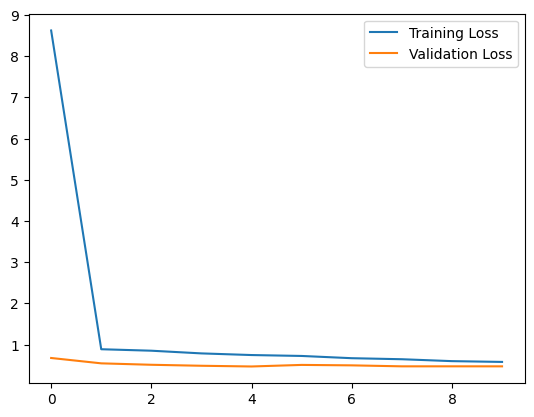

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Baseline - Test RMSE (Log): 0.7343, Test RMSE (Original MYR): 1042017, Test RMSE (%): 120.8%, Test R2 (Log): -0.0376, Test R2 (Original): -0.0744
Mean price used: 862706 MYR


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Baseline CV RMSE (Log): 0.7348 (+/- 0.1966), CV RMSE (Original MYR): 964098 (+/- 17118), CV RMSE (%): 111.8% (+/- 2.0%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Load and preprocess data
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y', errors='coerce')
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days
df = df.sort_values('TransactionDate')  # Sort by date to maintain order for sequence

# Prepare features and target
initial_features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric', 'SchemeName_encoded']
X = df[initial_features]
y = np.log(df['TransactionPrice'].loc[X.index])

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Handle missing values
X = X.fillna(0)
X = X.dropna()
y = y.loc[X.index]

# Remove outliers
X_with_const = np.c_[np.ones(X.shape[0]), X]
model_initial = LinearRegression().fit(X_with_const, y)
residuals = y - model_initial.predict(X_with_const)
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("X_scaled shape:", X_scaled.shape)
print("NaN in X_scaled:", np.isnan(X_scaled).sum())

# Train-test split
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Reshape for LSTM
look_back = 3
X_train_seq, y_train_seq = [], []
for i in range(look_back, len(X_train)):
    X_train_seq.append(X_train[i-look_back:i])
    y_train_seq.append(y_train.values[i])
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

X_test_seq, y_test_seq = [], []
for i in range(look_back, len(X_test)):
    X_test_seq.append(X_test[i-look_back:i])
    y_test_seq.append(y_test.values[i])
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Build and train LSTM
model = Sequential([
    LSTM(16, activation='tanh', input_shape=(look_back, X_train.shape[1]), return_sequences=False),
    Dropout(0.05),
    Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, callbacks=[callback], verbose=1)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate
y_pred_lstm = model.predict(X_test_seq).flatten()
rmse_lstm_log = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
rmse_lstm_orig = np.sqrt(mean_squared_error(np.exp(y_test_seq), np.exp(y_pred_lstm)))
mean_price = df['TransactionPrice'].loc[X.index].mean() # Calculate mean price using the final index of X
rmse_lstm_pct = (rmse_lstm_orig / mean_price) * 100
r2_lstm = r2_score(y_test_seq, y_pred_lstm)
r2_lstm_orig = r2_score(np.exp(y_test_seq), np.exp(y_pred_lstm))
print(f"LSTM Baseline - Test RMSE (Log): {rmse_lstm_log:.4f}, Test RMSE (Original MYR): {rmse_lstm_orig:.0f}, Test RMSE (%): {rmse_lstm_pct:.1f}%, Test R2 (Log): {r2_lstm:.4f}, Test R2 (Original): {r2_lstm_orig:.4f}")
print(f"Mean price used: {mean_price:.0f} MYR")

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_rmse_log = []
cv_rmse_orig = []
# Removed model re-initialization outside loop
for train_index, test_index in tscv.split(X_train_seq):
    X_train_cv, X_test_cv = X_train_seq[train_index], X_train_seq[test_index]
    y_train_cv, y_test_cv = y_train_seq[train_index], y_train_seq[test_index]
    # Build and train a new model for each fold
    model_cv = Sequential([
        LSTM(16, activation='tanh', input_shape=(look_back, X_train.shape[1]), return_sequences=False),
        Dropout(0.05),
        Dense(1, activation='linear')
    ])
    model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0), loss='mse')
    callback_cv = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history_cv = model_cv.fit(X_train_cv, y_train_cv, epochs=100, batch_size=16, validation_split=0.2, callbacks=[callback_cv], verbose=0)

    y_pred_cv = model_cv.predict(X_test_cv).flatten()
    cv_rmse_log.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))
    cv_rmse_orig.append(np.sqrt(mean_squared_error(np.exp(y_test_cv), np.exp(y_pred_cv))))
cv_rmse_log = np.array(cv_rmse_log)
cv_rmse_orig = np.array(cv_rmse_orig)
cv_rmse_pct = (cv_rmse_orig.mean() / mean_price) * 100
print(f"LSTM Baseline CV RMSE (Log): {cv_rmse_log.mean():.4f} (+/- {cv_rmse_log.std() * 2:.4f}), CV RMSE (Original MYR): {cv_rmse_orig.mean():.0f} (+/- {cv_rmse_orig.std() * 2:.0f}), CV RMSE (%): {cv_rmse_pct:.1f}% (+/- {(cv_rmse_orig.std() * 2 / mean_price) * 100:.1f}%)")

Number of outliers removed: 515
X_scaled shape: (13495, 7)
NaN in X_scaled: 0
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 19.0208 - val_loss: 0.5233
Epoch 2/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 3.4703 - val_loss: 0.5000
Epoch 3/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 3.0232 - val_loss: 0.5504
Epoch 4/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3286 - val_loss: 0.5278
Epoch 5/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.9018 - val_loss: 0.4977
Epoch 6/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.4445 - val_loss: 0.4778
Epoch 7/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.0205 - val_loss: 0.4784
Epoch 8/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8372 - val_loss: 0.4933
Epoch 9/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7310 - val_loss: 0.4926
Epoch 10/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6170 - val_loss: 0.4678
Epoch 11/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5382 - val_loss: 0.4897
Epoch 12/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/st

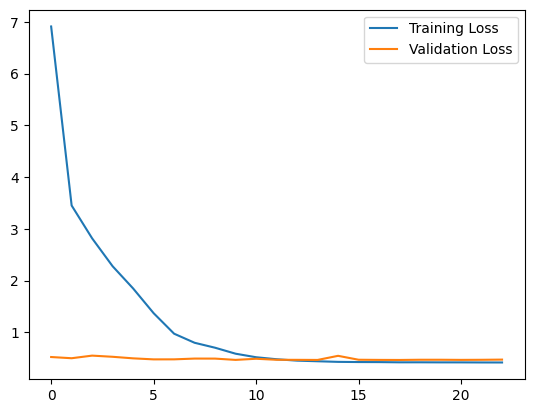

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Improved LSTM - Test RMSE (Log): 0.7233, Test RMSE (Original MYR): 1045004, Test RMSE (%): 121.9%, Test R2 (Log): -0.0040, Test R2 (Original): -0.0608
Mean price used: 857059 MYR


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Improved LSTM CV RMSE (Log): 0.6856 (+/- 0.0666), CV RMSE (Original MYR): 923888 (+/- 58651), CV RMSE (%): 107.8% (+/- 6.8%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Load data to ensure a fresh start with indexing
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Basic preprocessing that might affect index
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y', errors='coerce')

# Drop rows with NaT in TransactionDate or NaNs in other core features *before* outlier detection
initial_cols_for_cleaning = ['ParcelArea', 'Level_numeric', 'Tenure_encoded', 'TransactionDate']
df = df.dropna(subset=initial_cols_for_cleaning).copy() # Drop NaNs that prevent date parsing or core features
df['Date_numeric'] = (df['TransactionDate'] - df['TransactionDate'].min()).dt.days # Calculate Date_numeric after dropping NaNs
df = df.sort_values('TransactionDate')  # Sort by date

# Add SchemeName_encoded after initial cleaning and sorting
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)


# Prepare features and target for initial outlier detection from the cleaned df
initial_features_for_outlier_detection = ['ParcelArea', 'Level_numeric', 'Tenure_encoded', 'SchemeName_encoded', 'Date_numeric']
X_for_outliers = df[initial_features_for_outlier_detection].copy()
y_for_outliers = np.log(df['TransactionPrice'].copy())

# Add nonlinear and interaction terms for outlier detection
X_for_outliers['ParcelArea_sq'] = X_for_outliers['ParcelArea'] ** 2
X_for_outliers['ParcelArea_Level'] = X_for_outliers['ParcelArea'] * X_for_outliers['Level_numeric']

# Handle missing values in X_for_outliers created by engineered features (if any)
X_for_outliers = X_for_outliers.fillna(0)
y_for_outliers = y_for_outliers.loc[X_for_outliers.index] # Ensure y aligns after fillna


# Remove outliers using a boolean mask on the main DataFrame
X_with_const = np.c_[np.ones(X_for_outliers.shape[0]), X_for_outliers]
model_initial = LinearRegression().fit(X_with_const, y_for_outliers)
residuals = y_for_outliers - model_initial.predict(X_with_const)
# Create a boolean mask for outliers based on residuals and y_for_outliers index
outlier_mask = abs(residuals) > 2 * residuals.std()

# Filter the original DataFrame to remove outliers
# Use y_for_outliers index to ensure alignment with residuals
df_cleaned = df.loc[y_for_outliers.index][~outlier_mask].copy()
print(f"Number of outliers removed: {outlier_mask.sum()}")


# Prepare features and target from the cleaned DataFrame
initial_features = ['ParcelArea', 'Level_numeric', 'Tenure_encoded', 'SchemeName_encoded', 'Date_numeric']
X = df_cleaned[initial_features].copy()
y = np.log(df_cleaned['TransactionPrice'].copy())

# Add nonlinear and interaction terms to the cleaned features
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Handle remaining missing values (if any) after outlier removal and feature engineering
X = X.fillna(0)
y = y.loc[X.index] # Ensure y aligns with X after potential further drops due to fillna


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("X_scaled shape:", X_scaled.shape)
print("NaN in X_scaled:", np.isnan(X_scaled).sum())

# Train-test split
train_size = int(0.8 * len(X_scaled))
X_train_scaled, X_test_scaled = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# Reshape for LSTM
look_back = 6
X_train_seq, y_train_seq = [], []
for i in range(look_back, len(X_train_scaled)):
    X_train_seq.append(X_train_scaled[i-look_back:i])
    y_train_seq.append(y_train.values[i])
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

X_test_seq, y_test_seq = [], []
for i in range(look_back, len(X_test_scaled)):
    X_test_seq.append(X_test_scaled[i-look_back:i])
    y_test_seq.append(y_test.values[i])
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Build and train LSTM
model = Sequential([
    LSTM(32, activation='tanh', input_shape=(look_back, X_train_scaled.shape[1]), return_sequences=False),
    Dropout(0.05),
    Dense(8, activation='relu'),
    Dropout(0.05),
    Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, callbacks=[callback], verbose=1)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate
y_pred_lstm = model.predict(X_test_seq).flatten()
rmse_lstm_log = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
rmse_lstm_orig = np.sqrt(mean_squared_error(np.exp(y_test_seq), np.exp(y_pred_lstm)))
# Calculate mean price using the cleaned DataFrame
mean_price = df_cleaned['TransactionPrice'].mean()
rmse_lstm_pct = (rmse_lstm_orig / mean_price) * 100
r2_lstm = r2_score(y_test_seq, y_pred_lstm)
r2_lstm_orig = r2_score(np.exp(y_test_seq), np.exp(y_pred_lstm))
print(f"Improved LSTM - Test RMSE (Log): {rmse_lstm_log:.4f}, Test RMSE (Original MYR): {rmse_lstm_orig:.0f}, Test RMSE (%): {rmse_lstm_pct:.1f}%, Test R2 (Log): {r2_lstm:.4f}, Test R2 (Original): {r2_lstm_orig:.4f}")
print(f"Mean price used: {mean_price:.0f} MYR")

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_rmse_log = []
cv_rmse_orig = []
# Build and compile a new model for each fold
for train_index, test_index in tscv.split(X_train_seq):
    X_train_cv, X_test_cv = X_train_seq[train_index], X_train_seq[test_index]
    y_train_cv, y_test_cv = y_train_seq[train_index], y_train_seq[test_index]
    model_cv = Sequential([
        LSTM(32, activation='tanh', input_shape=(look_back, X_train_scaled.shape[1]), return_sequences=False),
        Dropout(0.05),
        Dense(8, activation='relu'),
        Dropout(0.05),
        Dense(1, activation='linear')
    ])
    model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0), loss='mse')
    callback_cv = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history_cv = model_cv.fit(X_train_cv, y_train_cv, epochs=100, batch_size=16, validation_split=0.2, callbacks=[callback_cv], verbose=0)

    y_pred_cv = model_cv.predict(X_test_cv).flatten()
    cv_rmse_log.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))
    cv_rmse_orig.append(np.sqrt(mean_squared_error(np.exp(y_test_cv), np.exp(y_pred_cv))))
cv_rmse_log = np.array(cv_rmse_log)
cv_rmse_orig = np.array(cv_rmse_orig)
cv_rmse_pct = (cv_rmse_orig.mean() / mean_price) * 100
print(f"Improved LSTM CV RMSE (Log): {cv_rmse_log.mean():.4f} (+/- {cv_rmse_log.std() * 2:.4f}), CV RMSE (Original MYR): {cv_rmse_orig.mean():.0f} (+/- {cv_rmse_orig.std() * 2:.0f}), CV RMSE (%): {cv_rmse_pct:.1f}% (+/- {(cv_rmse_orig.std() * 2 / mean_price) * 100:.1f}%)")

Number of outliers removed: 522
X_scaled shape: (13871, 9)
NaN in X_scaled: 0
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


555/555 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 27.3239 - val_loss: 1.0105
Epoch 2/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.3994 - val_loss: 1.0108
Epoch 3/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.0453 - val_loss: 0.9715
Epoch 4/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.8314 - val_loss: 0.6044
Epoch 5/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.5547 - val_loss: 0.5794
Epoch 6/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.4050 - val_loss: 0.5630
Epoch 7/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.9833 - val_loss: 0.5809
Epoch 8/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.6823 - val_loss: 0.5043
Epoch 9/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5447 - val_loss: 0.5322
Epoch 10/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3033 - val_loss: 0.4699
Epoch 11/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0813 - val_loss: 0.4775
Epoch 12/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/ste

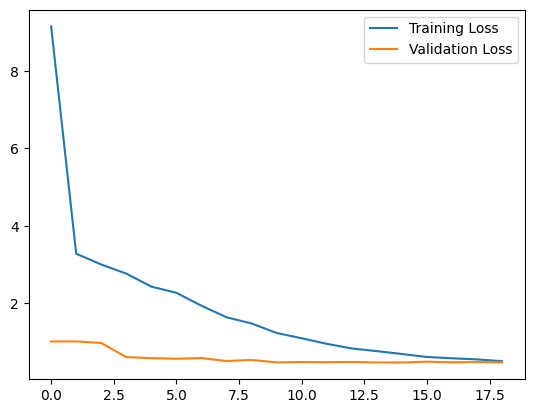

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Optimized LSTM - Test RMSE (Log): 0.7233, Test RMSE (Original MYR): 1042011, Test RMSE (%): 120.7%, Test R2 (Log): -0.0028, Test R2 (Original): -0.0652
Mean price used: 863116 MYR


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Optimized LSTM CV RMSE (Log): 0.7899 (+/- 0.2407), CV RMSE (Original MYR): 968927 (+/- 142625), CV RMSE (%): 112.3% (+/- 16.5%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Load and preprocess data
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y', errors='coerce')
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days
df['MonthSin'] = np.sin(2 * np.pi * df['TransactionDate'].dt.month / 12)
df['MonthCos'] = np.cos(2 * np.pi * df['TransactionDate'].dt.month / 12)
df = df.sort_values('TransactionDate')  # Sort by date to maintain order for sequence

# Prepare features and target for initial outlier detection
initial_features_for_outlier_detection = ['ParcelArea', 'Level_numeric', 'Tenure_encoded', 'SchemeName_encoded', 'Date_numeric', 'MonthSin', 'MonthCos']
X_for_outliers = df[initial_features_for_outlier_detection].copy()
y_for_outliers = np.log(df['TransactionPrice'].copy())


# Add nonlinear and interaction terms for outlier detection
X_for_outliers['ParcelArea_sq'] = X_for_outliers['ParcelArea'] ** 2
X_for_outliers['ParcelArea_Level'] = X_for_outliers['ParcelArea'] * X_for_outliers['Level_numeric']


# Handle missing values before outlier detection
X_for_outliers = X_for_outliers.fillna(0)
y_for_outliers = y_for_outliers.loc[X_for_outliers.index] # Ensure y aligns after fillna


# Remove outliers using a boolean mask on the main DataFrame
X_with_const = np.c_[np.ones(X_for_outliers.shape[0]), X_for_outliers]
model_initial = LinearRegression().fit(X_with_const, y_for_outliers)
residuals = y_for_outliers - model_initial.predict(X_with_const)
# Create a boolean mask for outliers based on residuals and y_for_outliers index
outlier_mask = abs(residuals) > 2 * residuals.std()

# Filter the original DataFrame to remove outliers
# Use y_for_outliers index to ensure alignment with residuals
df_cleaned = df.loc[y_for_outliers.index][~outlier_mask].copy()
print(f"Number of outliers removed: {outlier_mask.sum()}")


# Prepare features and target from the cleaned DataFrame
initial_features = ['ParcelArea', 'Level_numeric', 'Tenure_encoded', 'SchemeName_encoded', 'Date_numeric', 'MonthSin', 'MonthCos']
X = df_cleaned[initial_features].copy()
y = np.log(df_cleaned['TransactionPrice'].copy())

# Add nonlinear and interaction terms to the cleaned features
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']


# Handle remaining missing values (if any) after outlier removal and feature engineering
X = X.fillna(0)
y = y.loc[X.index] # Ensure y aligns with X after potential further drops due to fillna


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("X_scaled shape:", X_scaled.shape)
print("NaN in X_scaled:", np.isnan(X_scaled).sum())

# Train-test split
train_size = int(0.8 * len(X_scaled))
X_train_scaled, X_test_scaled = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Reshape for LSTM
look_back = 3
X_train_seq, y_train_seq = [], []
for i in range(look_back, len(X_train_scaled)):
    X_train_seq.append(X_train_scaled[i-look_back:i])
    y_train_seq.append(y_train.values[i])
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

X_test_seq, y_test_seq = [], []
for i in range(look_back, len(X_test_scaled)):
    X_test_seq.append(X_test_scaled[i-look_back:i])
    y_test_seq.append(y_test.values[i])
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Build and train LSTM
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(look_back, X_train_scaled.shape[1]), return_sequences=False),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, callbacks=[callback], verbose=1)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate
y_pred_lstm = model.predict(X_test_seq).flatten()
rmse_lstm_log = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
rmse_lstm_orig = np.sqrt(mean_squared_error(np.exp(y_test_seq), np.exp(y_pred_lstm)))
# Calculate mean price using the cleaned DataFrame
mean_price = df_cleaned['TransactionPrice'].mean()
rmse_lstm_pct = (rmse_lstm_orig / mean_price) * 100
r2_lstm = r2_score(y_test_seq, y_pred_lstm)
r2_lstm_orig = r2_score(np.exp(y_test_seq), np.exp(y_pred_lstm))
print(f"Optimized LSTM - Test RMSE (Log): {rmse_lstm_log:.4f}, Test RMSE (Original MYR): {rmse_lstm_orig:.0f}, Test RMSE (%): {rmse_lstm_pct:.1f}%, Test R2 (Log): {r2_lstm:.4f}, Test R2 (Original): {r2_lstm_orig:.4f}")
print(f"Mean price used: {mean_price:.0f} MYR")

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_rmse_log = []
cv_rmse_orig = []
# Build and compile a new model for each fold
for train_index, test_index in tscv.split(X_train_seq):
    X_train_cv, X_test_cv = X_train_seq[train_index], X_train_seq[test_index]
    y_train_cv, y_test_cv = y_train_seq[train_index], y_train_seq[test_index]
    model_cv = Sequential([
        LSTM(64, activation='tanh', input_shape=(look_back, X_train_scaled.shape[1]), return_sequences=False),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])
    model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005, clipnorm=1.0), loss='mse')
    callback_cv = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history_cv = model_cv.fit(X_train_cv, y_train_cv, epochs=100, batch_size=16, validation_split=0.2, callbacks=[callback_cv], verbose=0)

    y_pred_cv = model_cv.predict(X_test_cv).flatten()
    cv_rmse_log.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))
    cv_rmse_orig.append(np.sqrt(mean_squared_error(np.exp(y_test_cv), np.exp(y_pred_cv))))
cv_rmse_log = np.array(cv_rmse_log)
cv_rmse_orig = np.array(cv_rmse_orig)
cv_rmse_pct = (cv_rmse_orig.mean() / mean_price) * 100
print(f"Optimized LSTM CV RMSE (Log): {cv_rmse_log.mean():.4f} (+/- {cv_rmse_log.std() * 2:.4f}), CV RMSE (Original MYR): {cv_rmse_orig.mean():.0f} (+/- {cv_rmse_orig.std() * 2:.0f}), CV RMSE (%): {cv_rmse_pct:.1f}% (+/- {(cv_rmse_orig.std() * 2 / mean_price) * 100:.1f}%)")

# Neural Network 2

# Transformer

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv"
df = pd.read_csv(url)

# Preprocess
df = df[df['UnitLevel'].str.isnumeric() | (df['UnitLevel'] == 'G')]  # Drop non-numeric Level
df['UnitLevel'] = df['UnitLevel'].replace('G', 0).astype(float)
df['Price per sq.m'] = df['TransactionPrice'] / df['ParcelArea']

# No outlier removal in this run

# Continue preprocessing
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')

# Target encoding for SchemeName
global_mean = df['Price per sq.m'].mean()  # ~5,533
m = 10  # Smoothing
scheme_means = df.groupby('SchemeName')['Price per sq.m'].agg(['mean', 'count'])
scheme_means['Encoded'] = (scheme_means['count'] * scheme_means['mean'] + m * global_mean) / (scheme_means['count'] + m)
df = df.merge(scheme_means['Encoded'], left_on='SchemeName', right_index=True)

# Features and target
features = ['ParcelArea', 'UnitLevel', 'TransactionDate', 'Tenure', 'Encoded']
# Remove 'TransactionDate' from features as it's a string and cannot be scaled directly
features = ['ParcelArea', 'UnitLevel', 'Tenure', 'Encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = df['Price per sq.m']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # Validation split

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # (batch, seq_len=1, features)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for mini-batch
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Transformer model
class TransformerRegressor(nn.Module):
    def __init__(self, input_size, num_layers=1, num_heads=4, hidden_size=64, dropout=0.2):
        super(TransformerRegressor, self).__init__()
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1, input_size))  # Positional encoding
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_size, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x + self.pos_encoder  # Add positional encoding
        out = self.transformer_encoder(x)
        out = self.relu(out.mean(dim=1))  # Mean pool over sequence
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Initialize model
input_size = X_train_scaled.shape[1]
model = TransformerRegressor(input_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Early stopping parameters
patience = 10
min_val_loss = float('inf')
patience_counter = 0
best_model_state = None

# Train with mini-batch and early stopping
epochs = 200
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_t)
        val_loss = criterion(val_outputs, y_val_t).item()

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Transformer Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_state)

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t)

y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_t.numpy().flatten()

mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)
print(f"Transformer Metrics: MSE={mse:.0f}, RMSE={rmse:.0f}, MAE={mae:.0f}, R²={r2:.2f}")

Transformer Metrics: MSE=2941992, RMSE=1715, MAE=813, R²=0.71


# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

# Train Regression Model and Evaluate the Results. Compare it against other advanced Models: Random Forest, Decision Tree & Gradient Boosting

# Read finalized dataset

In [ ]:
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
# Import mean_absolute_error here
from sklearn.metrics import mean_absolute_error

df = pd.read_csv('/content/drive/MyDrive/dataset/houseprice_Cleaned_OutlierRemoved_LabelEncoded_LogTransformed_MP1.csv')  # load CSV


# Data types and non-null values
# Convert df.info() output to a DataFrame for better formatting
info_df = pd.DataFrame(df.info())
display(HTML(info_df.to_html()))

Drive already mounted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10968 entries, 0 to 10967
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Land/Parcel Area       10968 non-null  float64
 1   Mukim                  10968 non-null  int64  
 2   Scheme Name/Area       10968 non-null  int64  
 3   Tenure                 10968 non-null  int64  
 4   Transaction Date       10968 non-null  object 
 5   Transaction Price      10968 non-null  int64  
 6   Unit Level             10968 non-null  int64  
 7   Log_Transaction_Price  10968 non-null  float64
 8   Log_LandParcel_Area    10968 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 771.3+ KB


""


# TensorFLow Decision Forest

In [ ]:
## prompt: perform TensorFlow Decision Forest and plot the graph

#!pip install tensorflow_decision_forests

import tensorflow_decision_forests as tfdf
import tensorflow as tf

df = df.drop(['Transaction Date', 'Transaction Price', 'Land/Parcel Area'], axis=1)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X = df.drop('Log_Transaction_Price', axis=1)
y = df['Log_Transaction_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to TensorFlow datasets, specifying the task as regression
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train, y_train], axis=1), label='Log_Transaction_Price', task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_test, y_test], axis=1), label='Log_Transaction_Price', task=tfdf.keras.Task.REGRESSION)


# Build a Random Forest Regression model
model = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION) # Explicitly set task here as well

# Compile the model with metrics
# We need to specify the metrics we want to see during evaluation
# model.compile(metrics=["mae", "rmse"])


model.fit(train_ds)

# Use the model inspector to get evaluation metrics
inspector = model.make_inspector()
evaluation = inspector.evaluation()

print(f"RMSE: {evaluation.rmse}")
#print(f"MAE: {evaluation.mae}")
#print(f"R2: {evaluation.r_squared}")

# Plot the model graph (Decision Tree example from TFDF)
# Note: Visualizing the entire Random Forest is not feasible directly as a single graph.
# We can visualize a single tree from the forest if needed, but for the overall model,
# performance metrics and feature importance are more common visualizations.

# To visualize a single tree (e.g., the first tree):
# tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

# Get SUM_SCORE importances as a list of (feature, importance) tuples
importances = inspector.variable_importances()["SUM_SCORE"]

# Build DataFrame from tuples
importance_df = pd.DataFrame(importances, columns=["Feature", "Importance"])\
                  .sort_values(by="Importance", ascending=False)


display(importance_df)


Use 2 thread(s) for training
Use /tmp/tmporqld846 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Mukim': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'Scheme_Name/Area': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'Tenure': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Unit_Level': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'Log_LandParcel_Area': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>}
Label: Tensor("data_5:0", shape=(None,), dtype=float64)
Weights: None
Normalized tensor features:
 {'Mukim': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'Scheme_Name/Area': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'Tenure': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'Unit_Level': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, 

I0000 00:00:1747624934.340246     901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747624934.340388     901 kernel.cc:783] Collect training examples
I0000 00:00:1747624934.340451     901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747624934.340640     901 kernel.cc:401] Number of batches: 9
I0000 00:00:1747624934.340655     901 kernel.cc:402] Number of examples: 8774
I0000 00:00:1747624934.341739     901 kernel.cc:802] Training dataset:
Number of records: 8774
Number of columns: 6

Number of columns by type:
	NUMERICAL: 6 (100%)

Columns:

NUMERICAL: 6 (100%)
	0: "Log_LandParcel_Area" NUMERICAL mean:4.64642 min:3.66356 max:5.1985 sd:0.239198
	1: "Mukim" NUMERICAL mean:3.68897 min:0 max:7 sd:1.

Model trained in 0:00:10.817434
Compiling model...
Model compiled.
RMSE: 0.16635827649254098


,Feature,Importance
0,"(Log_LandParcel_Area, 1, 0)",353142.965002
1,"(Scheme_Name/Area, 1, 2)",182278.898613
2,"(Mukim, 1, 1)",65425.408693
3,"(Unit_Level, 1, 4)",26761.411412
4,"(Tenure, 1, 3)",18956.836819


# Random Forest Regressor

Random Forest Regressor MAE: 0.1032079051724088
Random Forest Regressor MSE: 0.02530596257607478
Random Forest Regressor R-squared: 0.9027094256239336


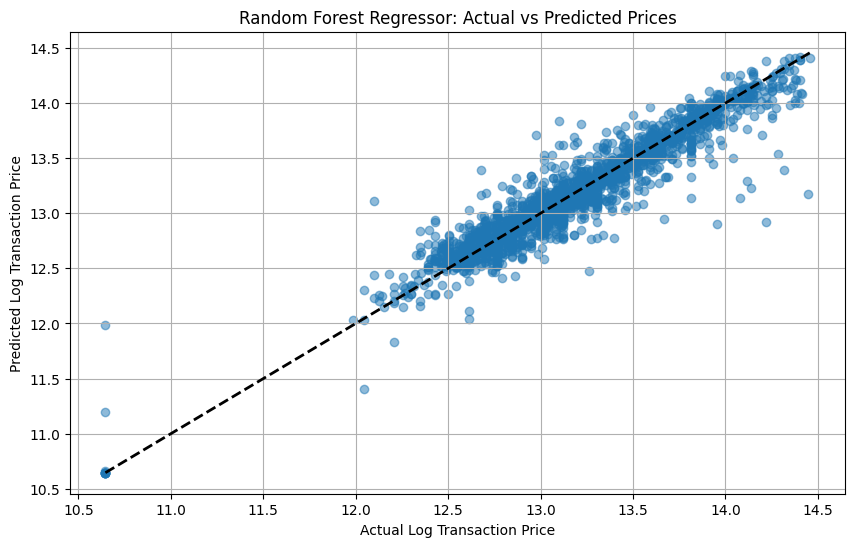

In [ ]:
# prompt: apply random forest regressor

from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # You can adjust n_estimators

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model using Mean Absolute Error
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest Regressor MAE: {mae_rf}")

# You can also evaluate with other metrics like Mean Squared Error (MSE) or R-squared
from sklearn.metrics import mean_squared_error, r2_score
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regressor MSE: {mse_rf}")
print(f"Random Forest Regressor R-squared: {r2_rf}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Actual Log Transaction Price')
plt.ylabel('Predicted Log Transaction Price')
plt.title('Random Forest Regressor: Actual vs Predicted Prices')
plt.grid(True)
plt.show()

# Extract Feature Importance from Random Forest


Random Forest Regressor Feature Importances:


,Feature,Importance
4,Log_LandParcel_Area,0.528122
1,Scheme Name/Area,0.290075
0,Mukim,0.110197
3,Unit Level,0.050930
2,Tenure,0.020676


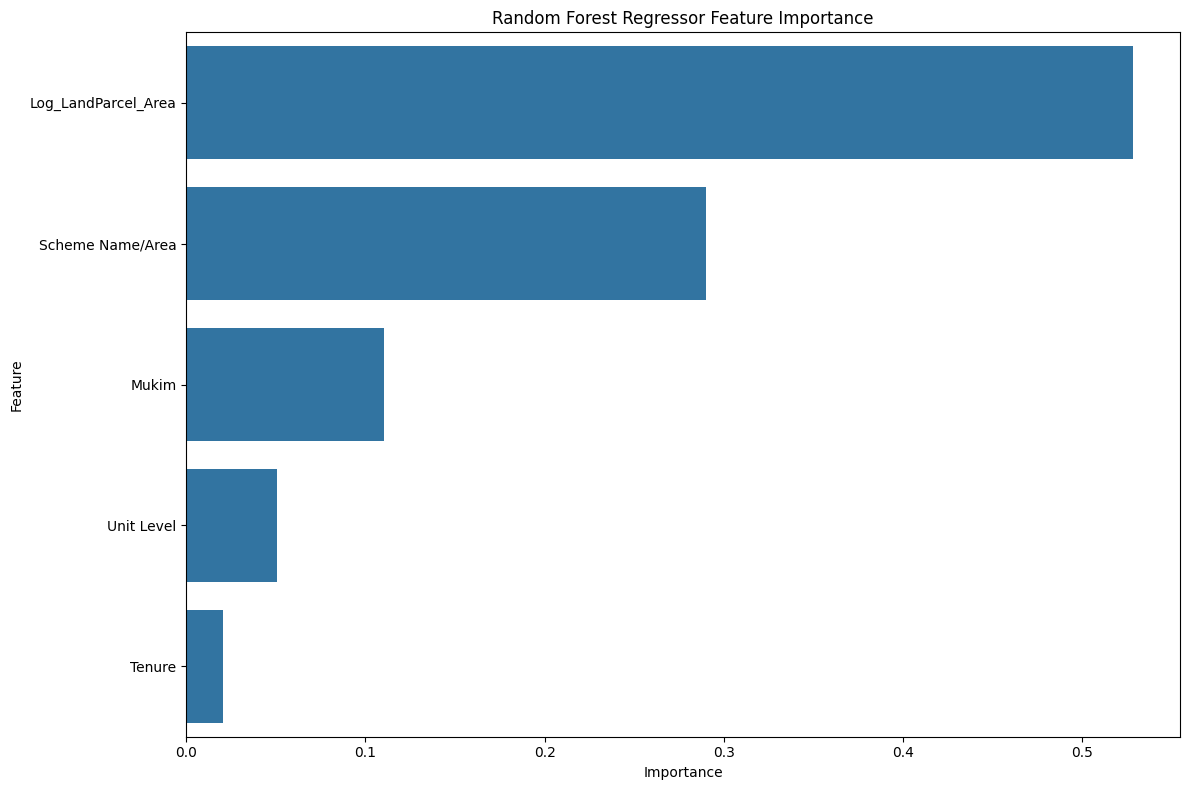

In [ ]:
# prompt: extract feature importance from random forest model

# Get feature importances from the Random Forest Regressor model
feature_importances = rf_model.feature_importances_

# Get the feature names from the training data
feature_names = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("\nRandom Forest Regressor Feature Importances:")
display(feature_importance_df)

# Optionally, visualize the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Regressor Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Ramdom Forest RMSE

In [ ]:
# prompt: evaluate RMSE

# Calculate RMSE for Random Forest
rmse_rf = np.sqrt(mse_rf)
print(f"Random Forest Regressor RMSE: {rmse_rf}")

# Calculate average RMSE for KFold Random Forest
rmse_scores_rf = np.sqrt(mse_scores_rf)
print(f"Random Forest - Average RMSE: {np.mean(rmse_scores_rf):.6f} (+/- {np.std(rmse_scores_rf):.6f})")

# Calculate average RMSE for KFold SVM
rmse_scores_svm = np.sqrt(mse_scores_svm)
print(f"SVM - Average RMSE: {np.mean(rmse_scores_svm):.6f} (+/- {np.std(rmse_scores_svm):.6f})")

Random Forest Regressor RMSE: 0.15907847929897614
Random Forest - Average RMSE: 0.165367 (+/- 0.008186)
SVM - Average RMSE: 0.259174 (+/- 0.007015)


# Random Forest k-Fold Validation

In [ ]:
# prompt: include k-folder validation

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize KFold
n_splits = 5  # You can choose the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare arrays to store results for each fold
mae_scores_rf = []
mse_scores_rf = []
r2_scores_rf = []

mae_scores_svm = []
mse_scores_svm = []
r2_scores_svm = []

# Convert X and y to numpy arrays for KFold splitting
X_np = X.values
y_np = y.values

# Perform K-Fold Cross-Validation
print(f"\nPerforming {n_splits}-Fold Cross-Validation...")

for fold, (train_index, test_index) in enumerate(kf.split(X_np)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_test_fold = X_np[train_index], X_np[test_index]
    y_train_fold, y_test_fold = y_np[train_index], y_np[test_index]

    # --- Random Forest Regression ---
    print("Training Random Forest...")
    rf_model_kf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_kf.fit(X_train_fold, y_train_fold)
    y_pred_rf_fold = rf_model_kf.predict(X_test_fold)

    # Evaluate Random Forest
    mae_rf_fold = mean_absolute_error(y_test_fold, y_pred_rf_fold)
    mse_rf_fold = mean_squared_error(y_test_fold, y_pred_rf_fold)
    r2_rf_fold = r2_score(y_test_fold, y_pred_rf_fold)

    mae_scores_rf.append(mae_rf_fold)
    mse_scores_rf.append(mse_rf_fold)
    r2_scores_rf.append(r2_rf_fold)

    print(f"  Random Forest - MAE: {mae_rf_fold:.4f}, MSE: {mse_rf_fold:.4f}, R2: {r2_rf_fold:.4f}")

    # --- SVM Regression ---
    print("Training SVM...")
    svm_model_kf = SVR(kernel='rbf', C=100, gamma='auto')
    svm_model_kf.fit(X_train_fold, y_train_fold)
    y_pred_svm_fold = svm_model_kf.predict(X_test_fold)

    # Evaluate SVM
    mae_svm_fold = mean_absolute_error(y_test_fold, y_pred_svm_fold)
    mse_svm_fold = mean_squared_error(y_test_fold, y_pred_svm_fold)
    r2_svm_fold = r2_score(y_test_fold, y_pred_svm_fold)

    mae_scores_svm.append(mae_svm_fold)
    mse_scores_svm.append(mse_svm_fold)
    r2_scores_svm.append(r2_svm_fold)

    print(f"  SVM - MAE: {mae_svm_fold:.4f}, MSE: {mse_svm_fold:.4f}, R2: {r2_svm_fold:.4f}")


# Print average scores across all folds
print("\n--- Average Scores Across All Folds ---")

print(f"Random Forest - Average MAE: {np.mean(mae_scores_rf):.6f} (+/- {np.std(mae_scores_rf):.6f})")
print(f"Random Forest - Average MSE: {np.mean(mse_scores_rf):.6f} (+/- {np.std(mse_scores_rf):.6f})")
print(f"Random Forest - Average R2: {np.mean(r2_scores_rf):.6f} (+/- {np.std(r2_scores_rf):.6f})")

print(f"SVM - Average MAE: {np.mean(mae_scores_svm):.6f} (+/- {np.std(mae_scores_svm):.6f})")
print(f"SVM - Average MSE: {np.mean(mse_scores_svm):.6f} (+/- {np.std(mse_scores_svm):.6f})")
print(f"SVM - Average R2: {np.mean(r2_scores_svm):.6f} (+/- {np.std(r2_scores_svm):.6f})")

# You can add visualization for KFold results if needed,
# e.g., box plots of metric scores across folds.

In [ ]:
# prompt: evaluate RMSE

rmse_svm = np.sqrt(mse_svm)
print(f"SVM Regressor RMSE: {rmse_svm}")

SVM Regressor RMSE: 0.24532097236856776


# SVM


SVM Regressor MAE: 0.1642669417852253
SVM Regressor MSE: 0.060182379483859585
SVM Regressor R-squared: 0.7686245583545278


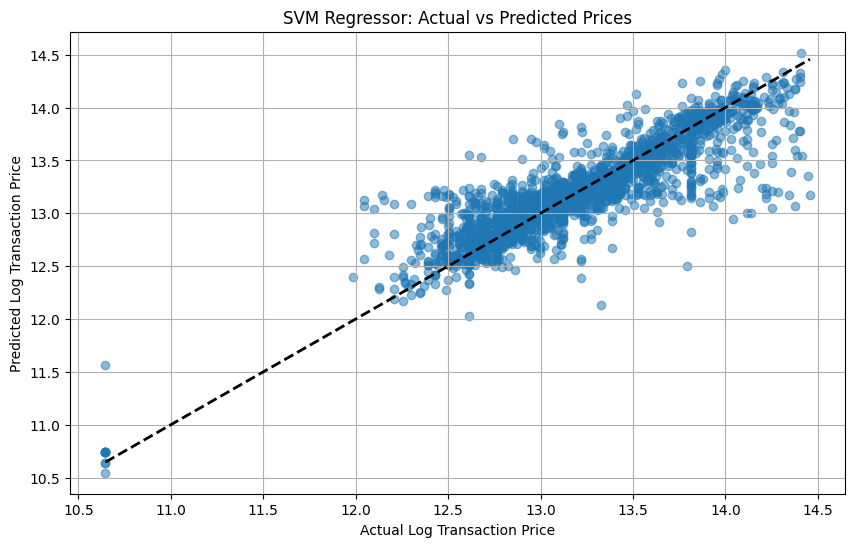

In [ ]:
# prompt: use SVM to predict

from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = df.drop(['Transaction Date', 'Transaction Price', 'Land/Parcel Area'], axis=1)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X = df.drop('Log_Transaction_Price', axis=1)
y = df['Log_Transaction_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create an SVM Regressor model
# You might need to tune the kernel and C parameters
svm_model = SVR(kernel='rbf', C=100, gamma='auto')

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print(f"\nSVM Regressor MAE: {mae_svm}")
print(f"SVM Regressor MSE: {mse_svm}")
print(f"SVM Regressor R-squared: {r2_svm}")

# Plot actual vs predicted values for SVM
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svm, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Actual Log Transaction Price')
plt.ylabel('Predicted Log Transaction Price')
plt.title('SVM Regressor: Actual vs Predicted Prices')
plt.grid(True)
plt.show()


# HyperParamter Tuning for SVM

In [ ]:
# prompt: perform hyperparameter tuning for SVM

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'linear']      # Specify kernels to test
}

# Create a GridSearchCV object
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data
print("Performing GridSearchCV for SVM hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

print("\nBest cross-validation MSE score (negative):")
print(grid_search.best_score_) # Note: GridSearchCV uses negative MSE for optimization

# The best model found by grid search
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best_svm = best_svm_model.predict(X_test)

mae_best_svm = mean_absolute_error(y_test, y_pred_best_svm)
mse_best_svm = mean_squared_error(y_test, y_pred_best_svm)
r2_best_svm = r2_score(y_test, y_pred_best_svm)
rmse_best_svm = np.sqrt(mse_best_svm)

print(f"\nBest SVM Regressor (after tuning) MAE: {mae_best_svm}")
print(f"Best SVM Regressor (after tuning) MSE: {mse_best_svm}")
print(f"Best SVM Regressor (after tuning) R-squared: {r2_best_svm}")
print(f"Best SVM Regressor (after tuning) RMSE: {rmse_best_svm}")

# Plot actual vs predicted values for the best SVM
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_svm, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Actual Log Transaction Price')
plt.ylabel('Predicted Log Transaction Price')
plt.title('Best SVM Regressor: Actual vs Predicted Prices (Tuned)')
plt.grid(True)
plt.show()

Performing GridSearchCV for SVM hyperparameter tuning...


Drive already mounted

Decision Tree Regressor (CART) MAE: 0.11382350308813742
Decision Tree Regressor (CART) MSE: 0.03415202496675826
Decision Tree Regressor (CART) R-squared: 0.8687001091093429
Decision Tree Regressor (CART) RMSE: 0.18480266493413525


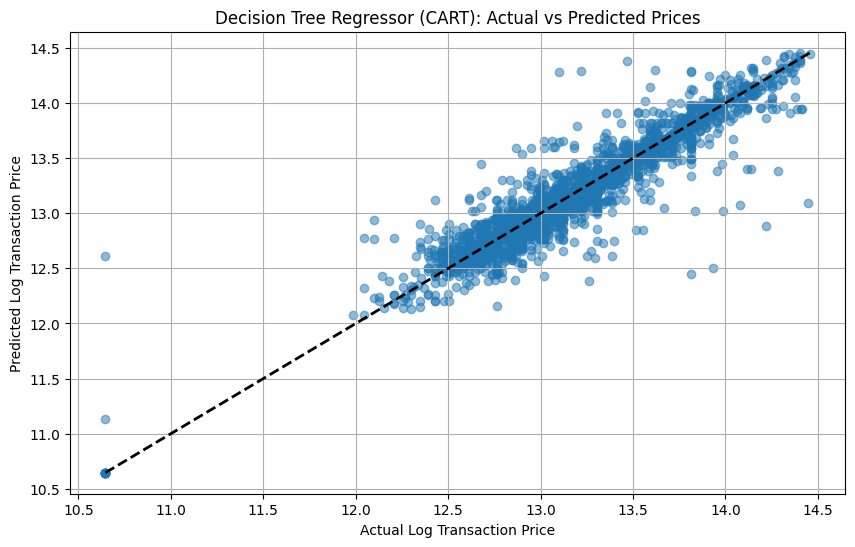


Decision Tree Regressor (CART) Feature Importances:


,Feature,Importance
4,Log_LandParcel_Area,0.524251
1,Scheme Name/Area,0.302906
0,Mukim,0.107907
3,Unit Level,0.045754
2,Tenure,0.019182


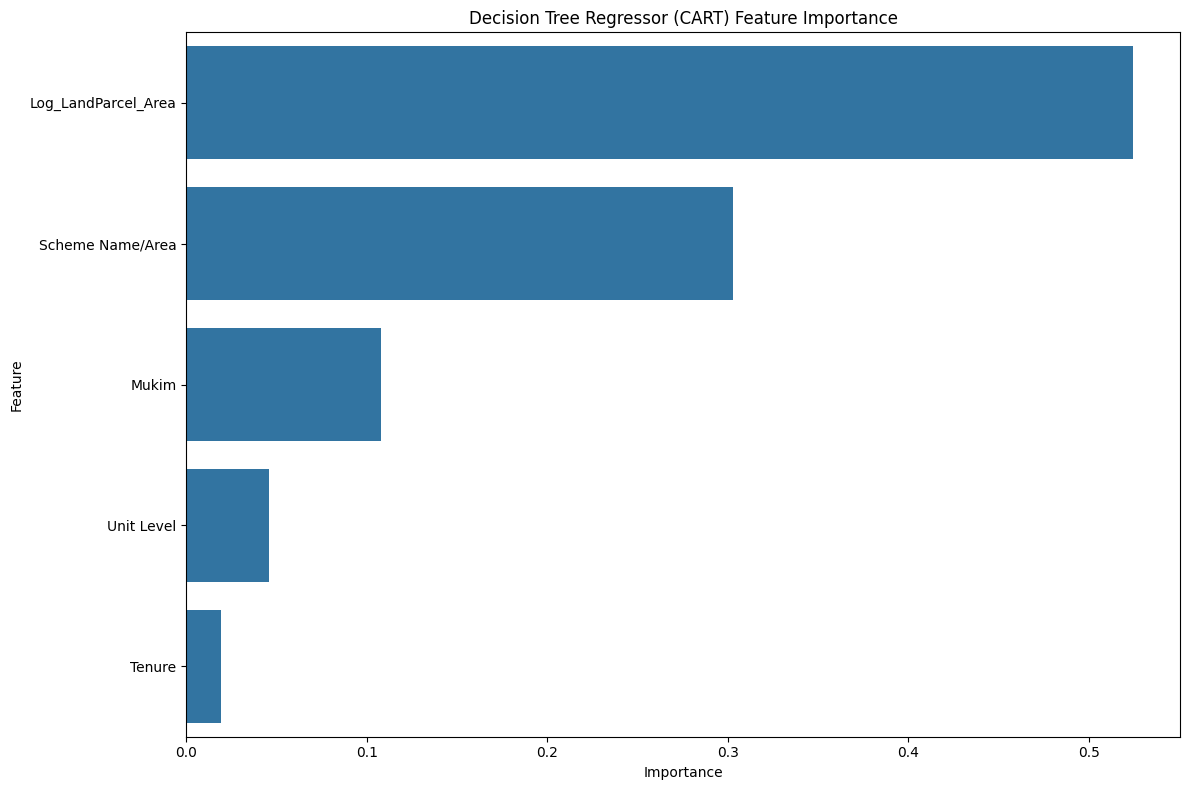


Performing 5-Fold Cross-Validation for Decision Tree (CART)...
--- Fold 1/5 ---
Training Decision Tree (CART)...
  Decision Tree (CART) - MAE: 0.1136, MSE: 0.0339, R2: 0.8696, RMSE: 0.1842
--- Fold 2/5 ---
Training Decision Tree (CART)...
  Decision Tree (CART) - MAE: 0.1095, MSE: 0.0326, R2: 0.8742, RMSE: 0.1806
--- Fold 3/5 ---
Training Decision Tree (CART)...
  Decision Tree (CART) - MAE: 0.1165, MSE: 0.0412, R2: 0.8483, RMSE: 0.2031
--- Fold 4/5 ---
Training Decision Tree (CART)...
  Decision Tree (CART) - MAE: 0.1193, MSE: 0.0458, R2: 0.8284, RMSE: 0.2141
--- Fold 5/5 ---
Training Decision Tree (CART)...
  Decision Tree (CART) - MAE: 0.1123, MSE: 0.0374, R2: 0.8509, RMSE: 0.1935

--- Average Scores Across All Folds for Decision Tree (CART) ---
Decision Tree (CART) - Average MAE: 0.114247 (+/- 0.003375)
Decision Tree (CART) - Average MSE: 0.038210 (+/- 0.004847)
Decision Tree (CART) - Average R2: 0.854280 (+/- 0.016423)
Decision Tree (CART) - Average RMSE: 0.195087 (+/- 0.012293)


In [ ]:
# prompt: use CART to predict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

from google.colab import drive
import os

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
# Import mean_absolute_error here
from sklearn.metrics import mean_absolute_error

df = pd.read_csv('/content/drive/MyDrive/dataset/houseprice_Cleaned_OutlierRemoved_LabelEncoded_LogTransformed_MP1.csv')  # load CSV


df = df.drop(['Transaction Date', 'Transaction Price', 'Land/Parcel Area'], axis=1)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X = df.drop('Log_Transaction_Price', axis=1)
y = df['Log_Transaction_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Regressor model (CART)
dt_model = DecisionTreeRegressor(random_state=42) # You can adjust hyperparameters like max_depth

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)


print(f"\nDecision Tree Regressor (CART) MAE: {mae_dt}")
print(f"Decision Tree Regressor (CART) MSE: {mse_dt}")
print(f"Decision Tree Regressor (CART) R-squared: {r2_dt}")
print(f"Decision Tree Regressor (CART) RMSE: {rmse_dt}")


# Plot actual vs predicted values for Decision Tree
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_dt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Actual Log Transaction Price')
plt.ylabel('Predicted Log Transaction Price')
plt.title('Decision Tree Regressor (CART): Actual vs Predicted Prices')
plt.grid(True)
plt.show()

# Get feature importances from the Decision Tree Regressor model
feature_importances_dt = dt_model.feature_importances_

# Get the feature names from the training data
feature_names = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_dt_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_dt})

# Sort the DataFrame by importance in descending order
feature_importance_dt_df = feature_importance_dt_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("\nDecision Tree Regressor (CART) Feature Importances:")
display(feature_importance_dt_df)

# Optionally, visualize the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_dt_df)
plt.title('Decision Tree Regressor (CART) Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Prepare arrays to store results for each fold for Decision Tree
mae_scores_dt = []
mse_scores_dt = []
r2_scores_dt = []
rmse_scores_dt = []

# Convert X and y to numpy arrays for KFold splitting
X_np = X.values
y_np = y.values

# Initialize KFold
n_splits = 5  # You can choose the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation for Decision Tree
print(f"\nPerforming {n_splits}-Fold Cross-Validation for Decision Tree (CART)...")

for fold, (train_index, test_index) in enumerate(kf.split(X_np)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_test_fold = X_np[train_index], X_np[test_index]
    y_train_fold, y_test_fold = y_np[train_index], y_np[test_index]

    # --- Decision Tree Regression ---
    print("Training Decision Tree (CART)...")
    dt_model_kf = DecisionTreeRegressor(random_state=42)
    dt_model_kf.fit(X_train_fold, y_train_fold)
    y_pred_dt_fold = dt_model_kf.predict(X_test_fold)

    # Evaluate Decision Tree
    mae_dt_fold = mean_absolute_error(y_test_fold, y_pred_dt_fold)
    mse_dt_fold = mean_squared_error(y_test_fold, y_pred_dt_fold)
    r2_dt_fold = r2_score(y_test_fold, y_pred_dt_fold)
    rmse_dt_fold = np.sqrt(mse_dt_fold)

    mae_scores_dt.append(mae_dt_fold)
    mse_scores_dt.append(mse_dt_fold)
    r2_scores_dt.append(r2_dt_fold)
    rmse_scores_dt.append(rmse_dt_fold)

    print(f"  Decision Tree (CART) - MAE: {mae_dt_fold:.4f}, MSE: {mse_dt_fold:.4f}, R2: {r2_dt_fold:.4f}, RMSE: {rmse_dt_fold:.4f}")

# Print average scores across all folds for Decision Tree
print("\n--- Average Scores Across All Folds for Decision Tree (CART) ---")

print(f"Decision Tree (CART) - Average MAE: {np.mean(mae_scores_dt):.6f} (+/- {np.std(mae_scores_dt):.6f})")
print(f"Decision Tree (CART) - Average MSE: {np.mean(mse_scores_dt):.6f} (+/- {np.std(mse_scores_dt):.6f})")
print(f"Decision Tree (CART) - Average R2: {np.mean(r2_scores_dt):.6f} (+/- {np.std(r2_scores_dt):.6f})")
print(f"Decision Tree (CART) - Average RMSE: {np.mean(rmse_scores_dt):.6f} (+/- {np.std(rmse_scores_dt):.6f})")



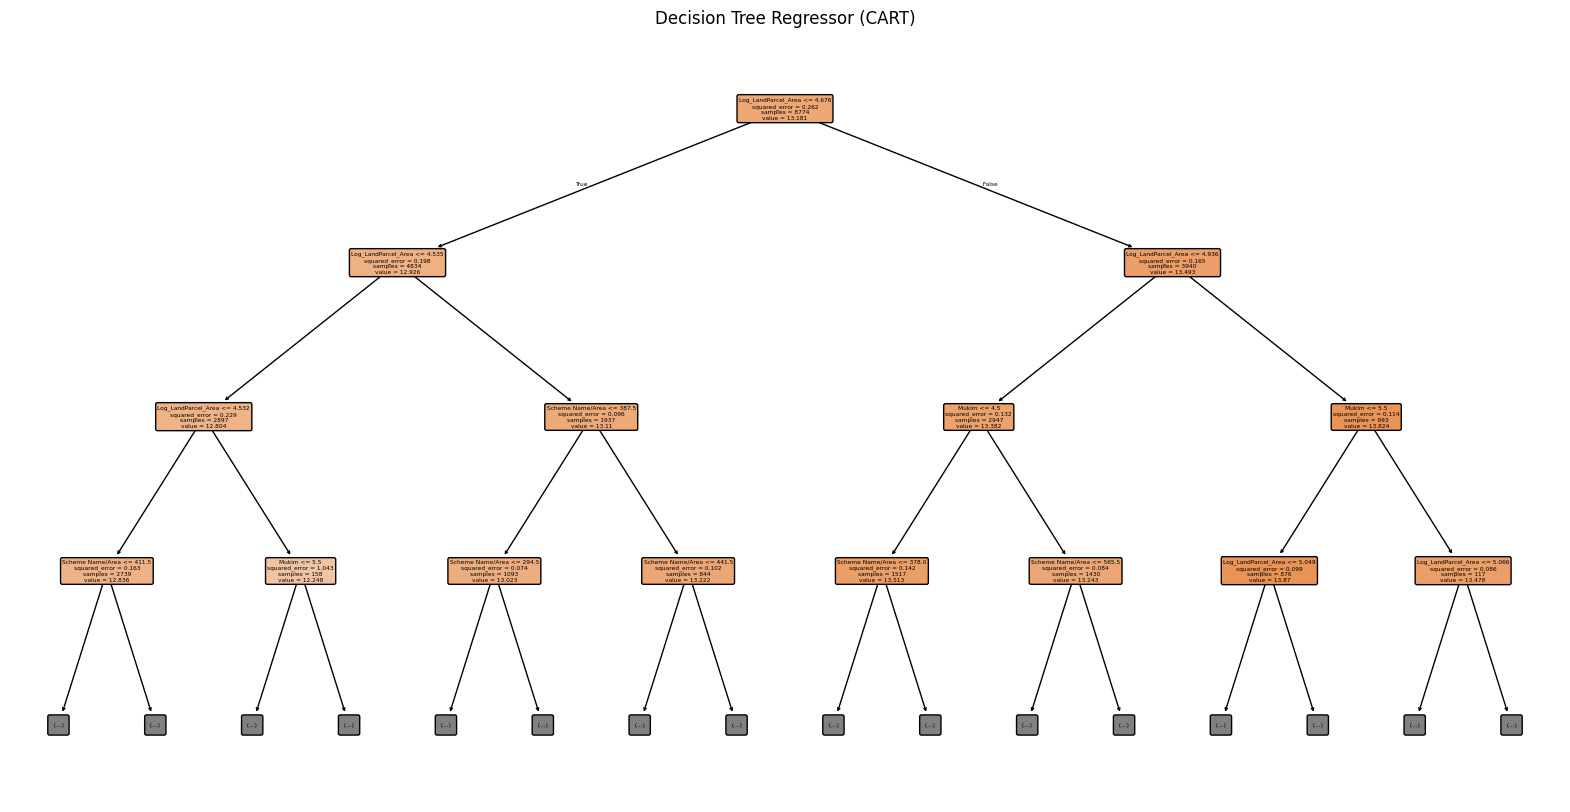

In [ ]:
# prompt: plot tree

# You can visualize a single tree from the Decision Tree Regressor model (CART)
# For larger trees, visualizing the entire tree might be overwhelming.
# You can limit the depth for better visualization.

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
plot_tree(dt_model, feature_names=X.columns, filled=True, rounded=True, max_depth=3) # Limit depth for readability
plt.title("Decision Tree Regressor (CART)")
plt.show()

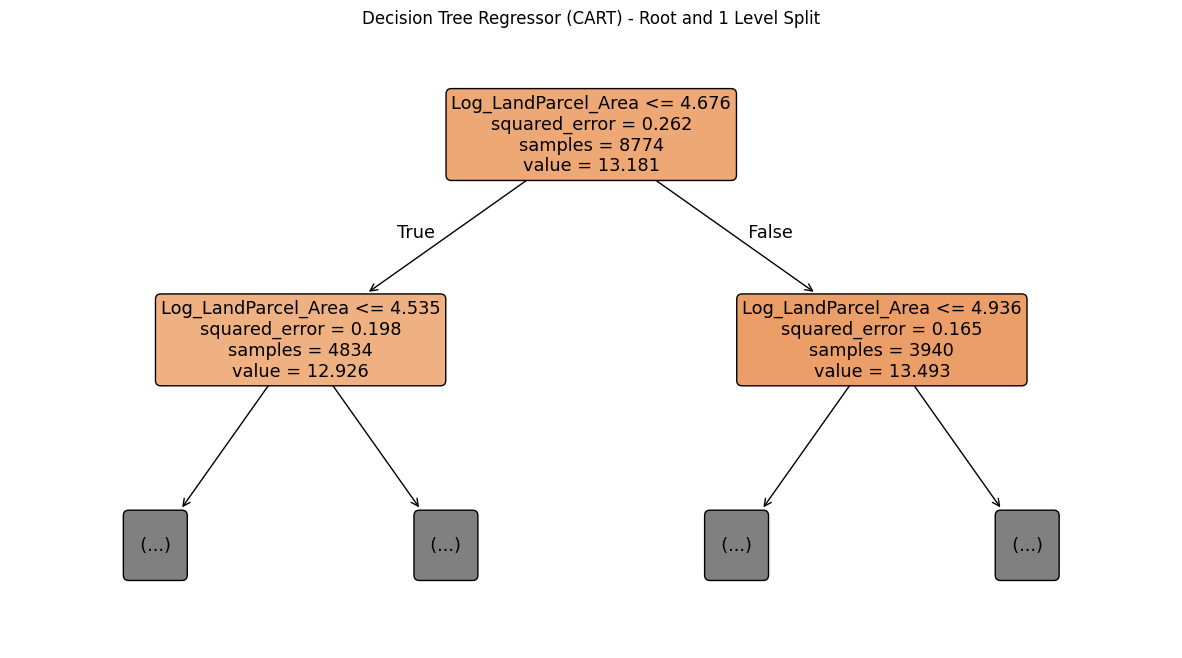

In [ ]:
# prompt: plot tree with root and 1 level split

plt.figure(figsize=(15, 8)) # Adjust figure size as needed
plot_tree(dt_model, feature_names=X.columns, filled=True, rounded=True, max_depth=1) # Plot with max_depth=1
plt.title("Decision Tree Regressor (CART) - Root and 1 Level Split")
plt.show()


In [ ]:
# prompt: insights about the workings behind decision tree regressor in house price prediction

Insights into the workings behind a Decision Tree Regressor in the context of house price prediction, as seen in the provided code:

1.  **Recursive Partitioning**: The core idea of a Decision Tree Regressor is to split the dataset into smaller and smaller subsets based on the features. For house price prediction, this means the algorithm looks for features (like 'Area', 'Number of Rooms', 'Location') that best divide the houses into groups with similar prices.

2.  **Splitting Criteria**: At each node of the tree, the algorithm evaluates different features and different split points (thresholds for numerical features, or categories for categorical features) to find the split that minimizes the "impurity" or "error" in the resulting child nodes. For regression, common criteria include:
    *   **Mean Squared Error (MSE)**: A split is chosen to minimize the weighted average MSE of the two resulting child nodes. This is a standard criterion, and the `DecisionTreeRegressor` in scikit-learn uses it by default (equivalent to 'squared_error' in newer versions).
    *   **Mean Absolute Error (MAE)**: Less common than MSE, but also an option.

3.  **Tree Building (CART Algorithm)**: The code uses the `DecisionTreeRegressor` from scikit-learn, which implements the CART (Classification and Regression Trees) algorithm. CART builds binary trees (each node splits into exactly two child nodes). It continues splitting nodes until a stopping criterion is met.

4.  **Stopping Criteria**: The tree growth stops when certain conditions are met, preventing the tree from becoming too complex and overfitting the training data. These criteria can include:
    *   `max_depth`: The maximum depth of the tree. Limiting depth helps prevent overfitting.
    *   `min_samples_split`: The minimum number of samples required to split an internal node.
    *   `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
    *   `min_impurity_decrease`: A threshold for the decrease in impurity required to make a split.

5.  **Leaf Nodes and Prediction**: Once the tree is built, the terminal nodes (leaf nodes) contain the data points that have been grouped together by the splits. For regression, the prediction for a new data point that falls into a specific leaf node is typically the average (or sometimes the median) of the target variable (house prices) for all training samples in that leaf node. In your case, it will predict the average `Log_Transaction_Price` for the houses in that leaf.

6.  **Handling Numerical and Categorical Features**: The algorithm inherently handles both types of features. For numerical features, it finds optimal split points (e.g., is 'Area' > 1500 sq ft?). For categorical features (if not pre-encoded), it can group categories or use one-hot encoding. Your code preprocesses categorical features via label encoding before training.

7.  **Feature Importance**: Decision trees provide a measure of feature importance. Features that result in significant reductions in impurity when used for splitting are considered more important. The `feature_importances_` attribute in your code quantifies how much each feature contributes to reducing the MSE (or the chosen impurity criterion) across all splits in the tree. Features with higher importance (like 'Area' or 'Location' in many house price datasets) are those that the model relies on most heavily to make its predictions.

8.  **Strengths in House Price Prediction**:
    *   **Interpretability**: Compared to models like Neural Networks or SVMs, a single decision tree is relatively easy to understand. You can visualize the tree (as attempted in your code, although limiting depth is crucial for large trees) and follow the decision paths to see how features influence the prediction.
    *   **No Feature Scaling Needed**: Decision trees are not sensitive to the scale of features, unlike models based on distance (like SVM or k-NN).
    *   **Handles Non-linear Relationships**: Decision trees can capture complex, non-linear relationships between features and the target variable.

9.  **Weaknesses in House Price Prediction**:
    *   **Prone to Overfitting**: Without proper tuning of parameters (like `max_depth`, `min_samples_split`, etc.), a single deep decision tree can easily overfit the training data, leading to poor performance on unseen data.
    *   **Instability**: Small changes in the training data can lead to a completely different tree structure.
    *   **Bias towards Dominant Features**: Features with more levels or continuous numerical features can sometimes be favored in splits, even if other features are also important.
    *   **Limited Prediction Range**: A single decision tree can only predict values that are present in the training data within the leaf nodes. It cannot extrapolate beyond the range of the training data.

In essence, the Decision Tree Regressor works by learning a set of hierarchical rules (the splits) based on the features in your house price data to predict the target price. It's a relatively simple yet powerful algorithm, but its performance heavily relies on controlling its complexity to avoid overfitting. The feature importance output is particularly valuable in house price prediction as it highlights which attributes of a property are most influential in determining its price according to the model.

# Perform Linear Regression and plot the grah

Mean Absolute Error: 0.28206019788672176
Root Mean Squared Error: 0.38086645569313393
Mean Squared Error: 0.14505925707224995
R-squared: 0.44230936101725127


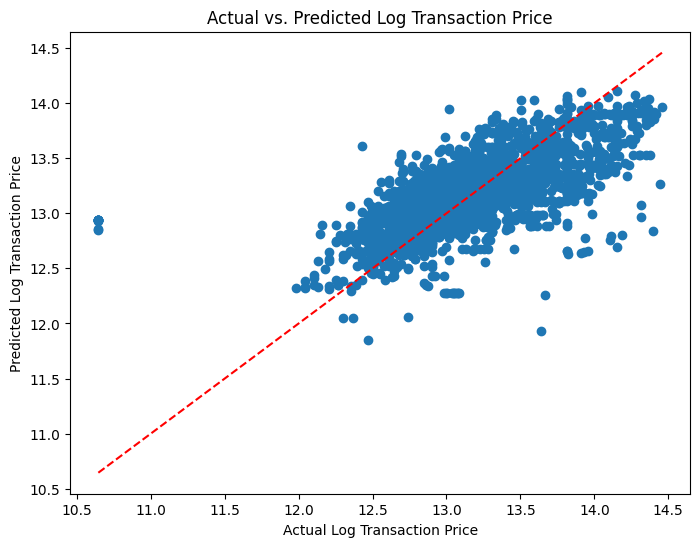

Coefficients: [-3.79203277e-02  3.19945643e-04 -7.53994275e-02  1.35381844e-04
  1.27876348e+00]
Intercept: 7.302138352891362

Regression Equation:


'Log_Transaction_Price = 7.302138352891362 + -0.0379 * Mukim + 0.0003 * Scheme Name/Area + -0.0754 * Tenure + 0.0001 * Unit Level + 1.2788 * Log_LandParcel_Area'

In [ ]:
# prompt: perform linear regression, plot the graph

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = df.drop(['Transaction Date', 'Transaction Price', 'Land/Parcel Area'], axis=1)

# Assuming 'Log_Transaction_Price' is your target variable and other columns are features
X = df.drop('Log_Transaction_Price', axis=1)
y = df['Log_Transaction_Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse) # RMSE is the square root of MSE

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Log Transaction Price")
plt.ylabel("Predicted Log Transaction Price")
plt.title("Actual vs. Predicted Log Transaction Price")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line
plt.show()

# Print the coefficients and intercept to get the regression equation
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Example of how to construct the equation string (adjust based on your feature names)
equation = f"Log_Transaction_Price = {model.intercept_}"
for i, coef in enumerate(model.coef_):
  equation += f" + {coef:.4f} * {X.columns[i]}"
print("\nRegression Equation:")
display(equation)


import pickle

# Save the trained model to a file
filename = '/content/drive/MyDrive/dataset/PropertyPrediction_LinearRegressionModel_MP1.sav'
pickle.dump(model, open(filename, 'wb'))



In [ ]:
# prompt: add MAE and RMSE

from sklearn.metrics import mean_absolute_error

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse) # RMSE is the square root of MSE

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

In [ ]:
# prompt: insights and implication from the result

# Interpretation of the Results:

# Mean Absolute Error (MAE):
# The MAE represents the average magnitude of errors in the predictions. A lower MAE indicates that the model's predictions are, on average, closer to the actual values. The value of your MAE should be interpreted in the context of the scale of your target variable (Log_Transaction_Price).

# Root Mean Squared Error (RMSE):
# RMSE is similar to MAE but penalizes larger errors more heavily. It provides a measure of the standard deviation of the residuals (prediction errors). Like MAE, a lower RMSE is better. The RMSE is also on the same scale as the target variable.

# Mean Squared Error (MSE):
# MSE is the average of the squared differences between actual and predicted values. It is used to calculate RMSE.

# R-squared (R2):
# R-squared represents the proportion of the variance in the dependent variable (Log_Transaction_Price) that is predictable from the independent variables (features). An R-squared value between 0 and 1 indicates the goodness of fit of the model. An R2 of 1 means the model perfectly predicts the dependent variable, while an R2 of 0 means the model does not explain any of the variability in the dependent variable. The closer R2 is to 1, the better the model fits the data.

# Coefficients and Intercept:
# The coefficients represent the change in the mean of the response variable for one unit of change in the predictor variable, holding other predictors constant. The intercept is the predicted mean of the response variable when all predictor variables are zero. These values form the linear regression equation.

# Plot of Actual vs. Predicted Values:
# This scatter plot visually shows how well the model's predictions align with the actual values. If the points cluster closely around the diagonal red line, it indicates a good fit. Deviations from the line show where the model is making errors.

# Regression Equation:
# The printed regression equation explicitly shows the linear relationship learned by the model between the features and the log of the transaction price.

# Implications from the Results:

# Model Performance:
# The values of MAE, RMSE, and R2 provide a quantitative assessment of how well your linear regression model is performing on the test data. You should compare these metrics to other models you might build (like the Random Forest, Decision Tree, and Gradient Boosting models you mentioned intending to compare against) to determine which model performs best.

# Predictive Power:
# A reasonable R-squared value suggests that the included features have some predictive power for the log of the transaction price. The specific value indicates how much of the variability in the price is explained by your model.

# Feature Importance (Indirectly):
# While linear regression coefficients indicate the direction and magnitude of the relationship between a feature and the target variable, they don't directly measure feature importance in the same way as some other models. However, examining the magnitude of the coefficients can give you some idea of which features have a larger impact on the predicted price, assuming features are on a comparable scale or have been standardized.

# Model Limitations:
# Linear regression assumes a linear relationship between features and the target, independence of errors, homoscedasticity (constant variance of errors), and normality of errors. If these assumptions are violated, the model's performance might be suboptimal, and the insights derived from the coefficients might be misleading.

# Future Steps and Comparison:
# The next crucial step, as indicated by your commented-out code, is to compare the performance of this linear regression model against more advanced models like Random Forest, Decision Tree, and Gradient Boosting. You will need to train these models on the same data split and evaluate their performance using the same metrics (MAE, RMSE, R2) to determine which model is the most suitable for predicting property prices. Different models might capture non-linear relationships or interactions between features that linear regression cannot.

# Business Implications:
# Depending on the model's performance, it can be used to predict property prices, which can be valuable for real estate agents, buyers, sellers, and investors. The model's insights (from coefficients or feature importance in other models) can help understand which factors are most influential in determining property prices. For instance, if a specific feature has a large positive coefficient, it suggests that increasing that feature's value tends to increase the predicted property price.

# Model Deployment:
# If the linear regression model is chosen as the best model (or for its simplicity), the saved model file (`PropertyPrediction_LinearRegressionModel_MP1.sav`) can be used to make predictions on new, unseen data without retraining the model.

# Overall, the results provide a baseline performance for your linear regression model. The insights help you understand how well this specific model explains the variance in property prices and the estimated impact of each feature. The implications highlight the need for comparison with other models and the potential practical applications of a well-performing predictive model.


In [ ]:
# prompt: output all the feature names

print(X.columns.tolist())

['Mukim', 'Scheme Name/Area', 'Tenure', 'Unit Level', 'Log_LandParcel_Area']


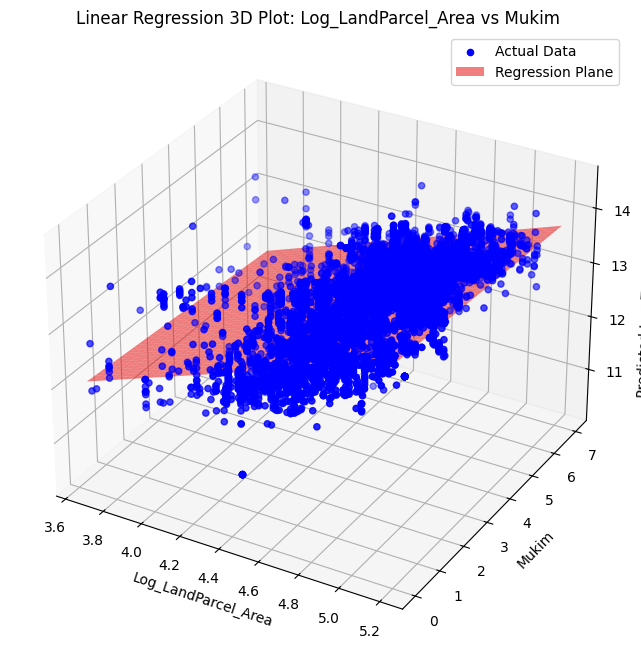

In [ ]:
# prompt: plot 3D graph for multiple linear regression, using sets of 2 features

from mpl_toolkits.mplot3d import Axes3D

# Assuming you have identified two features you want to plot in 3D with the target variable
# Choose two features from your training data's columns
feature1_name = 'Log_LandParcel_Area' # Replace with an actual feature name from X_train.columns
feature2_name = 'Mukim' # Replace with another actual feature name

# Find the indices of these features in X_train
feature1_index = X_train.columns.get_loc(feature1_name)
feature2_index = X_train.columns.get_loc(feature2_name)

# Extract the data for these two features and the target variable from the training set
X_train_feature1 = X_train.iloc[:, feature1_index]
X_train_feature2 = X_train.iloc[:, feature2_index]
y_train_data = y_train

# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the actual data points in 3D
ax.scatter(X_train_feature1, X_train_feature2, y_train_data, c='blue', marker='o', label='Actual Data')

# Create a meshgrid for plotting the regression plane
# You might need to adjust the range based on your data
x1_surf, x2_surf = np.meshgrid(
    np.linspace(X_train_feature1.min(), X_train_feature1.max(), 50),
    np.linspace(X_train_feature2.min(), X_train_feature2.max(), 50)
)

# Create a DataFrame from the meshgrid points
# Need to create a DataFrame with all original features, but only vary the two selected ones
# For the other features, we'll use their mean values from the training data
other_features_mean = X_train.drop(columns=[feature1_name, feature2_name]).mean()

# Initialize an array to hold the meshgrid data for prediction
meshgrid_data = np.zeros((x1_surf.size, X_train.shape[1]))

# Fill in the values for the two selected features from the meshgrid
meshgrid_data[:, feature1_index] = x1_surf.ravel()
meshgrid_data[:, feature2_index] = x2_surf.ravel()

# Fill in the mean values for the other features
other_feature_indices = [i for i in range(X_train.shape[1]) if i not in [feature1_index, feature2_index]]
for i, other_feature_index in enumerate(other_feature_indices):
    meshgrid_data[:, other_feature_index] = other_features_mean.iloc[i]


# Predict the target variable for the meshgrid points using the trained linear regression model
# Convert the meshgrid data back to a DataFrame with original column names for prediction
meshgrid_df = pd.DataFrame(meshgrid_data, columns=X_train.columns)
y_surf = model.predict(meshgrid_df)

# Reshape the predicted values to match the meshgrid shape
y_surf = y_surf.reshape(x1_surf.shape)

# Plot the regression plane
ax.plot_surface(x1_surf, x2_surf, y_surf, color='red', alpha=0.5, label='Regression Plane')

# Set labels and title
ax.set_xlabel(feature1_name)
ax.set_ylabel(feature2_name)
ax.set_zlabel('Predicted Log Transaction Price')
ax.set_title(f'Linear Regression 3D Plot: {feature1_name} vs {feature2_name}')

# Add a legend
ax.legend()

# Show the plot
plt.show()


# Apply Feature Scaling to see if there is improvement

Mean Squared Error (Scaled): 0.14505925707224987
R-squared (Scaled): 0.4423093610172516


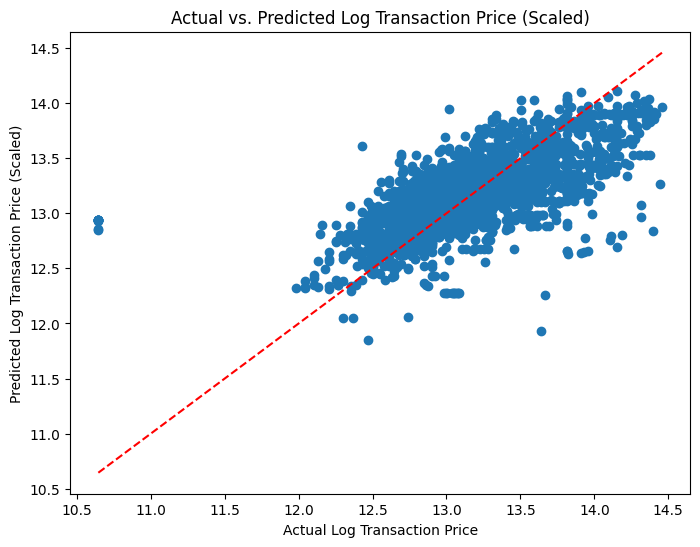


Comparison:
Mean Squared Error (Original): 0.14505925707224995
R-squared (Original): 0.44230936101725127
Mean Squared Error (Scaled): 0.14505925707224987
R-squared (Scaled): 0.4423093610172516


,Metric,Original,Scaled
0,Mean Squared Error,0.145059,0.145059
1,R-squared,0.442309,0.442309


In [ ]:
# apply feature scaling and compare results before and after

from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data (using the same scaler fitted on the training data)
X_test_scaled = scaler.transform(X_test)


# Initialize and train the linear regression model with scaled data
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)

# Make predictions on the scaled test set
y_pred_scaled = model_scaled.predict(X_test_scaled)

# Evaluate the model with scaled data
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)

print(f"Mean Squared Error (Scaled): {mse_scaled}")
print(f"R-squared (Scaled): {r2_scaled}")

# Plot the predicted vs. actual values for the scaled data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_scaled)
plt.xlabel("Actual Log Transaction Price")
plt.ylabel("Predicted Log Transaction Price (Scaled)")
plt.title("Actual vs. Predicted Log Transaction Price (Scaled)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line
plt.show()

# Compare the results
print("\nComparison:")
print(f"Mean Squared Error (Original): {mse}")
print(f"R-squared (Original): {r2}")
print(f"Mean Squared Error (Scaled): {mse_scaled}")
print(f"R-squared (Scaled): {r2_scaled}")

# Create a comparison DataFrame
comparison_data = {
    'Metric': ['Mean Squared Error', 'R-squared'],
    'Original': [mse, r2],
    'Scaled': [mse_scaled, r2_scaled]
}
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
display(comparison_df)

# Compare Models - Select the best model

Drive already mounted
Linear Regression:
  MSE: 0.14505925707224995
  R-squared: 0.44230936101725127
  MAE: 0.2820601978867216
Decision Tree:
  MSE: 0.033768238938043205
  R-squared: 0.870175601814232
  MAE: 0.11316468564600102
Random Forest:
  MSE: 0.025355838103705165
  R-squared: 0.9025176756078699
  MAE: 0.10328549738356109
Gradient Boosting:
  MSE: 0.059522710459131455
  R-squared: 0.7711607028746567
  MAE: 0.1756353459839062

Best Model: Random Forest


,MSE,R-squared,MAE
Linear Regression,0.145059,0.442309,0.282060
Decision Tree,0.033768,0.870176,0.113165
Random Forest,0.025356,0.902518,0.103285
Gradient Boosting,0.059523,0.771161,0.175635


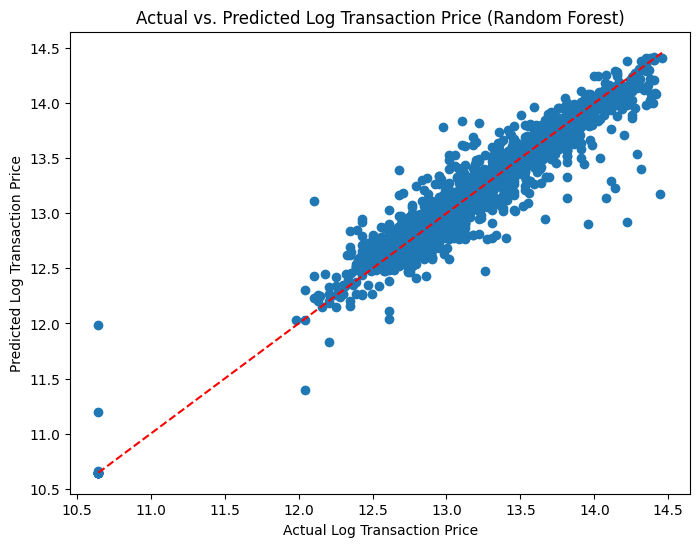

In [ ]:
# Compare models - select the best model

from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")


df = pd.read_csv('/content/drive/MyDrive/dataset/houseprice_Cleaned_OutlierRemoved_LabelEncoded_LogTransformed_MP1.csv')  # load CSV

# Drop the 'transaction price' column
#df = df.drop('Transaction Price', axis=1)

df = df.drop(['Transaction Date', 'Transaction Price', 'Land/Parcel Area'], axis=1)

# Assuming 'Log_Transaction_Price' is your target variable and other columns are features
X = df.drop('Log_Transaction_Price', axis=1)
y = df['Log_Transaction_Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Model Comparison
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred) # Calculate MAE
    results[name] = {"MSE": mse, "R-squared": r2, "MAE": mae} # Add MAE to results


for name, metrics in results.items():
  print(f"{name}:")
  print(f"  MSE: {metrics['MSE']}")
  print(f"  R-squared: {metrics['R-squared']}")
  print(f"  MAE: {metrics['MAE']}") # Print MAE


#Choose the best model based on results
best_model_name = min(results, key=lambda k: results[k]["MSE"])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# show result in tabular format
results_df = pd.DataFrame.from_dict(results, orient='index')
display(results_df)


import pickle

# Save the best model
filename = '/content/drive/MyDrive/dataset/best_property_prediction_model_MP1.sav'
pickle.dump(best_model, open(filename, 'wb'))


#Plot for best model
y_pred = best_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Log Transaction Price")
plt.ylabel("Predicted Log Transaction Price")
plt.title(f"Actual vs. Predicted Log Transaction Price ({best_model_name})")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line
plt.show()

In [ ]:
# prompt: please revise the code to add RSME

# Calculate MAE and RMSE for scaled data
mae_scaled = mean_absolute_error(y_test, y_pred_scaled)
rmse_scaled = np.sqrt(mse_scaled) # RMSE is the square root of MSE

print(f"Mean Absolute Error (Scaled): {mae_scaled}")
print(f"Root Mean Squared Error (Scaled): {rmse_scaled}")

# Compare the results with RMSE
print("\nComparison:")
print(f"Mean Squared Error (Original): {mse}")
print(f"R-squared (Original): {r2}")
print(f"Mean Absolute Error (Original): {mae}")
print(f"Root Mean Squared Error (Original): {rmse}")
print(f"Mean Squared Error (Scaled): {mse_scaled}")
print(f"R-squared (Scaled): {r2_scaled}")
print(f"Mean Absolute Error (Scaled): {mae_scaled}")
print(f"Root Mean Squared Error (Scaled): {rmse_scaled}")

# Update comparison DataFrame to include MAE and RMSE
comparison_data = {
    'Metric': ['Mean Squared Error', 'R-squared', 'Mean Absolute Error', 'Root Mean Squared Error'],
    'Original': [mse, r2, mae, rmse],
    'Scaled': [mse_scaled, r2_scaled, mae_scaled, rmse_scaled]
}
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
display(comparison_df)

# Add RMSE to the results dictionary for model comparison
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse) # Calculate RMSE
    results[name] = {"MSE": mse, "R-squared": r2, "MAE": mae, "RMSE": rmse} # Add RMSE to results

for name, metrics in results.items():
  print(f"{name}:")
  print(f"  MSE: {metrics['MSE']:.4f}")
  print(f"  R-squared: {metrics['R-squared']:.4f}")
  print(f"  MAE: {metrics['MAE']:.4f}")
  print(f"  RMSE: {metrics['RMSE']:.4f}") # Print RMSE

# show result in tabular format with RMSE
results_df = pd.DataFrame.from_dict(results, orient='index')
display(results_df)


Mean Absolute Error (Scaled): 0.28206019788672165
Root Mean Squared Error (Scaled): 0.3808664556931338

Comparison:
Mean Squared Error (Original): 0.059522710459131455
R-squared (Original): 0.7711607028746567
Mean Absolute Error (Original): 0.1756353459839062
Root Mean Squared Error (Original): 0.38086645569313393
Mean Squared Error (Scaled): 0.14505925707224987
R-squared (Scaled): 0.4423093610172516
Mean Absolute Error (Scaled): 0.28206019788672165
Root Mean Squared Error (Scaled): 0.3808664556931338


,Metric,Original,Scaled
0,Mean Squared Error,0.059523,0.145059
1,R-squared,0.771161,0.442309
2,Mean Absolute Error,0.175635,0.282060
3,Root Mean Squared Error,0.380866,0.380866


Linear Regression:
  MSE: 0.1451
  R-squared: 0.4423
  MAE: 0.2821
  RMSE: 0.3809
Decision Tree:
  MSE: 0.0338
  R-squared: 0.8702
  MAE: 0.1132
  RMSE: 0.1838
Random Forest:
  MSE: 0.0254
  R-squared: 0.9025
  MAE: 0.1033
  RMSE: 0.1592
Gradient Boosting:
  MSE: 0.0595
  R-squared: 0.7712
  MAE: 0.1756
  RMSE: 0.2440


,MSE,R-squared,MAE,RMSE
Linear Regression,0.145059,0.442309,0.282060,0.380866
Decision Tree,0.033768,0.870176,0.113165,0.183761
Random Forest,0.025356,0.902518,0.103285,0.159235
Gradient Boosting,0.059523,0.771161,0.175635,0.243973


Training XGBoost Regressor...

XGBoost Regressor MAE: 0.13597609494869284
XGBoost Regressor MSE: 0.038612847385782655
XGBoost Regressor R-squared: 0.8515501598026591
XGBoost Regressor RMSE: 0.19650152005972538


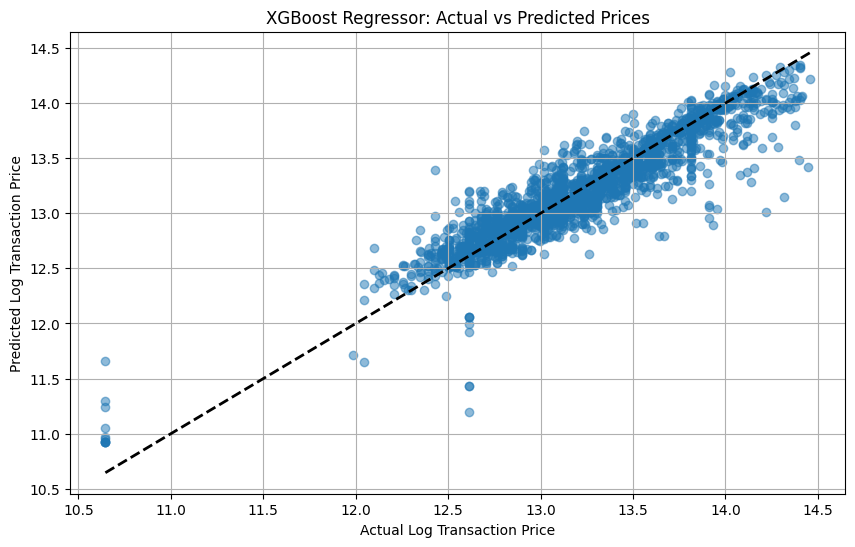

In [ ]:
# prompt: train using XGB and evaluate

!pip install xgboost
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/dataset/houseprice_Cleaned_OutlierRemoved_LabelEncoded_LogTransformed_MP1.csv')  # load CSV

# Drop the 'transaction price' column
#df = df.drop('Transaction Price', axis=1)

df = df.drop(['Transaction Date', 'Transaction Price', 'Land/Parcel Area'], axis=1)

# Assuming 'Log_Transaction_Price' is your target variable and other columns are features
X = df.drop('Log_Transaction_Price', axis=1)
y = df['Log_Transaction_Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Create an XGBoost Regressor model
# You can adjust hyperparameters like n_estimators, learning_rate, max_depth, etc.
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', # for regression task
                             n_estimators=100,
                             learning_rate=0.1,
                             max_depth=5,
                             random_state=42)

# Train the model
print("Training XGBoost Regressor...")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"\nXGBoost Regressor MAE: {mae_xgb}")
print(f"XGBoost Regressor MSE: {mse_xgb}")
print(f"XGBoost Regressor R-squared: {r2_xgb}")
print(f"XGBoost Regressor RMSE: {rmse_xgb}")

# Plot actual vs predicted values for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Actual Log Transaction Price')
plt.ylabel('Predicted Log Transaction Price')
plt.title('XGBoost Regressor: Actual vs Predicted Prices')
plt.grid(True)
plt.show()

# You can also add XGBoost to your model comparison results dictionary
# results["XGBoost"] = {"MSE": mse_xgb, "R-squared": r2_xgb, "MAE": mae_xgb, "RMSE": rmse_xgb}

# Display the updated comparison table
#print("\n--- Updated Model Comparison ---")
#results_df = pd.DataFrame.from_dict(results, orient='index')
#display(results_df)
